**Description**: Read and analyze simulations data in IBM Cloudant

Powered by Seaborn 

*   [Tutorial](https://www.mygreatlearning.com/blog/seaborn-tutorial/#sh5)
*   [Visualizing distributions](https://seaborn.pydata.org/tutorial/distributions.html)


# Libraries and others

In [ ]:
import json
import numpy as np
import pandas as pd
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def read_phenotypes(gspace_name):
  phenotypes_file = open("/content/drive/My Drive/Thesis/Code/allGraphsReady/phenotypes_"+gspace_name+".txt", "r")
  phenotypes = phenotypes_file.read().splitlines()
  phenotypes_file.close()

  return phenotypes

In [ ]:
url = "/content/drive/My Drive/Thesis/Code/newData/"

In [ ]:
names = ['four_phen', 'musculus', 'neurospora', 'arabidopsis']

File with the phenotypes at $n$ mutational steps, $n=1, 2, ..., diam(G)$, where $G$ is the genotype space

In [ ]:
distance = {}

distance_file = open("/content/drive/My Drive/Thesis/Code/allGraphsReady/distances_"+names[1]+".json", "r")
distance[names[1]] = json.load(distance_file)
distance_file.close()

distance_file = open("/content/drive/My Drive/Thesis/Code/allGraphsReady/distances_"+names[2]+".json", "r")
distance[names[2]] = json.load(distance_file)
distance_file.close()

distance_file = open("/content/drive/My Drive/Thesis/Code/allGraphsReady/distances_"+names[3]+".json", "r")
distance[names[3]] = json.load(distance_file)
distance_file.close()

In [ ]:
distance[names[1]].keys()

dict_keys(['6201', '17536', '2669', '16347', '18781', '14488', '16582', '3174', '4166', '4641'])

Parameters

In [ ]:
initial_node = {}

initial_node[names[1]] = list(distance[names[1]].keys())[0]
initial_node[names[2]] = list(distance[names[2]].keys())[0]
initial_node[names[3]] = list(distance[names[3]].keys())[0]

In [ ]:
gamma_c = 2e-8
gamma_q = 2e-5 #1e-4
decoherence_time = 50

In [ ]:
distance[names[1]][initial_node[names[1]]].keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8'])

In [ ]:
print(distance[names[1]][initial_node[names[1]]]['1'])

['Sfpi1', 'Zfp105', 'Gabpa', 'Sox21', 'Sox11', 'Arid5a', 'Zbtb12', 'Sox30', 'Mafb', 'Smad3', 'Setbp1', 'Sox14', 'Arid3a', 'Hoxa3', 'Ehf', 'Elf3', 'Sox12', 'Arid5b', 'Irf4', 'Sox4', 'Irf5', 'Sox13', 'Irf6', 'Irf3', 'Gata5', 'Sox17', 'Sry', 'Sox8', 'Sox5', 'Sox18', 'Tbp', 'Gata3', 'IRC900814', 'Sox7', 'Gata6', 'Irf7', 'Sox15', 'Isgf3g']


# Getting and processing the quantum model data

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
for i in [1,2,3]:
  print(names[i])

musculus
neurospora
arabidopsis


## Read and process data

In [ ]:
df_qw = {}
all_columns_qw = {}

In [ ]:
for i in [1, 2, 3]:
  gspace_name = names[i]
  qw_file = open("/content/drive/My Drive/Thesis/Code/newData/"+gspace_name+"-qw.json", "r")
  qw_data = json.load(qw_file)
  qw_file.close()

  print("Genotype space:", gspace_name)
  print("Keys:", qw_data.keys())
  print("Number of data:", qw_data['total_rows'])

  all_columns_qw[gspace_name] = list(qw_data['rows'][0]['doc'].keys()) # columns of dataframe

  data_qw = {}
  for key in all_columns_qw[gspace_name]:
    data_qw[key] = []

  for i in range(qw_data['total_rows']):
    for key in all_columns_qw[gspace_name]:
      data_qw[key].append(qw_data['rows'][i]['doc'][key])
  
  df_qw[gspace_name] = pd.DataFrame(data_qw)

  # cleaning data
  df_qw[gspace_name]['datetime'] = pd.to_datetime(df_qw[gspace_name]['datetime'], dayfirst=True)
  df_qw[gspace_name]['computing_time'] = df_qw[gspace_name]['computing_time']/3600
  df_qw[gspace_name]['simulation_time'] = df_qw[gspace_name]['simulation_time']/3600

Genotype space: musculus
Keys: dict_keys(['total_rows', 'offset', 'rows'])
Number of data: 6072
Genotype space: neurospora
Keys: dict_keys(['total_rows', 'offset', 'rows'])
Number of data: 5252
Genotype space: arabidopsis
Keys: dict_keys(['total_rows', 'offset', 'rows'])
Number of data: 1637


Filter data with parameters of interest and quit redundant information

In [ ]:
df_qw_filter = {}

In [ ]:
for i in [1,2,3]:
  gspace_name = names[i]
  print("Genotype space:", gspace_name)

  no_sense_columns = ['initial_gen_index', 'initial_gen', 'initial_phen', 'max_simulation_time', 'transition_rate', 'measurement_rate']
  columns_qw = [key for key in all_columns_qw[gspace_name] if key not in no_sense_columns ]

  print("Size of data without filter:", len(df_qw[gspace_name]))
  df_qw_filter[gspace_name] = df_qw[gspace_name][(df_qw[gspace_name]['transition_rate'] == gamma_q) & (df_qw[gspace_name]['measurement_rate'] == decoherence_time) 
    & (df_qw[gspace_name]['initial_gen_index'] == int(initial_node[gspace_name]))][columns_qw]
  print("Size of filtered data:", len(df_qw_filter[gspace_name]))

  print("\n")

Genotype space: musculus
Size of data without filter: 6072
Size of filtered data: 6022


Genotype space: neurospora
Size of data without filter: 5252
Size of filtered data: 5242


Genotype space: arabidopsis
Size of data without filter: 1637
Size of filtered data: 1637




## Mus musculus

In [ ]:
gspace_name = names[1]

In [ ]:
df_qw_filter[gspace_name]['simulation_time'].describe()

count    6022.000000
mean     5396.314432
std      1902.725264
min       669.278679
25%      4047.617329
50%      4947.897715
75%      7078.156566
max      9859.226793
Name: simulation_time, dtype: float64

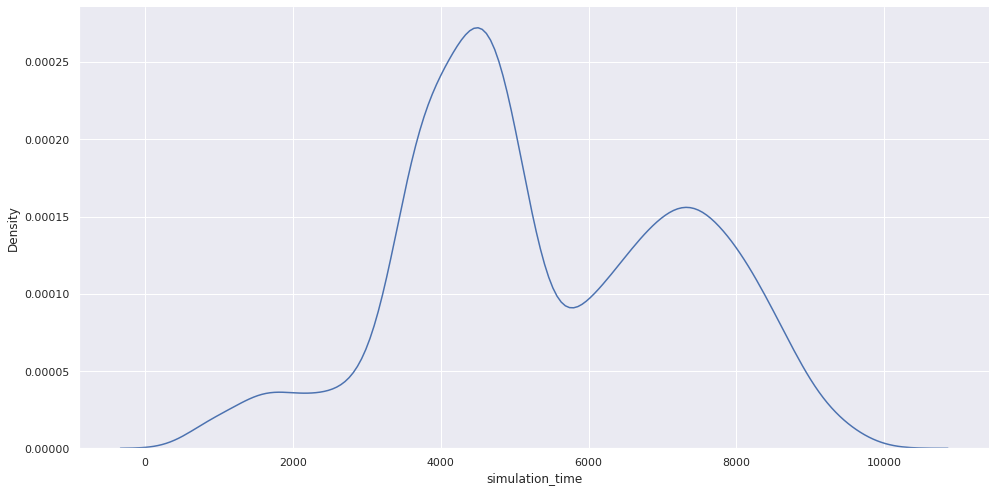

In [ ]:
sns.displot(df_qw_filter[gspace_name], x='simulation_time', kind="kde", palette="Reds", height=7, aspect=2)

In order to have more control in the experiments, we only considered those simulations that simulated the quantum walk during a time between 4000 and 8000 hours

In [ ]:
df_qw_filter[gspace_name] = df_qw_filter[gspace_name][(df_qw_filter[gspace_name]['simulation_time'] >= 4000) & (df_qw_filter[gspace_name]['simulation_time'] <= 8000)]

In [ ]:
df_qw_filter[gspace_name] = df_qw_filter[gspace_name][df_qw_filter[gspace_name]['computing_time'] > 58]

In [ ]:
df_qw_filter[gspace_name].shape[0]

3735

We only consider 3000 simulations

In [ ]:
df_qw_filter[gspace_name] = df_qw_filter[gspace_name].sample(n=3000, random_state=1)

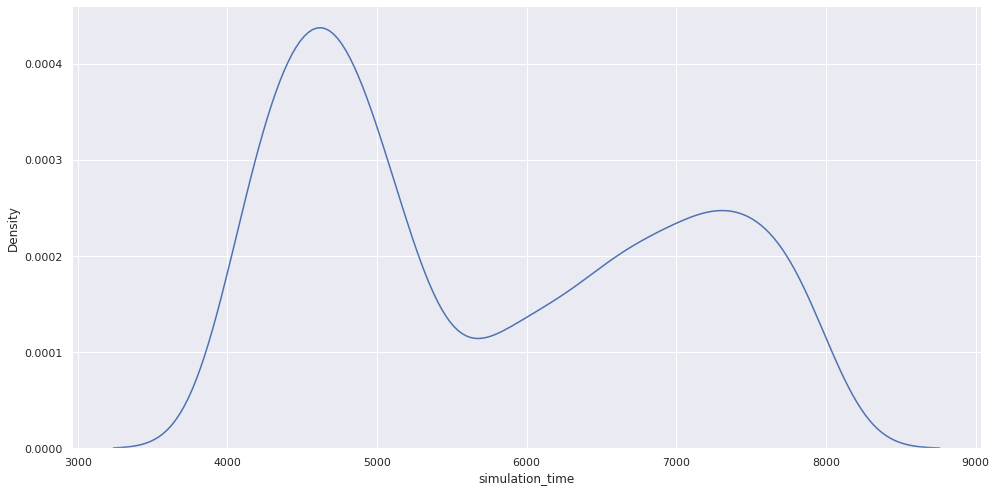

In [ ]:
sns.displot(df_qw_filter[gspace_name], x='simulation_time', kind="kde", palette="Reds", height=7, aspect=2)

In [ ]:
df_qw_filter[gspace_name]['simulation_time'].describe()

count    3000.000000
mean     5754.554146
std      1258.826481
min      4000.255566
25%      4625.648419
50%      5291.736155
75%      6958.733144
max      7998.828388
Name: simulation_time, dtype: float64

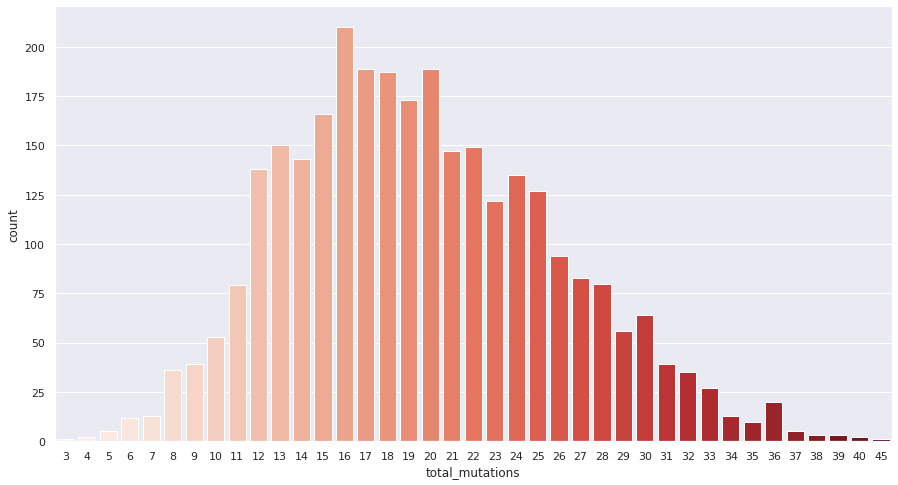

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x="total_mutations", data=df_qw_filter[gspace_name], palette="Reds")

In [ ]:
df_qw_filter[gspace_name]['total_mutations'].describe()

count    3000.000000
mean       19.556333
std         6.293809
min         3.000000
25%        15.000000
50%        19.000000
75%        24.000000
max        45.000000
Name: total_mutations, dtype: float64

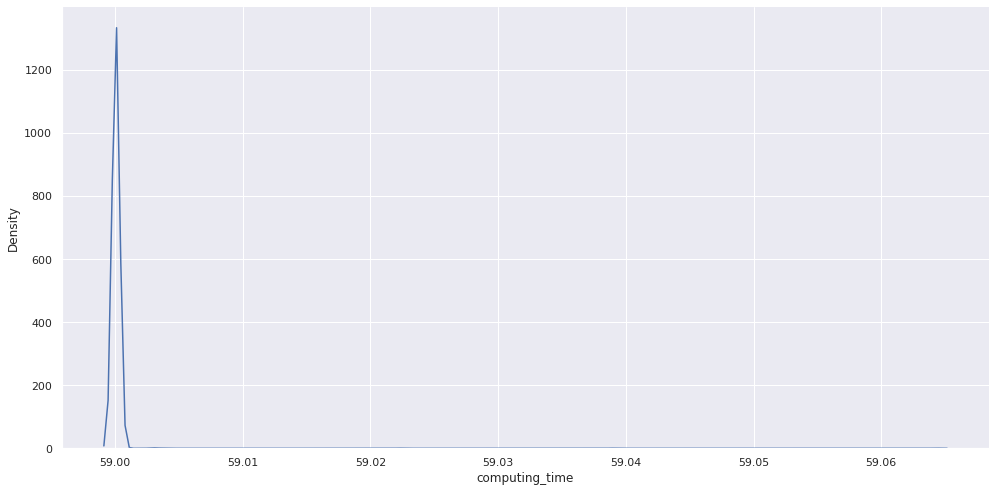

In [ ]:
sns.displot(df_qw_filter[gspace_name], x='computing_time', kind="kde", palette="Reds", height=7, aspect=2)

In [ ]:
df_qw_filter[gspace_name]['computing_time'].describe()

count    3000.000000
mean       59.000125
std         0.001439
min        59.000000
25%        59.000034
50%        59.000072
75%        59.000111
max        59.064289
Name: computing_time, dtype: float64

In [ ]:
df_qw_filter[gspace_name]['coverage_rate'] = df_qw_filter[gspace_name]['total_mutations']/(df_qw_filter[gspace_name]['simulation_time']*3600) # mutations/second

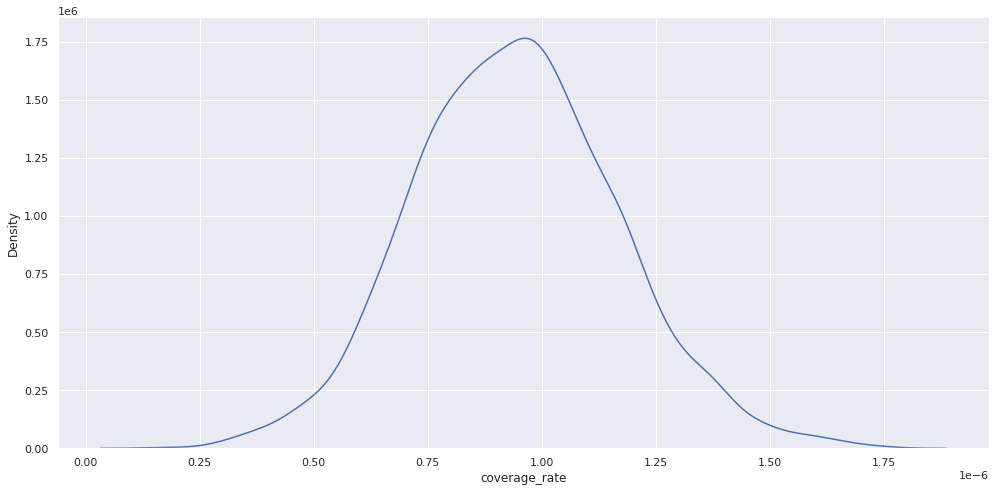

In [ ]:
sns.displot(x='coverage_rate', data=df_qw_filter[gspace_name], kind="kde", palette="Reds", height=7, aspect=2)

In [ ]:
df_qw_filter[gspace_name]['coverage_rate'].describe()

count    3.000000e+03
mean     9.432422e-07
std      2.251739e-07
min      1.681888e-07
25%      7.889782e-07
50%      9.412100e-07
75%      1.089459e-06
max      1.752640e-06
Name: coverage_rate, dtype: float64

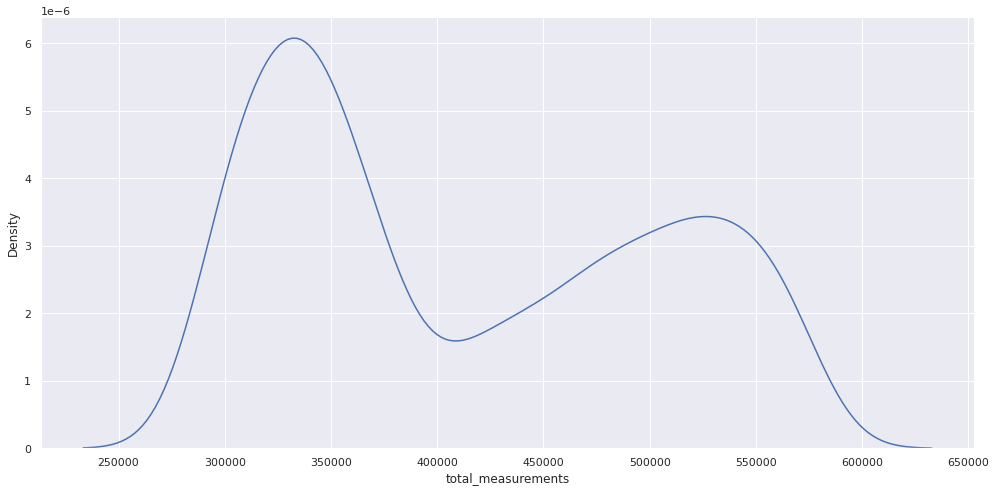

In [ ]:
sns.displot(x='total_measurements', data=df_qw_filter[gspace_name], kind="kde", palette="Reds", height=7, aspect=2)

In [ ]:
df_qw_filter[gspace_name]['total_measurements'].describe()

count      3000.000000
mean     414338.394000
std       90645.347738
min      288181.000000
25%      333220.000000
50%      381334.500000
75%      500744.000000
max      577849.000000
Name: total_measurements, dtype: float64

In [ ]:
times_hitted_phen = {}
for step in distance[gspace_name][initial_node[gspace_name]].keys():
  total = len(distance[gspace_name][initial_node[gspace_name]][step])
  if total == 0:
    continue

  print(f"Total number of phenotypes at {step} mutational step(s):", total)
  hitted_phens = 0
  hitted_phens_50 = 0

  for phen in distance[gspace_name][initial_node[gspace_name]][step]:
    times_hitted_phen[phen] = df_qw_filter[gspace_name][df_qw_filter[gspace_name][f"mutations_{phen}"] != -1].shape[0] # number of simulations that hitted current phenotype
    
    if times_hitted_phen[phen] > 0:
      hitted_phens += 1
    if times_hitted_phen[phen]/total >= 0.5:
      hitted_phens_50 += 1
  
  print("Number of phenotypes \n... that were hitted at least once:", hitted_phens,"/",total,)
  print("... that were hitted more than 50% of the simulations:", hitted_phens_50,"/",total, "\n")

Total number of phenotypes at 0 mutational step(s): 1
Number of phenotypes 
... that were hitted at least once: 1 / 1
... that were hitted more than 50% of the simulations: 1 / 1 

Total number of phenotypes at 1 mutational step(s): 38
Number of phenotypes 
... that were hitted at least once: 38 / 38
... that were hitted more than 50% of the simulations: 38 / 38 

Total number of phenotypes at 2 mutational step(s): 85
Number of phenotypes 
... that were hitted at least once: 85 / 85
... that were hitted more than 50% of the simulations: 85 / 85 

Total number of phenotypes at 3 mutational step(s): 61
Number of phenotypes 
... that were hitted at least once: 61 / 61
... that were hitted more than 50% of the simulations: 60 / 61 

Total number of phenotypes at 4 mutational step(s): 5
Number of phenotypes 
... that were hitted at least once: 5 / 5
... that were hitted more than 50% of the simulations: 5 / 5 



## Neurospora crassa

In [ ]:
gspace_name = names[2]

In [ ]:
df_qw_filter[gspace_name]

,_id,_rev,datetime,total_measurements,total_mutations,computing_time,simulation_time,tau_NCU05308,N_NCU05308,mutations_NCU05308,tau_vad-5,N_vad-5,mutations_vad-5,tau_NCU06907,N_NCU06907,mutations_NCU06907,tau_NCU02173,N_NCU02173,mutations_NCU02173,tau_NCU08159,N_NCU08159,mutations_NCU08159,tau_NCU01243,N_NCU01243,mutations_NCU01243,tau_NCU06971,N_NCU06971,mutations_NCU06971,tau_NCU01386,N_NCU01386,mutations_NCU01386,tau_NCU05022,N_NCU05022,mutations_NCU05022,tau_NCU06487,N_NCU06487,mutations_NCU06487,tau_NCU02819,N_NCU02819,mutations_NCU02819,...,mutations_NCU00090,tau_NCU03110,N_NCU03110,mutations_NCU03110,tau_NCU01924,N_NCU01924,mutations_NCU01924,tau_NCU00155,N_NCU00155,mutations_NCU00155,tau_NCU05285,N_NCU05285,mutations_NCU05285,tau_NCU07587,N_NCU07587,mutations_NCU07587,tau_NCU02787,N_NCU02787,mutations_NCU02787,tau_NCU04848,N_NCU04848,mutations_NCU04848,tau_NCU01122,N_NCU01122,mutations_NCU01122,tau_NCU05024,N_NCU05024,mutations_NCU05024,tau_NCU05242,N_NCU05242,mutations_NCU05242,tau_NCU08744,N_NCU08744,mutations_NCU08744,tau_NCU07392,N_NCU07392,mutations_NCU07392,tau_NCU05635,N_NCU05635,mutations_NCU05635
0,00055448-5ce6-11ec-9a85-fa4903ac2172,1-c42fea8d5f009cd492c92da6365e2797,2021-12-14 13:59:04,570923,20,5.138896,7921.658192,2.851797e+07,-1,-1,2.851797e+07,-1,-1,2.851797e+07,-1,-1,2.851797e+07,-1,-1,2.851797e+07,-1,-1,9.986146e+06,199632,7,2.851797e+07,-1,-1,2.851797e+07,-1,-1,2.851797e+07,-1,-1,2.851797e+07,-1,-1,2.851797e+07,-1,-1,...,-1,9.352366e+06,187092,6,1.909892e+07,381832,16,2.851797e+07,-1,-1,2.851797e+07,-1,-1,1.011546e+07,202193,8,2.851797e+07,-1,-1,9.352366e+06,187092,6,2.851797e+07,-1,-1,1.128720e+07,225407,9,2.851797e+07,-1,-1,1.717025e+07,343132,13,1.011546e+07,202193,8,2.851797e+07,-1,-1
1,00067df0-4e22-11ec-ac63-dea325d578b4,25-8ba5246f09dd3406ebbdaf97c5bfc5a1,2021-11-25 19:00:34,402686,13,59.000056,5579.723795,2.008701e+07,-1,-1,2.008701e+07,-1,-1,2.008701e+07,-1,-1,2.008701e+07,-1,-1,2.008701e+07,-1,-1,2.008701e+07,-1,-1,2.008701e+07,-1,-1,2.008701e+07,-1,-1,2.008701e+07,-1,-1,2.008701e+07,-1,-1,2.008701e+07,-1,-1,...,-1,2.008701e+07,-1,-1,2.008701e+07,-1,-1,2.008701e+07,-1,-1,2.008701e+07,-1,-1,2.008701e+07,-1,-1,2.008701e+07,-1,-1,2.008701e+07,-1,-1,1.463857e+07,293028,12,2.008701e+07,-1,-1,2.008701e+07,-1,-1,1.463857e+07,293028,12,2.008701e+07,-1,-1,2.008701e+07,-1,-1
2,003aa022-5b05-11ec-96c9-beb2ba3fa168,1-6a32a99a673ba1fbb70f3d1edd8757d5,2021-12-12 04:35:57,534502,18,5.138898,7432.981746,2.675873e+07,-1,-1,2.675873e+07,-1,-1,2.675873e+07,-1,-1,2.675873e+07,-1,-1,2.675873e+07,-1,-1,2.675873e+07,-1,-1,2.675873e+07,-1,-1,2.675873e+07,-1,-1,2.675873e+07,-1,-1,2.675873e+07,-1,-1,2.675873e+07,-1,-1,...,-1,2.675873e+07,-1,-1,2.675873e+07,-1,-1,2.675873e+07,-1,-1,2.675873e+07,-1,-1,2.675873e+07,-1,-1,2.675873e+07,-1,-1,2.675873e+07,-1,-1,2.675873e+07,-1,-1,2.675873e+07,-1,-1,2.675873e+07,-1,-1,2.011937e+07,401892,16,2.675873e+07,-1,-1,3.121621e+06,62087,4
3,005bcd5a-52d2-11ec-b727-66bf74c6bdb8,8-892831741be6baed4b32e38f38415e1f,2021-12-01 18:10:34,179532,4,25.000062,2501.110763,9.003999e+06,-1,-1,9.003999e+06,-1,-1,9.003999e+06,-1,-1,9.003999e+06,-1,-1,4.873150e+06,97494,3,9.003999e+06,-1,-1,9.003999e+06,-1,-1,9.003999e+06,-1,-1,9.003999e+06,-1,-1,9.003999e+06,-1,-1,9.003999e+06,-1,-1,...,-1,9.003999e+06,-1,-1,9.003999e+06,-1,-1,9.003999e+06,-1,-1,9.003999e+06,-1,-1,9.003999e+06,-1,-1,9.003999e+06,-1,-1,9.003999e+06,-1,-1,9.003999e+06,-1,-1,9.003999e+06,-1,-1,9.003999e+06,-1,-1,9.003999e+06,-1,-1,9.003999e+06,-1,-1,9.003999e+06,-1,-1
4,008f9e48-56f9-11ec-a54e-32a58be9849a,3-c9adbfc060c3d072e976f6251ada199e,2021-12-07 00:59:50,146218,12,15.000044,2026.467946,7.295285e+06,-1,-1,7.295285e+06,-1,-1,7.295285e+06,-1,-1,7.295285e+06,-1,-1,7.295285e+06,-1,-1,7.295285e+06,-1,-1,7.295285e+06,-1,-1,7.295285e+06,-1,-1,7.295285e+06,-1,-1,7.295285e+06,-1,-1,7.295285e+06,-1,-1,...,-1,7.295285e+06,-1,-1,7.295285e+06,-1,-1,7.295285e+06,-1,-1,7.295285e+06,-1,-1,7.295285e+06,-1,-1,7.295285e+06,-1,-1,7.295285e+06,-1,-

In [ ]:
df2 = df_qw_filter[gspace_name][df_qw_filter[gspace_name]['computing_time'] > 58]

In [ ]:
df2['simulation_time'].describe()

count     2202.000000
mean      6440.489317
std       1845.027205
min       4083.307152
25%       4854.076843
50%       5981.884170
75%       7716.558208
max      12520.402250
Name: simulation_time, dtype: float64

In [ ]:
df = df_qw_filter[gspace_name][df_qw_filter[gspace_name]['computing_time'] < 10]

In [ ]:
df['simulation_time'].describe()

count     1558.000000
mean      5932.308175
std       1551.935992
min       3885.713776
25%       4779.654321
50%       5229.509078
75%       7390.469011
max      10958.495413
Name: simulation_time, dtype: float64

In [ ]:
df[(df['simulation_time'] >= 4000) & (df['simulation_time'] <= 8000)]

,_id,_rev,datetime,total_measurements,total_mutations,computing_time,simulation_time,tau_NCU05308,N_NCU05308,mutations_NCU05308,tau_vad-5,N_vad-5,mutations_vad-5,tau_NCU06907,N_NCU06907,mutations_NCU06907,tau_NCU02173,N_NCU02173,mutations_NCU02173,tau_NCU08159,N_NCU08159,mutations_NCU08159,tau_NCU01243,N_NCU01243,mutations_NCU01243,tau_NCU06971,N_NCU06971,mutations_NCU06971,tau_NCU01386,N_NCU01386,mutations_NCU01386,tau_NCU05022,N_NCU05022,mutations_NCU05022,tau_NCU06487,N_NCU06487,mutations_NCU06487,tau_NCU02819,N_NCU02819,mutations_NCU02819,...,mutations_NCU00090,tau_NCU03110,N_NCU03110,mutations_NCU03110,tau_NCU01924,N_NCU01924,mutations_NCU01924,tau_NCU00155,N_NCU00155,mutations_NCU00155,tau_NCU05285,N_NCU05285,mutations_NCU05285,tau_NCU07587,N_NCU07587,mutations_NCU07587,tau_NCU02787,N_NCU02787,mutations_NCU02787,tau_NCU04848,N_NCU04848,mutations_NCU04848,tau_NCU01122,N_NCU01122,mutations_NCU01122,tau_NCU05024,N_NCU05024,mutations_NCU05024,tau_NCU05242,N_NCU05242,mutations_NCU05242,tau_NCU08744,N_NCU08744,mutations_NCU08744,tau_NCU07392,N_NCU07392,mutations_NCU07392,tau_NCU05635,N_NCU05635,mutations_NCU05635
0,00055448-5ce6-11ec-9a85-fa4903ac2172,1-c42fea8d5f009cd492c92da6365e2797,2021-12-14 13:59:04,570923,20,5.138896,7921.658192,2.851797e+07,-1,-1,2.851797e+07,-1,-1,2.851797e+07,-1,-1,2.851797e+07,-1,-1,2.851797e+07,-1,-1,9.986146e+06,199632,7,2.851797e+07,-1,-1,2.851797e+07,-1,-1,2.851797e+07,-1,-1,2.851797e+07,-1,-1,2.851797e+07,-1,-1,...,-1,9.352366e+06,187092,6,1.909892e+07,381832,16,2.851797e+07,-1,-1,2.851797e+07,-1,-1,1.011546e+07,202193,8,2.851797e+07,-1,-1,9.352366e+06,187092,6,2.851797e+07,-1,-1,1.128720e+07,225407,9,2.851797e+07,-1,-1,1.717025e+07,343132,13,1.011546e+07,202193,8,2.851797e+07,-1,-1
2,003aa022-5b05-11ec-96c9-beb2ba3fa168,1-6a32a99a673ba1fbb70f3d1edd8757d5,2021-12-12 04:35:57,534502,18,5.138898,7432.981746,2.675873e+07,-1,-1,2.675873e+07,-1,-1,2.675873e+07,-1,-1,2.675873e+07,-1,-1,2.675873e+07,-1,-1,2.675873e+07,-1,-1,2.675873e+07,-1,-1,2.675873e+07,-1,-1,2.675873e+07,-1,-1,2.675873e+07,-1,-1,2.675873e+07,-1,-1,...,-1,2.675873e+07,-1,-1,2.675873e+07,-1,-1,2.675873e+07,-1,-1,2.675873e+07,-1,-1,2.675873e+07,-1,-1,2.675873e+07,-1,-1,2.675873e+07,-1,-1,2.675873e+07,-1,-1,2.675873e+07,-1,-1,2.675873e+07,-1,-1,2.011937e+07,401892,16,2.675873e+07,-1,-1,3.121621e+06,62087,4
5,00916eb2-59d3-11ec-919a-56f10bf01d23,1-a8e425c7bd95590b45e0bec2d9810df1,2021-12-10 16:05:31,296783,16,5.138905,4128.072557,1.486106e+07,-1,-1,1.486106e+07,-1,-1,1.486106e+07,-1,-1,1.486106e+07,-1,-1,1.486106e+07,-1,-1,1.486106e+07,-1,-1,1.486106e+07,-1,-1,1.486106e+07,-1,-1,1.486106e+07,-1,-1,1.486106e+07,-1,-1,1.273623e+07,254530,12,...,-1,1.486106e+07,-1,-1,1.486106e+07,-1,-1,1.486106e+07,-1,-1,1.486106e+07,-1,-1,1.486106e+07,-1,-1,1.486106e+07,-1,-1,1.486106e+07,-1,-1,1.486106e+07,-1,-1,1.486106e+07,-1,-1,1.486106e+07,-1,-1,1.486106e+07,-1,-1,1.486106e+07,-1,-1,1.052303e+07,210570,10
6,009a5494-5ce6-11ec-a675-e66d9db51099,1-26370d1c9b0687ff37caad56cb6058db,2021-12-14 13:59:05,309262,15,5.138899,4309.856668,4.006844e+06,79585,2,4.006844e+06,79585,2,1.551548e+07,-1,-1,4.006844e+06,79585,2,1.551548e+07,-1,-1,5.961385e+06,118411,7,1.551548e+07,-1,-1,4.224801e+06,83914,3,1.551548e+07,-1,-1,1.551548e+07,-1,-1,1.551548e+07,-1,-1,...,-1,5.075375e+06,100752,4,1.058695e+07,210588,12,4.006844e+06,79585,2,1.551548e+07,-1,-1,1.551548e+07,-1,-1,4.006844e+06,79585,2,1.292328e+07,257263,14,5.111758e+06,101535,5,1.551548e+07,-1,-1,5.111758e+06,101535,5,1.551548e+07,-1,-1,5.471350e+06,108667,6,1.551548e+07,-1,-1
16,01aef67e-5bb4-11ec-8580-8efc4dbafe69,1-f5077fb7190b7bc455fdc4b1d6bb35c0,2021-12-13 01:28:41,536991,25,5.138891,7462.255635,2.686412e+07,-1,-1,2.686412e+07,-1,-1,2.306240e+06,46293,2,2.686412e+07,-1,-1,2.412601e+07,482558,20,7.297864e+06,145835,6,2.686412e+07,-1,-1,2.686412e+07,-1,-1,1.679329e+07,335821,12,1.679329e+07,335821,12,2.686412e+07,-1,-1,...,-1,2.472642e+07,494558,22,2.686412e+07,-1,-1,2.686412e+07,-1,-1,2.686412e+07,-1,-1,2.4

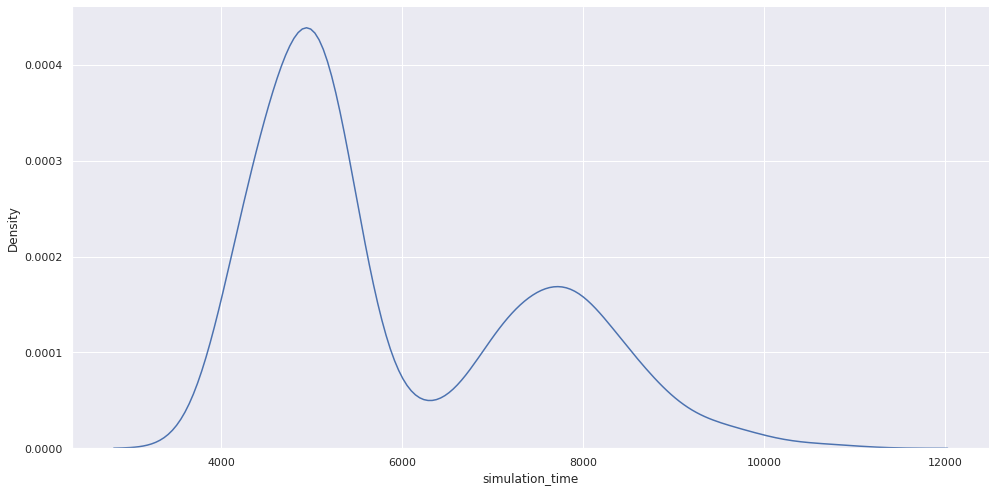

In [ ]:
sns.displot(x='simulation_time', data=df, kind='kde', height=7, aspect=2)

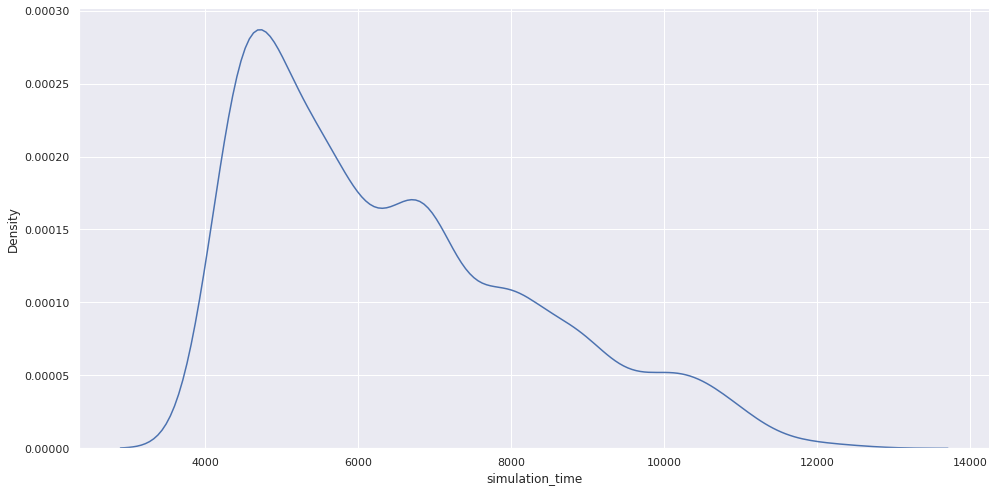

In [ ]:
sns.displot(x='simulation_time', data=df2, kind='kde', height=7, aspect=2)

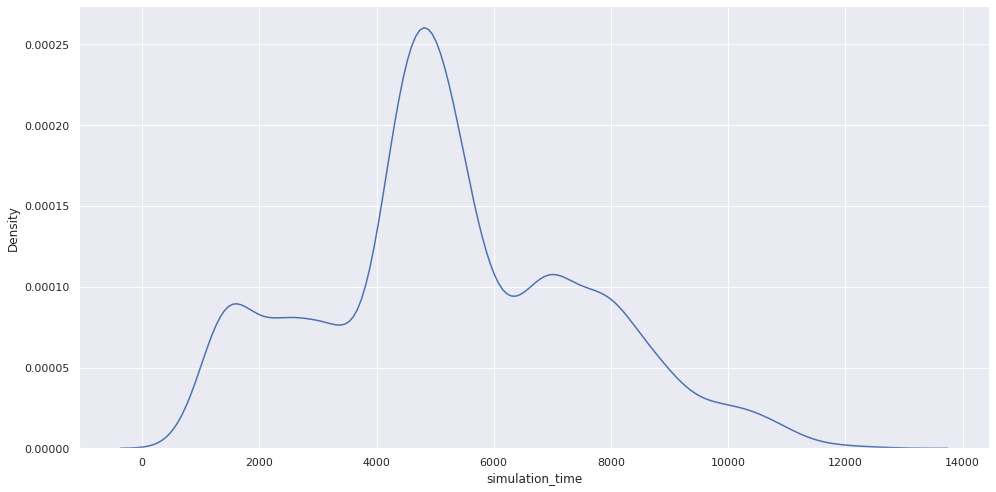

In [ ]:
sns.displot(df_qw_filter[gspace_name], x='simulation_time', kind="kde", palette="Reds", height=7, aspect=2)

In order to have more control in the experiments, we only considered those simulations that simulated the quantum walk during a time between 4000 and 8000 hours

In [ ]:
df_qw_filter[gspace_name] = df_qw_filter[gspace_name][(df_qw_filter[gspace_name]['simulation_time'] >= 4000) & (df_qw_filter[gspace_name]['simulation_time'] <= 8000)]

We only consider 3000 simulations

In [ ]:
df_qw_filter[gspace_name] = df_qw_filter[gspace_name].sample(n=3000, random_state=1)

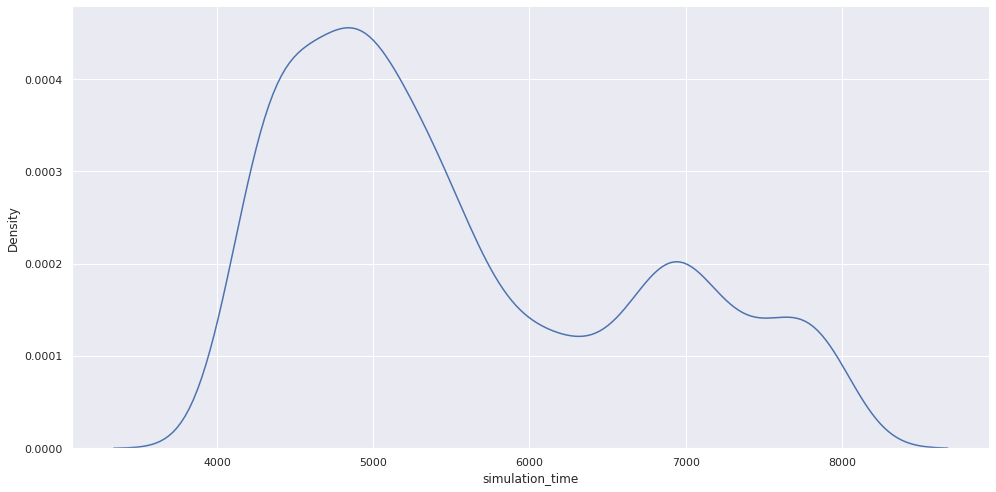

In [ ]:
sns.displot(df_qw_filter[gspace_name], x='simulation_time', kind="kde", palette="Reds", height=7, aspect=2)

In [ ]:
df_qw_filter[gspace_name]['simulation_time'].describe()

count    3000.000000
mean     5579.975195
std      1118.925242
min      4015.528547
25%      4682.289210
50%      5233.321365
75%      6566.047623
max      7999.645395
Name: simulation_time, dtype: float64

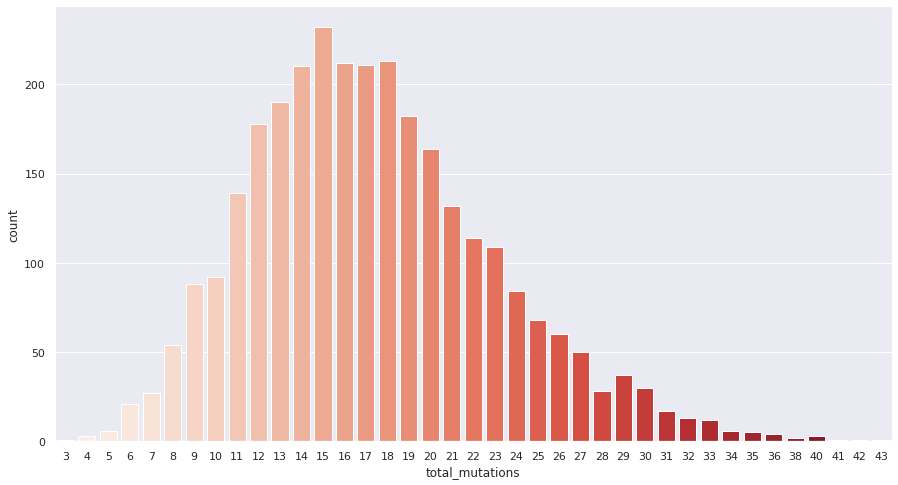

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x="total_mutations", data=df_qw_filter[gspace_name], palette="Reds")

In [ ]:
df_qw_filter[gspace_name]['total_mutations'].describe()

count    3000.000000
mean       17.321333
std         5.728847
min         3.000000
25%        13.000000
50%        17.000000
75%        21.000000
max        43.000000
Name: total_mutations, dtype: float64

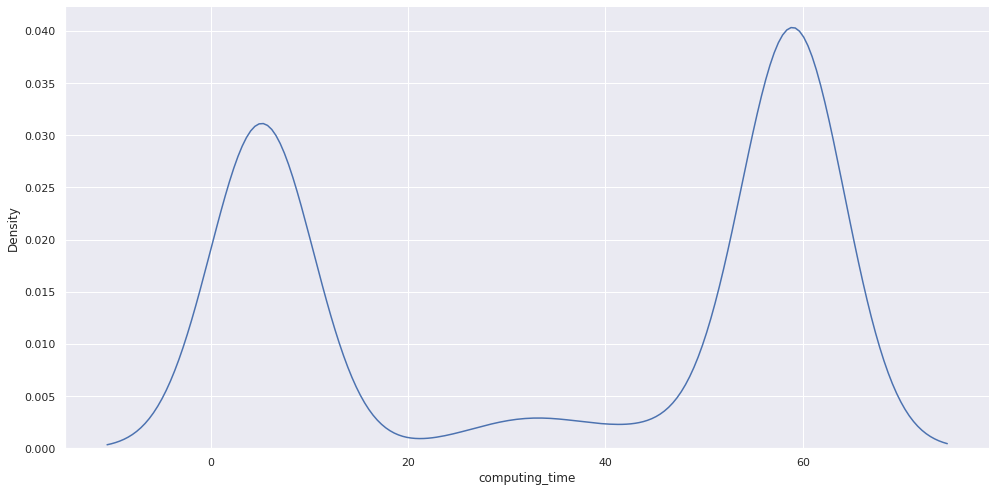

In [ ]:
sns.displot(df_qw_filter[gspace_name], x='computing_time', kind="kde", palette="Reds", height=7, aspect=2)

In [ ]:
df_qw_filter[gspace_name]['computing_time'].describe()

count    3000.000000
mean       35.587223
std        25.848584
min         5.138889
25%         5.138897
50%        59.000006
75%        59.000078
max        59.000595
Name: computing_time, dtype: float64

In [ ]:
df_qw_filter[gspace_name]['coverage_rate'] = df_qw_filter[gspace_name]['total_mutations']/(df_qw_filter[gspace_name]['simulation_time']*3600) # mutations/second

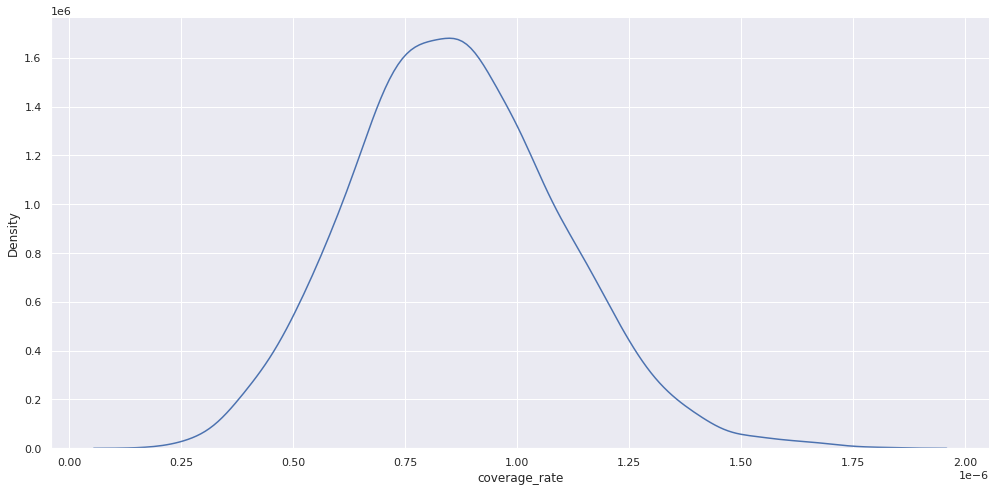

In [ ]:
sns.displot(x='coverage_rate', data=df_qw_filter[gspace_name], kind="kde", palette="Reds", height=7, aspect=2)

In [ ]:
df_qw_filter[gspace_name]['coverage_rate'].describe()

count    3.000000e+03
mean     8.637058e-07
std      2.337706e-07
min      1.959619e-07
25%      7.024576e-07
50%      8.541038e-07
75%      1.013299e-06
max      1.817437e-06
Name: coverage_rate, dtype: float64

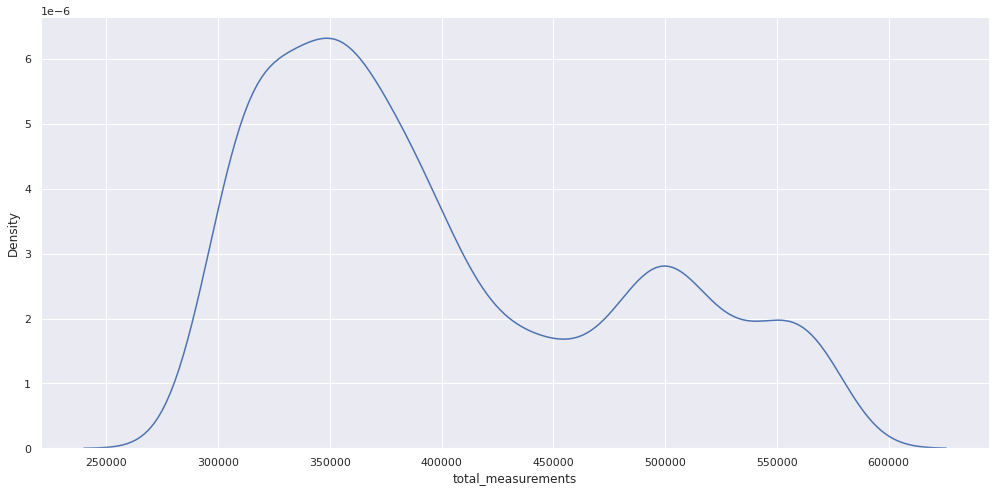

In [ ]:
sns.displot(x='total_measurements', data=df_qw_filter[gspace_name], kind="kde", palette="Reds", height=7, aspect=2)

In [ ]:
df_qw_filter[gspace_name]['total_measurements'].describe()

count      3000.000000
mean     401761.396667
std       80548.845534
min      288660.000000
25%      337373.750000
50%      376944.500000
75%      472876.250000
max      577006.000000
Name: total_measurements, dtype: float64

In [ ]:
times_hitted_phen = {}
for step in distance[gspace_name][initial_node[gspace_name]].keys():
  total = len(distance[gspace_name][initial_node[gspace_name]][step])
  if total == 0:
    continue

  print(f"Total number of phenotypes at {step} mutational step(s):", total)
  hitted_phens = 0
  hitted_phens_50 = 0

  for phen in distance[gspace_name][initial_node[gspace_name]][step]:
    times_hitted_phen[phen] = df_qw_filter[gspace_name][df_qw_filter[gspace_name][f"mutations_{phen}"] != -1].shape[0] # number of simulations that hitted current phenotype
    
    if times_hitted_phen[phen] > 0:
      hitted_phens += 1
    if times_hitted_phen[phen]/total >= 0.5:
      hitted_phens_50 += 1
  
  print("Number of phenotypes \n... that were hitted at least once:", hitted_phens,"/",total,)
  print("... that were hitted more than 50% of the simulations:", hitted_phens_50,"/",total, "\n")

Total number of phenotypes at 0 mutational step(s): 1
Number of phenotypes 
... that were hitted at least once: 1 / 1
... that were hitted more than 50% of the simulations: 1 / 1 

Total number of phenotypes at 1 mutational step(s): 29
Number of phenotypes 
... that were hitted at least once: 29 / 29
... that were hitted more than 50% of the simulations: 29 / 29 

Total number of phenotypes at 2 mutational step(s): 46
Number of phenotypes 
... that were hitted at least once: 46 / 46
... that were hitted more than 50% of the simulations: 46 / 46 

Total number of phenotypes at 3 mutational step(s): 41
Number of phenotypes 
... that were hitted at least once: 41 / 41
... that were hitted more than 50% of the simulations: 41 / 41 

Total number of phenotypes at 4 mutational step(s): 1
Number of phenotypes 
... that were hitted at least once: 1 / 1
... that were hitted more than 50% of the simulations: 1 / 1 



## Arabidopsis thaliana

In [ ]:
gspace_name = names[3]

In [ ]:
df_qw_filter[gspace_name]

,_id,_rev,datetime,total_measurements,total_mutations,computing_time,simulation_time,tau_GATA15,N_GATA15,mutations_GATA15,tau_EDT1,N_EDT1,mutations_EDT1,tau_WRKY15,N_WRKY15,mutations_WRKY15,tau_PIL5,N_PIL5,mutations_PIL5,tau_UNE10,N_UNE10,mutations_UNE10,tau_TRFL5,N_TRFL5,mutations_TRFL5,tau_AT1G01260,N_AT1G01260,mutations_AT1G01260,tau_CRF3,N_CRF3,mutations_CRF3,tau_Rap2.6L,N_Rap2.6L,mutations_Rap2.6L,tau_ATMYB4,N_ATMYB4,mutations_ATMYB4,tau_ATHB7,N_ATHB7,mutations_ATHB7,...,mutations_TGA1,tau_BZIP17,N_BZIP17,mutations_BZIP17,tau_AT4G00238,N_AT4G00238,mutations_AT4G00238,tau_WRKY48,N_WRKY48,mutations_WRKY48,tau_AT5G64220,N_AT5G64220,mutations_AT5G64220,tau_RBE,N_RBE,mutations_RBE,tau_TCP3,N_TCP3,mutations_TCP3,tau_NST1,N_NST1,mutations_NST1,tau_ATWRKY17,N_ATWRKY17,mutations_ATWRKY17,tau_SPL5,N_SPL5,mutations_SPL5,tau_AT5G46760,N_AT5G46760,mutations_AT5G46760,tau_WRKY23,N_WRKY23,mutations_WRKY23,tau_bHLH34,N_bHLH34,mutations_bHLH34,tau_AT5G05090,N_AT5G05090,mutations_AT5G05090
0,0000477c-5d32-11ec-b513-66b553e118a0,1-9c74cabd0073c4ab82543758a35c54ac,2021-12-14 23:03:06,476076,18,5.500011,6612.429237,2.380475e+07,-1,-1,2.380475e+07,-1,-1,2.380475e+07,-1,-1,2.380475e+07,-1,-1,2.380475e+07,-1,-1,2.380475e+07,-1,-1,2.380475e+07,-1,-1,2.380475e+07,-1,-1,2.380475e+07,-1,-1,2.380475e+07,-1,-1,2.380475e+07,-1,-1,...,-1,2.380475e+07,-1,-1,2.380475e+07,-1,-1,2.380475e+07,-1,-1,1.997101e+07,399204,15,2.380475e+07,-1,-1,2.380475e+07,-1,-1,2.380475e+07,-1,-1,2.380475e+07,-1,-1,1.616520e+07,323152,9,2.380475e+07,-1,-1,2.380475e+07,-1,-1,2.380475e+07,-1,-1,2.380475e+07,-1,-1
1,0009b2fa-5fbf-11ec-80fc-a64300f5c9c1,1-5442168356ddfff65f88d7e4190adbf4,2021-12-18 04:57:27,639870,25,5.500004,8894.635613,3.202069e+07,-1,-1,3.202069e+07,-1,-1,3.202069e+07,-1,-1,3.202069e+07,-1,-1,3.202069e+07,-1,-1,3.202069e+07,-1,-1,3.202069e+07,-1,-1,3.202069e+07,-1,-1,3.202069e+07,-1,-1,3.202069e+07,-1,-1,3.202069e+07,-1,-1,...,-1,3.202069e+07,-1,-1,3.202069e+07,-1,-1,3.202069e+07,-1,-1,3.202069e+07,-1,-1,4.165523e+06,83411,4,3.202069e+07,-1,-1,3.202069e+07,-1,-1,3.202069e+07,-1,-1,3.202069e+07,-1,-1,3.202069e+07,-1,-1,3.202069e+07,-1,-1,3.202069e+07,-1,-1,3.202069e+07,-1,-1
2,0023491a-601c-11ec-8c14-feb982b80b53,1-c21494e511a6c810c764c8a487e232d5,2021-12-18 16:03:11,678276,37,5.500007,9424.284327,3.392742e+07,-1,-1,3.392742e+07,-1,-1,3.392742e+07,-1,-1,3.392742e+07,-1,-1,3.392742e+07,-1,-1,3.392742e+07,-1,-1,3.392742e+07,-1,-1,3.392742e+07,-1,-1,2.871115e+07,574179,32,3.392742e+07,-1,-1,3.392742e+07,-1,-1,...,-1,3.392742e+07,-1,-1,3.038371e+07,607504,34,2.397940e+07,479506,25,3.392742e+07,-1,-1,3.392742e+07,-1,-1,3.392742e+07,-1,-1,3.392742e+07,-1,-1,3.392742e+07,-1,-1,3.392742e+07,-1,-1,3.392742e+07,-1,-1,3.392742e+07,-1,-1,3.392742e+07,-1,-1,1.461877e+06,29288,3
3,00358fc2-5d32-11ec-905f-821274af0f32,1-55fc182cd2ebb8af8104f59b91fdfcc4,2021-12-14 23:03:06,444389,10,5.500003,6174.293751,2.222746e+07,-1,-1,2.222746e+07,-1,-1,2.201974e+07,440222,10,2.222746e+07,-1,-1,2.222746e+07,-1,-1,2.222746e+07,-1,-1,2.222746e+07,-1,-1,2.222746e+07,-1,-1,2.222746e+07,-1,-1,2.222746e+07,-1,-1,2.222746e+07,-1,-1,...,-1,2.222746e+07,-1,-1,2.222746e+07,-1,-1,2.201974e+07,440222,10,2.222746e+07,-1,-1,2.222746e+07,-1,-1,2.222746e+07,-1,-1,2.222746e+07,-1,-1,2.201974e+07,440222,10,2.222746e+07,-1,-1,2.222746e+07,-1,-1,2.201974e+07,440222,10,2.222746e+07,-1,-1,2.046298e+07,409018,7
4,003c2170-5d32-11ec-9452-aac211ffb9fd,1-618f886a2e8175dbefb690901f45f880,2021-12-14 23:03:06,435952,16,5.500011,6062.965917,2.182668e+07,-1,-1,2.182668e+07,-1,-1,2.182668e+07,-1,-1,2.182668e+07,-1,-1,2.182668e+07,-1,-1,2.182668e+07,-1,-1,2.182668e+07,-1,-1,2.182668e+07,-1,-1,2.182668e+07,-1,-1,1.428406e+07,285216,10,2.182668e+07,-1,-1,...,-1,2.182668e+07,-1,-1,2.182668e+07,-1,-1,2.182668e+07,-1,-1,2.182668e+07,-1,-1,2.182668e+07,-1,-1,2.182668e+07,-1,-1,2.182668e+07,-1,-1,2.182668e+07,-1,-1,2.182668e+07,-1,-1,2.182668e+07,-1,-1,2.182668e+07,-1,-1,2.182668e+07,-1,-1,2.182668e+07,-1,-1
...,...,...,...,...,..

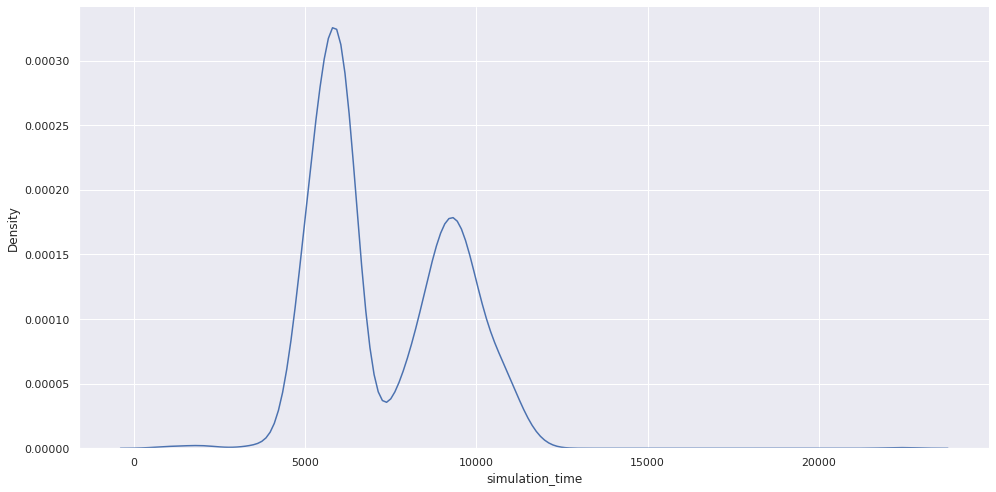

In [ ]:
sns.displot(df_qw_filter[gspace_name], x='simulation_time', kind="kde", palette="Reds", height=7, aspect=2)

In [ ]:
df_qw_filter[gspace_name]['simulation_time'].describe()

count     1637.000000
mean      7320.257113
std       2003.637004
min        984.104305
25%       5712.954999
50%       6296.067831
75%       9208.464844
max      22396.071186
Name: simulation_time, dtype: float64

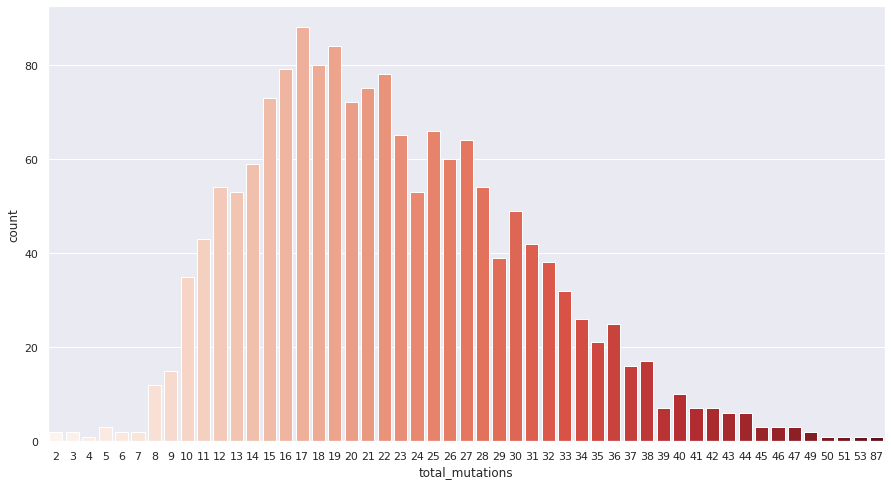

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x="total_mutations", data=df_qw_filter[gspace_name], palette="Reds")

In [ ]:
df_qw_filter[gspace_name]['total_mutations'].describe()

count    1637.000000
mean       22.340867
std         8.360161
min         2.000000
25%        16.000000
50%        21.000000
75%        28.000000
max        87.000000
Name: total_mutations, dtype: float64

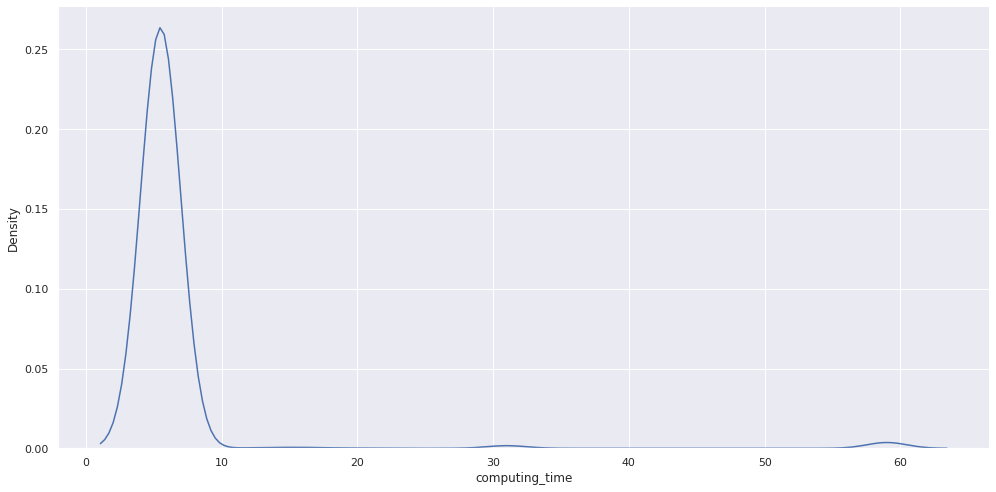

In [ ]:
sns.displot(df_qw_filter[gspace_name], x='computing_time', kind="kde", palette="Reds", height=7, aspect=2)

In [ ]:
df_qw_filter[gspace_name]['computing_time'].describe()

count    1637.000000
mean        6.419066
std         6.488997
min         5.500000
25%         5.500003
50%         5.500005
75%         5.500008
max        59.000139
Name: computing_time, dtype: float64

In [ ]:
df_qw_filter[gspace_name]['coverage_rate'] = df_qw_filter[gspace_name]['total_mutations']/(df_qw_filter[gspace_name]['simulation_time']*3600) # mutations/second

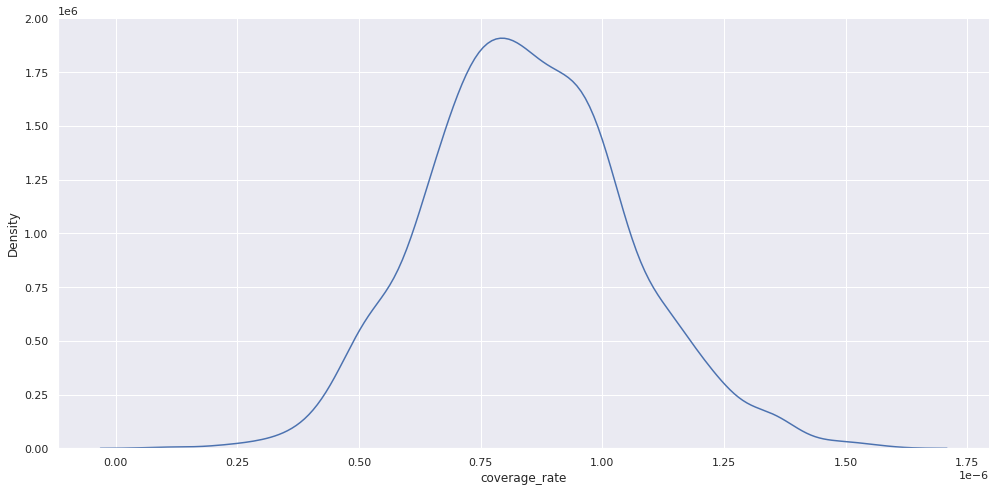

In [ ]:
sns.displot(x='coverage_rate', data=df_qw_filter[gspace_name], kind="kde", palette="Reds", height=7, aspect=2)

In [ ]:
df_qw_filter[gspace_name]['coverage_rate'].describe()

count    1.637000e+03
mean     8.448742e-07
std      2.064432e-07
min      1.092055e-07
25%      7.086609e-07
50%      8.360602e-07
75%      9.774234e-07
max      1.567270e-06
Name: coverage_rate, dtype: float64

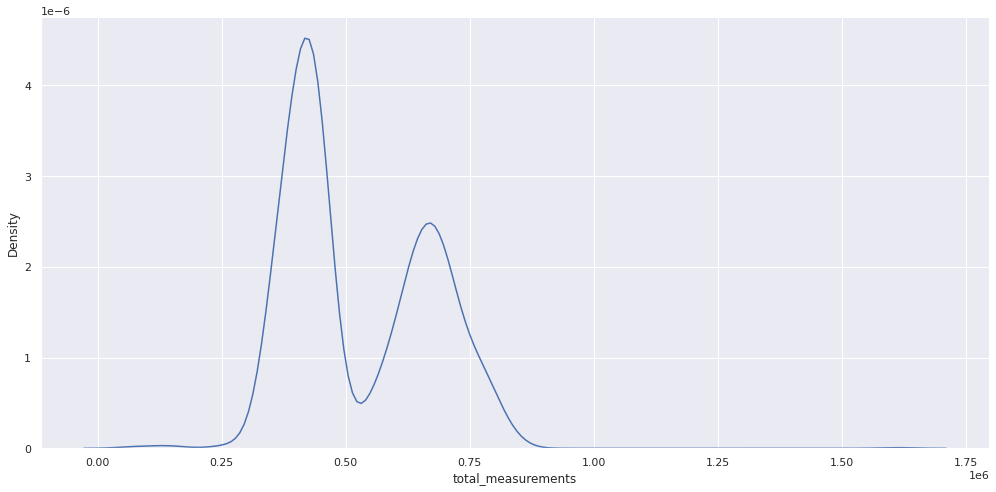

In [ ]:
sns.displot(x='total_measurements', data=df_qw_filter[gspace_name], kind="kde", palette="Reds", height=7, aspect=2)

In [ ]:
df_qw_filter[gspace_name]['total_measurements'].describe()

count    1.637000e+03
mean     5.270494e+05
std      1.442555e+05
min      7.088200e+04
25%      4.111040e+05
50%      4.530570e+05
75%      6.624860e+05
max      1.611519e+06
Name: total_measurements, dtype: float64

In [ ]:
times_hitted_phen = {}
for step in distance[gspace_name][initial_node[gspace_name]].keys():
  total = len(distance[gspace_name][initial_node[gspace_name]][step])
  if total == 0:
    continue

  print(f"Total number of phenotypes at {step} mutational step(s):", total)
  hitted_phens = 0
  hitted_phens_50 = 0

  for phen in distance[gspace_name][initial_node[gspace_name]][step]:
    times_hitted_phen[phen] = df_qw_filter[gspace_name][df_qw_filter[gspace_name][f"mutations_{phen}"] != -1].shape[0] # number of simulations that hitted current phenotype
    
    if times_hitted_phen[phen] > 0:
      hitted_phens += 1
    if times_hitted_phen[phen]/total >= 0.5:
      hitted_phens_50 += 1
  
  print("Number of phenotypes \n... that were hitted at least once:", hitted_phens,"/",total,)
  print("... that were hitted more than 50% of the simulations:", hitted_phens_50,"/",total, "\n")

Total number of phenotypes at 0 mutational step(s): 1
Number of phenotypes 
... that were hitted at least once: 1 / 1
... that were hitted more than 50% of the simulations: 1 / 1 

Total number of phenotypes at 1 mutational step(s): 28
Number of phenotypes 
... that were hitted at least once: 28 / 28
... that were hitted more than 50% of the simulations: 28 / 28 

Total number of phenotypes at 2 mutational step(s): 77
Number of phenotypes 
... that were hitted at least once: 77 / 77
... that were hitted more than 50% of the simulations: 77 / 77 

Total number of phenotypes at 3 mutational step(s): 58
Number of phenotypes 
... that were hitted at least once: 58 / 58
... that were hitted more than 50% of the simulations: 56 / 58 

Total number of phenotypes at 4 mutational step(s): 40
Number of phenotypes 
... that were hitted at least once: 40 / 40
... that were hitted more than 50% of the simulations: 36 / 40 

Total number of phenotypes at 5 mutational step(s): 13
Number of phenotypes

# Getting and processing the classical model data

## Read and process data

### Read Cloudant data

A portion of random walks data was written in Cloudant

In [ ]:
df_cw = {}
all_columns_cw = {}

In [ ]:
for i in [1, 2, 3]:
  gspace_name = names[i]
  cw_file = open("/content/drive/My Drive/Thesis/Code/newData/"+gspace_name+"-cw.json", "r")
  cw_data = json.load(cw_file)
  cw_file.close()

  print("Genotype space:", gspace_name)
  print("Keys:", cw_data.keys())
  print("Number of data:", cw_data['total_rows'])

  all_columns_cw[gspace_name] = list(cw_data['rows'][0]['doc'].keys()) # columns of dataframe

  data_cw = {}
  for key in all_columns_cw[gspace_name]:
    data_cw[key] = []

  for i in range(cw_data['total_rows']):
    for key in all_columns_cw[gspace_name]:
      try:
        data_cw[key].append(cw_data['rows'][i]['doc'][key])
      except:
        data_cw[key].append("N/A")
        print(f"{key} is not in doc {i}")
  
  df_cw[gspace_name] = pd.DataFrame(data_cw)

Genotype space: musculus
Keys: dict_keys(['total_rows', 'offset', 'rows'])
Number of data: 3424
simulation_time is not in doc 379
date is not in doc 379
simulation_time is not in doc 380
date is not in doc 380
simulation_time is not in doc 1135
date is not in doc 1135
simulation_time is not in doc 1318
date is not in doc 1318
simulation_time is not in doc 1319
date is not in doc 1319
simulation_time is not in doc 1320
date is not in doc 1320
simulation_time is not in doc 1321
date is not in doc 1321
simulation_time is not in doc 1322
date is not in doc 1322
simulation_time is not in doc 1323
date is not in doc 1323
simulation_time is not in doc 1849
date is not in doc 1849
Genotype space: neurospora
Keys: dict_keys(['total_rows', 'offset', 'rows'])
Number of data: 3702
simulation_time is not in doc 1890
date is not in doc 1890
Genotype space: arabidopsis
Keys: dict_keys(['total_rows', 'offset', 'rows'])
Number of data: 21
simulation_time is not in doc 12
date is not in doc 12
simulatio

Cleaning data

In [ ]:
for i in [1,2,3]:
  gspace_name = names[i]
  df_cw[gspace_name] = df_cw[gspace_name][df_cw[gspace_name]['date'] != 'N/A']
  df_cw[gspace_name]['date'] = pd.to_datetime(df_cw[gspace_name]['date'], dayfirst=True)
  df_cw[gspace_name] = df_cw[gspace_name].rename(columns={"date": "datetime"})
  df_cw[gspace_name]['simulation_time'] = df_cw[gspace_name]['simulation_time']/3600

In [ ]:
df_cw[names[1]]

,_id,_rev,initial_gen_index,initial_gen,initial_phen,transition_rate,max_simulation_time,total_mutations,computing_time,simulation_time,datetime,tau_Bhlhe40,mutations_Bhlhe40,tau_Sfpi1,mutations_Sfpi1,tau_Zic1,mutations_Zic1,tau_Usf2,mutations_Usf2,tau_Srebf1,mutations_Srebf1,tau_Bcl6b,mutations_Bcl6b,tau_E2F3,mutations_E2F3,tau_Klf7,mutations_Klf7,tau_Mitf,mutations_Mitf,tau_Zfp105,mutations_Zfp105,tau_Cebpb,mutations_Cebpb,tau_Gabpa,mutations_Gabpa,tau_Srebf2,mutations_Srebf2,tau_Zic3,mutations_Zic3,tau_Zscan4,...,tau_E2F2,mutations_E2F2,tau_Irf7,mutations_Irf7,tau_Lef1,mutations_Lef1,tau_Mybl1,mutations_Mybl1,tau_Clock,mutations_Clock,tau_Hes5,mutations_Hes5,tau_Tcfec,mutations_Tcfec,tau_Mlxip,mutations_Mlxip,tau_Mtf1,mutations_Mtf1,tau_Zfp410,mutations_Zfp410,tau_Myf6,mutations_Myf6,tau_Hnf4a,mutations_Hnf4a,tau_Tcf1,mutations_Tcf1,tau_Sox15,mutations_Sox15,tau_Tcf4,mutations_Tcf4,tau_Isgf3g,mutations_Isgf3g,tau_Npas2,mutations_Npas2,tau_Foxj1,mutations_Foxj1,tau_Msc,mutations_Msc,tau_Egr1,mutations_Egr1
0,0a6e16ce3c81f237b52c15e4594b0b84,1-7965dd180eecd6afafc5b25c98411012,6201,AGAAAATG,Mafk,2.000000e-08,30000000.0,15,9.536605,10393.2,2021-12-02 17:04:59,3.741535e+07,-1,3.741535e+07,-1,3.741535e+07,-1,3.741535e+07,-1,3.741535e+07,-1,3.741535e+07,-1,3.741535e+07,-1,3.741535e+07,-1,3.741535e+07,-1,3.741535e+07,-1,3.741535e+07,-1,3.741535e+07,-1,3.741535e+07,-1,3.741535e+07,-1,3.741535e+07,...,3.741535e+07,-1,3.741535e+07,-1,3.741535e+07,-1,6.273740e+06,2,3.741535e+07,-1,3.741535e+07,-1,3.741535e+07,-1,3.741535e+07,-1,3.741535e+07,-1,3.741535e+07,-1,3.741535e+07,-1,3.741535e+07,-1,1.192798e+07,4,3.741535e+07,-1,3.741535e+07,-1,1.810678e+07,6,3.741535e+07,-1,3.741535e+07,-1,3.741535e+07,-1,3.741535e+07,-1
1,0a6e16ce3c81f237b52c15e4594b189a,1-b2b84eca8e84c647876c241a3c164ed2,6201,AGAAAATG,Mafk,2.000000e-08,30000000.0,14,9.037888,9631.48,2021-12-02 17:05:19,3.467332e+07,-1,3.467332e+07,-1,3.467332e+07,-1,3.467332e+07,-1,3.467332e+07,-1,3.467332e+07,-1,3.467332e+07,-1,3.467332e+07,-1,3.467332e+07,-1,2.580696e+07,11,3.467332e+07,-1,3.467332e+07,-1,3.467332e+07,-1,3.467332e+07,-1,3.467332e+07,...,3.467332e+07,-1,3.467332e+07,-1,3.467332e+07,-1,3.467332e+07,-1,3.467332e+07,-1,3.467332e+07,-1,3.467332e+07,-1,3.467332e+07,-1,3.467332e+07,-1,3.467332e+07,-1,3.467332e+07,-1,3.467332e+07,-1,1.217236e+07,7,2.580696e+07,11,3.467332e+07,-1,1.217236e+07,7,3.467332e+07,-1,1.217236e+07,7,3.467332e+07,-1,3.467332e+07,-1
2,0a6e16ce3c81f237b52c15e4594b3f9c,1-80dc32d742567c4f1f60dcad473b73ea,6201,AGAAAATG,Mafk,2.000000e-08,30000000.0,17,11.043589,9712.69,2021-12-02 17:09:23,3.496569e+07,-1,4.451003e+06,3,3.496569e+07,-1,3.496569e+07,-1,3.496569e+07,-1,3.496569e+07,-1,3.496569e+07,-1,3.496569e+07,-1,3.496569e+07,-1,3.496569e+07,-1,3.496569e+07,-1,3.496569e+07,-1,3.496569e+07,-1,3.496569e+07,-1,3.496569e+07,...,3.496569e+07,-1,3.496569e+07,-1,3.496569e+07,-1,3.496569e+07,-1,3.496569e+07,-1,3.496569e+07,-1,3.496569e+07,-1,3.496569e+07,-1,3.496569e+07,-1,3.496569e+07,-1,3.496569e+07,-1,3.496569e+07,-1,1.142569e+07,11,6.014517e+06,6,3.496569e+07,-1,3.496569e+07,-1,3.496569e+07,-1,3.496569e+07,-1,3.496569e+07,-1,3.496569e+07,-1
3,0a6e16ce3c81f237b52c15e4594b4d3c,1-581751d3079e8a41dfec58291fa68133,6201,AGAAAATG,Mafk,2.000000e-08,30000000.0,15,9.898570,9616.66,2021-12-02 17:09:34,3.461996e+07,-1,2.487468e+07,12,3.461996e+07,-1,3.461996e+07,-1,3.461996e+07,-1,3.461996e+07,-1,3.461996e+07,-1,3.461996e+07,-1,3.461996e+07,-1,3.461996e+07,-1,3.461996e+07,-1,3.461996e+07,-1,3.461996e+07,-1,3.461996e+07,-1,3.461996e+07,...,3.461996e+07,-1,5.869827e+06,3,3.461996e+07,-1,3.461996e+07,-1,3.461996e+07,-1,3.461996e+07,-1,3.461996e+07,-1,3.461996e+07,-1,3.461996e+07,-1,3.461996e+07,-1,3.461996e+07,-1,3.461996e+07,-1,3.461996e+07,-1,3.461996e+07,-1,3.461996e+07,-1,4.582513e+06,2,3.461996e+07,-1,3.461996e+07,-1,3.461996e+07,-1,3.461996e+07,-1
4,132a344d12376fd3c60c85a2fcc10917,1-86d13ce92c6a363b0be4eec78c4a087b,6201,AGAAAATG,Mafk,2.000000e-08,20000000.0,10,16.957559,586

In [ ]:
df_cw[names[2]]

,_id,_rev,initial_gen_index,initial_gen,initial_phen,transition_rate,max_simulation_time,total_mutations,computing_time,simulation_time,datetime,tau_NCU05308,mutations_NCU05308,tau_vad-5,mutations_vad-5,tau_NCU06907,mutations_NCU06907,tau_NCU02173,mutations_NCU02173,tau_NCU08159,mutations_NCU08159,tau_NCU01243,mutations_NCU01243,tau_NCU06971,mutations_NCU06971,tau_NCU01386,mutations_NCU01386,tau_NCU05022,mutations_NCU05022,tau_NCU06487,mutations_NCU06487,tau_NCU02819,mutations_NCU02819,tau_NCU04663,mutations_NCU04663,tau_NCU05411,mutations_NCU05411,tau_NCU02752,mutations_NCU02752,tau_NCU00223,...,tau_NCU06707,mutations_NCU06707,tau_NCU03266,mutations_NCU03266,tau_NCU02576,mutations_NCU02576,tau_vad-3,mutations_vad-3,tau_NCU06503,mutations_NCU06503,tau_NCU00392,mutations_NCU00392,tau_NCU00090,mutations_NCU00090,tau_NCU03110,mutations_NCU03110,tau_NCU01924,mutations_NCU01924,tau_NCU00155,mutations_NCU00155,tau_NCU05285,mutations_NCU05285,tau_NCU07587,mutations_NCU07587,tau_NCU02787,mutations_NCU02787,tau_NCU04848,mutations_NCU04848,tau_NCU01122,mutations_NCU01122,tau_NCU05024,mutations_NCU05024,tau_NCU05242,mutations_NCU05242,tau_NCU08744,mutations_NCU08744,tau_NCU07392,mutations_NCU07392,tau_NCU05635,mutations_NCU05635
0,0194418384f69ce81a3aefca8f027ee2,1-760e7874a22a29966a2c5025880c2eae,6201,TAATCAGA,nit-2,2.000000e-08,30000000.0,9,8.425501,9498.35,2021-12-06 23:16:45,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,...,3.419407e+07,-1,3.196303e+06,3,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.196303e+06,3
1,0194418384f69ce81a3aefca8f03247e,1-830cc9360d221cfbee4d38d7096c2d93,6201,TAATCAGA,nit-2,2.000000e-08,30000000.0,13,11.732126,9059.82,2021-12-06 23:25:42,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,2.885894e+07,12,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,...,3.261535e+07,-1,4.065852e+06,1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,4.065852e+06,1
2,0194418384f69ce81a3aefca8f033fe1,1-bb9a8163b4af14501aa34a0e365e4952,6201,TAATCAGA,nit-2,2.000000e-08,30000000.0,14,12.559369,9623.81,2021-12-06 23:26:16,2.736225e+07,11,1.145440e+07,3,1.952554e+07,6,2.736225e+07,11,3.464570e+07,-1,3.464570e+07,-1,2.765403e+07,12,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,...,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,-1,1.145440e+07,3,3.464570e+07,-1,3.464570e+07,-1,2.736225e+07,11,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,-1
3,0194418384f69ce81a3aefca8f034217,1-0822239ae05cf1380b390009d264a41e,6201,TAATCAGA,nit-2,2.000000e-08,30000000.0,9,8.450407,8738.53,2021-12-06 23:26:55,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,4.523685e+06,...,3.145869e+07,-1,4.523685e+06,2,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.1458

In [ ]:
df_cw[names[3]]

,_id,_rev,initial_gen_index,initial_gen,initial_phen,transition_rate,max_simulation_time,total_mutations,computing_time,simulation_time,datetime,tau_GATA15,mutations_GATA15,tau_EDT1,mutations_EDT1,tau_WRKY15,mutations_WRKY15,tau_PIL5,mutations_PIL5,tau_UNE10,mutations_UNE10,tau_TRFL5,mutations_TRFL5,tau_AT1G01260,mutations_AT1G01260,tau_CRF3,mutations_CRF3,tau_Rap2.6L,mutations_Rap2.6L,tau_ATMYB4,mutations_ATMYB4,tau_ATHB7,mutations_ATHB7,tau_WRKY8,mutations_WRKY8,tau_ATGRP2B,mutations_ATGRP2B,tau_SPL1R2,mutations_SPL1R2,tau_E2FE,...,tau_AT3G23230,mutations_AT3G23230,tau_ZFP5,mutations_ZFP5,tau_EPR1,mutations_EPR1,tau_LBD4,mutations_LBD4,tau_ATHB-12,mutations_ATHB-12,tau_ATHB6,mutations_ATHB6,tau_TGA1,mutations_TGA1,tau_BZIP17,mutations_BZIP17,tau_AT4G00238,mutations_AT4G00238,tau_WRKY48,mutations_WRKY48,tau_AT5G64220,mutations_AT5G64220,tau_RBE,mutations_RBE,tau_TCP3,mutations_TCP3,tau_NST1,mutations_NST1,tau_ATWRKY17,mutations_ATWRKY17,tau_SPL5,mutations_SPL5,tau_AT5G46760,mutations_AT5G46760,tau_WRKY23,mutations_WRKY23,tau_bHLH34,mutations_bHLH34,tau_AT5G05090,mutations_AT5G05090
0,15db04f5b0e9051f3d7cf6bfbaa1207a,1-2879ad8ae38698ed00efa59e020bf0b5,9332,ATTTCTAA,SOL1,2.000000e-08,20000000.0,9,104.159764,5703.15,2021-10-07 15:27:33,1.135011e+07,4,2.053132e+07,-1,2.053132e+07,-1,2.053132e+07,-1,2.053132e+07,-1,2.053132e+07,-1,2.053132e+07,-1,2.053132e+07,-1,2.053132e+07,-1,2.053132e+07,-1,2.053132e+07,-1,2.053132e+07,-1,4.503074e+06,2,2.053132e+07,-1,2.053132e+07,...,2.053132e+07,-1,2.053132e+07,-1,2.053132e+07,-1,2.053132e+07,-1,2.053132e+07,-1,2.053132e+07,-1,2.053132e+07,-1,2.053132e+07,-1,2.053132e+07,-1,2.053132e+07,-1,2.053132e+07,-1,2.053132e+07,-1,2.053132e+07,-1,2.053132e+07,-1,2.053132e+07,-1,2.053132e+07,-1,2.053132e+07,-1,2.053132e+07,-1,2.053132e+07,-1,1.508785e+07,6
1,15db04f5b0e9051f3d7cf6bfbaa125d8,1-393414d6a45b361c596f49af9517ab36,9332,ATTTCTAA,SOL1,2.000000e-08,20000000.0,11,126.999333,6222.56,2021-10-07 15:27:30,2.240122e+07,-1,2.240122e+07,-1,2.240122e+07,-1,2.240122e+07,-1,2.240122e+07,-1,2.240122e+07,-1,2.240122e+07,-1,2.240122e+07,-1,2.240122e+07,-1,4.280194e+06,3,2.240122e+07,-1,2.240122e+07,-1,2.240122e+07,-1,4.771918e+06,4,2.240122e+07,...,2.240122e+07,-1,2.240122e+07,-1,2.240122e+07,-1,2.240122e+07,-1,2.240122e+07,-1,2.240122e+07,-1,2.240122e+07,-1,2.240122e+07,-1,2.240122e+07,-1,2.240122e+07,-1,2.240122e+07,-1,9.821388e+05,2,2.240122e+07,-1,2.240122e+07,-1,2.240122e+07,-1,9.821388e+05,2,2.240122e+07,-1,2.240122e+07,-1,2.240122e+07,-1,2.240122e+07,-1
2,21faf1830ffd0b7ea1ac5ba890a0787c,1-7461a4d53b55e97892b0dcfac5505019,9332,ATTTCTAA,SOL1,2.000000e-08,20000000.0,7,88.080428,6295.09,2021-10-07 15:27:36,2.266233e+07,-1,2.266233e+07,-1,2.266233e+07,-1,2.266233e+07,-1,2.266233e+07,-1,2.266233e+07,-1,2.266233e+07,-1,2.266233e+07,-1,2.266233e+07,-1,2.266233e+07,-1,2.266233e+07,-1,2.266233e+07,-1,2.266233e+07,-1,2.266233e+07,-1,2.266233e+07,...,2.266233e+07,-1,5.762739e+05,2,2.266233e+07,-1,2.266233e+07,-1,2.266233e+07,-1,2.266233e+07,-1,2.266233e+07,-1,2.266233e+07,-1,2.266233e+07,-1,2.266233e+07,-1,2.266233e+07,-1,2.266233e+07,-1,2.266233e+07,-1,2.266233e+07,-1,2.266233e+07,-1,2.266233e+07,-1,2.266233e+07,-1,2.266233e+07,-1,2.266233e+07,-1,2.266233e+07,-1
3,2eb36e128df6cb6ac5516978cecddfa2,1-084f599ea948ed832bf25ca1521970a3,9332,ATTTCTAA,SOL1,1.000000e-08,100000000.0,18,178.019837,28134.4,2021-09-23 22:48:58,1.012840e+08,-1,8.293589e+06,1,1.012840e+08,-1,1.012840e+08,-1,1.012840e+08,-1,1.012840e+08,-1,1.012840e+08,-1,1.012840e+08,-1,1.012840e+08,-1,1.012840e+08,-1,1.012840e+08,-1,1.012840e+08,-1,1.012840e+08,-1,1.012840e+08,-1,1.012840e+08,...,1.012840e+08,-1,1.012840e+08,-1,1.272776e+07,4,1.012840e+08,-1,1.012840e+08,-1,1.020850e+07,3,1.012840e+08,-1,1.012840e+08,-1,1.012840e+08,-1,1.012840e+08,-1,1.012840e+08,-1,1.012840e+08,-1,1.012840e+08,-1,1.012840e+08,-1,1.012840e+08,-1,1.012840e+08,-1,8.293589e+06,1,1.012840e+08,-1,1.012840e+08,-1,1.012840e+08,-1
4,34a366818b6de698d03bface68a1c2d7,1-2d58232e3d745

### Read Local data

Mus musculus

In [ ]:
gspace_name = names[1]

In [ ]:
df_cw2 = pd.read_csv("/content/drive/My Drive/Thesis/Code/newData/"+gspace_name+"-cw.csv")
df_cw2 = df_cw2.drop(columns=["Unnamed: 0"])
df_cw2 = df_cw2.rename(columns={"date": "datetime"})
df_cw2['simulation_time'] = df_cw2['simulation_time']/3600

In [ ]:
df_cw2['computing_time'].describe()

count    2149.000000
mean       16.113771
std       128.094516
min         3.204977
25%         8.841158
50%        11.465952
75%        15.186077
max      5661.639189
Name: computing_time, dtype: float64

In [ ]:
df_cw[gspace_name] = pd.concat([df_cw[gspace_name], df_cw2], ignore_index=True)

In [ ]:
df_cw[gspace_name]

,_id,_rev,initial_gen_index,initial_gen,initial_phen,transition_rate,max_simulation_time,total_mutations,computing_time,simulation_time,datetime,tau_Bhlhe40,mutations_Bhlhe40,tau_Sfpi1,mutations_Sfpi1,tau_Zic1,mutations_Zic1,tau_Usf2,mutations_Usf2,tau_Srebf1,mutations_Srebf1,tau_Bcl6b,mutations_Bcl6b,tau_E2F3,mutations_E2F3,tau_Klf7,mutations_Klf7,tau_Mitf,mutations_Mitf,tau_Zfp105,mutations_Zfp105,tau_Cebpb,mutations_Cebpb,tau_Gabpa,mutations_Gabpa,tau_Srebf2,mutations_Srebf2,tau_Zic3,mutations_Zic3,tau_Zscan4,...,tau_E2F2,mutations_E2F2,tau_Irf7,mutations_Irf7,tau_Lef1,mutations_Lef1,tau_Mybl1,mutations_Mybl1,tau_Clock,mutations_Clock,tau_Hes5,mutations_Hes5,tau_Tcfec,mutations_Tcfec,tau_Mlxip,mutations_Mlxip,tau_Mtf1,mutations_Mtf1,tau_Zfp410,mutations_Zfp410,tau_Myf6,mutations_Myf6,tau_Hnf4a,mutations_Hnf4a,tau_Tcf1,mutations_Tcf1,tau_Sox15,mutations_Sox15,tau_Tcf4,mutations_Tcf4,tau_Isgf3g,mutations_Isgf3g,tau_Npas2,mutations_Npas2,tau_Foxj1,mutations_Foxj1,tau_Msc,mutations_Msc,tau_Egr1,mutations_Egr1
0,0a6e16ce3c81f237b52c15e4594b0b84,1-7965dd180eecd6afafc5b25c98411012,6201.0,AGAAAATG,Mafk,2.000000e-08,30000000.0,15.0,9.536605,10393.2,2021-12-02 17:04:59,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,...,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,6.273740e+06,2.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,1.192798e+07,4.0,3.741535e+07,-1.0,3.741535e+07,-1.0,1.810678e+07,6.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0
1,0a6e16ce3c81f237b52c15e4594b189a,1-b2b84eca8e84c647876c241a3c164ed2,6201.0,AGAAAATG,Mafk,2.000000e-08,30000000.0,14.0,9.037888,9631.48,2021-12-02 17:05:19,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,2.580696e+07,11.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,...,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,1.217236e+07,7.0,2.580696e+07,11.0,3.467332e+07,-1.0,1.217236e+07,7.0,3.467332e+07,-1.0,1.217236e+07,7.0,3.467332e+07,-1.0,3.467332e+07,-1.0
2,0a6e16ce3c81f237b52c15e4594b3f9c,1-80dc32d742567c4f1f60dcad473b73ea,6201.0,AGAAAATG,Mafk,2.000000e-08,30000000.0,17.0,11.043589,9712.69,2021-12-02 17:09:23,3.496569e+07,-1.0,4.451003e+06,3.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,...,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,1.142569e+07,11.0,6.014517e+06,6.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0
3,0a6e16ce3c81f237b52c15e4594b4d3c,1-581751d3079e8a41dfec58291fa68133,6201.0,AGAAAATG,Mafk,2.000000e-08,30000000.0,15.0,9.898570,9616.66,2021-12-02 17:09:34,3.461996e+07,-1.0,2.487468e+07,12.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,...,3.461996e+07,-1.0,5.869827e+06,3.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.

Arabidopsis thaliana

In [ ]:
gspace_name = names[3]

In [ ]:
df_cw2 = pd.read_csv("/content/drive/My Drive/Thesis/Code/newData/"+gspace_name+"-cw.csv")
df_cw2 = df_cw2.rename(columns={"date": "datetime"})
df_cw2['simulation_time'] = df_cw2['simulation_time']/3600

In [ ]:
df_cw2['computing_time'].describe()

count    100.000000
mean      10.302487
std        2.668994
min        5.494477
25%        8.585401
50%        9.737798
75%       12.235256
max       20.470908
Name: computing_time, dtype: float64

In [ ]:
df_cw[gspace_name] = pd.concat([df_cw[gspace_name], df_cw2], ignore_index=True)

In [ ]:
df_cw[gspace_name]

,_id,_rev,initial_gen_index,initial_gen,initial_phen,transition_rate,max_simulation_time,total_mutations,computing_time,simulation_time,datetime,tau_GATA15,mutations_GATA15,tau_EDT1,mutations_EDT1,tau_WRKY15,mutations_WRKY15,tau_PIL5,mutations_PIL5,tau_UNE10,mutations_UNE10,tau_TRFL5,mutations_TRFL5,tau_AT1G01260,mutations_AT1G01260,tau_CRF3,mutations_CRF3,tau_Rap2.6L,mutations_Rap2.6L,tau_ATMYB4,mutations_ATMYB4,tau_ATHB7,mutations_ATHB7,tau_WRKY8,mutations_WRKY8,tau_ATGRP2B,mutations_ATGRP2B,tau_SPL1R2,mutations_SPL1R2,tau_E2FE,...,tau_AT3G23230,mutations_AT3G23230,tau_ZFP5,mutations_ZFP5,tau_EPR1,mutations_EPR1,tau_LBD4,mutations_LBD4,tau_ATHB-12,mutations_ATHB-12,tau_ATHB6,mutations_ATHB6,tau_TGA1,mutations_TGA1,tau_BZIP17,mutations_BZIP17,tau_AT4G00238,mutations_AT4G00238,tau_WRKY48,mutations_WRKY48,tau_AT5G64220,mutations_AT5G64220,tau_RBE,mutations_RBE,tau_TCP3,mutations_TCP3,tau_NST1,mutations_NST1,tau_ATWRKY17,mutations_ATWRKY17,tau_SPL5,mutations_SPL5,tau_AT5G46760,mutations_AT5G46760,tau_WRKY23,mutations_WRKY23,tau_bHLH34,mutations_bHLH34,tau_AT5G05090,mutations_AT5G05090
0,15db04f5b0e9051f3d7cf6bfbaa1207a,1-2879ad8ae38698ed00efa59e020bf0b5,9332.0,ATTTCTAA,SOL1,2.000000e-08,20000000.0,9.0,104.159764,5703.15,2021-10-07 15:27:33,1.135011e+07,4.0,2.053132e+07,-1.0,2.053132e+07,-1.0,2.053132e+07,-1.0,2.053132e+07,-1.0,2.053132e+07,-1.0,2.053132e+07,-1.0,2.053132e+07,-1.0,2.053132e+07,-1.0,2.053132e+07,-1.0,2.053132e+07,-1.0,2.053132e+07,-1.0,4.503074e+06,2.0,2.053132e+07,-1.0,2.053132e+07,...,2.053132e+07,-1.0,2.053132e+07,-1.0,2.053132e+07,-1.0,2.053132e+07,-1.0,2.053132e+07,-1.0,2.053132e+07,-1.0,2.053132e+07,-1.0,2.053132e+07,-1.0,2.053132e+07,-1.0,2.053132e+07,-1.0,2.053132e+07,-1.0,2.053132e+07,-1.0,2.053132e+07,-1.0,2.053132e+07,-1.0,2.053132e+07,-1.0,2.053132e+07,-1.0,2.053132e+07,-1.0,2.053132e+07,-1.0,2.053132e+07,-1.0,1.508785e+07,6.0
1,15db04f5b0e9051f3d7cf6bfbaa125d8,1-393414d6a45b361c596f49af9517ab36,9332.0,ATTTCTAA,SOL1,2.000000e-08,20000000.0,11.0,126.999333,6222.56,2021-10-07 15:27:30,2.240122e+07,-1.0,2.240122e+07,-1.0,2.240122e+07,-1.0,2.240122e+07,-1.0,2.240122e+07,-1.0,2.240122e+07,-1.0,2.240122e+07,-1.0,2.240122e+07,-1.0,2.240122e+07,-1.0,4.280194e+06,3.0,2.240122e+07,-1.0,2.240122e+07,-1.0,2.240122e+07,-1.0,4.771918e+06,4.0,2.240122e+07,...,2.240122e+07,-1.0,2.240122e+07,-1.0,2.240122e+07,-1.0,2.240122e+07,-1.0,2.240122e+07,-1.0,2.240122e+07,-1.0,2.240122e+07,-1.0,2.240122e+07,-1.0,2.240122e+07,-1.0,2.240122e+07,-1.0,2.240122e+07,-1.0,9.821388e+05,2.0,2.240122e+07,-1.0,2.240122e+07,-1.0,2.240122e+07,-1.0,9.821388e+05,2.0,2.240122e+07,-1.0,2.240122e+07,-1.0,2.240122e+07,-1.0,2.240122e+07,-1.0
2,21faf1830ffd0b7ea1ac5ba890a0787c,1-7461a4d53b55e97892b0dcfac5505019,9332.0,ATTTCTAA,SOL1,2.000000e-08,20000000.0,7.0,88.080428,6295.09,2021-10-07 15:27:36,2.266233e+07,-1.0,2.266233e+07,-1.0,2.266233e+07,-1.0,2.266233e+07,-1.0,2.266233e+07,-1.0,2.266233e+07,-1.0,2.266233e+07,-1.0,2.266233e+07,-1.0,2.266233e+07,-1.0,2.266233e+07,-1.0,2.266233e+07,-1.0,2.266233e+07,-1.0,2.266233e+07,-1.0,2.266233e+07,-1.0,2.266233e+07,...,2.266233e+07,-1.0,5.762739e+05,2.0,2.266233e+07,-1.0,2.266233e+07,-1.0,2.266233e+07,-1.0,2.266233e+07,-1.0,2.266233e+07,-1.0,2.266233e+07,-1.0,2.266233e+07,-1.0,2.266233e+07,-1.0,2.266233e+07,-1.0,2.266233e+07,-1.0,2.266233e+07,-1.0,2.266233e+07,-1.0,2.266233e+07,-1.0,2.266233e+07,-1.0,2.266233e+07,-1.0,2.266233e+07,-1.0,2.266233e+07,-1.0,2.266233e+07,-1.0
3,2eb36e128df6cb6ac5516978cecddfa2,1-084f599ea948ed832bf25ca1521970a3,9332.0,ATTTCTAA,SOL1,1.000000e-08,100000000.0,18.0,178.019837,28134.4,2021-09-23 22:48:58,1.012840e+08,-1.0,8.293589e+06,1.0,1.012840e+08,-1.0,1.012840e+08,-1.0,1.012840e+08,-1.0,1.012840e+08,-1.0,1.012840e+08,-1.0,1.012840e+08,-1.0,1.012840e+08,-1.0,1.012840e+08,-1.0,1.012840e+08,-1.0,1.012840e+08,-1.0,1.012840e+08,-1.0,1.012840e+08,-1.0,1.012840e+08,...,1.012840e+08,-1.0,1.012840e+08,-1.0,1.272776e+07,4.0,1.012840e+08,-1.0,1.012840e+08,-1.0,1.020850e+07,3.0,1.012840e+08,

### Process data

Filter data

In [ ]:
max_simulation_time = {1: 3e7, 2: 3e7, 3: 3.8e7}

In [ ]:
df_cw_filter = {}

In [ ]:
no_sense_columns_c = ['_id', '_rev', 'initial_gen_index', 'initial_gen', 'initial_phen', 'transition_rate']

for i in [1,2,3]:
  gspace_name = names[i]
  print("Genotype space", gspace_name)
  columns_cw = [key for key in df_cw[gspace_name].columns if key not in no_sense_columns_c ]

  print("Size of data without filter:", len(df_cw[gspace_name]))

  df_cw_filter[gspace_name] = df_cw[gspace_name][(df_cw[gspace_name]['transition_rate'] == gamma_c) & (df_cw[gspace_name]['max_simulation_time'] == max_simulation_time[i]) 
  & (df_cw[gspace_name]['initial_gen_index'] == int(initial_node[gspace_name]))][columns_cw]

  print("Size of filtered data:", len(df_cw_filter[gspace_name]))
  print("\n")


Genotype space musculus
Size of data without filter: 5563
Size of filtered data: 3000


Genotype space neurospora
Size of data without filter: 3701
Size of filtered data: 3700


Genotype space arabidopsis
Size of data without filter: 119
Size of filtered data: 100




## Mus musculus

In [ ]:
gspace_name = names[1]

In [ ]:
df_cw_filter[gspace_name]

,max_simulation_time,total_mutations,computing_time,simulation_time,datetime,tau_Bhlhe40,mutations_Bhlhe40,tau_Sfpi1,mutations_Sfpi1,tau_Zic1,mutations_Zic1,tau_Usf2,mutations_Usf2,tau_Srebf1,mutations_Srebf1,tau_Bcl6b,mutations_Bcl6b,tau_E2F3,mutations_E2F3,tau_Klf7,mutations_Klf7,tau_Mitf,mutations_Mitf,tau_Zfp105,mutations_Zfp105,tau_Cebpb,mutations_Cebpb,tau_Gabpa,mutations_Gabpa,tau_Srebf2,mutations_Srebf2,tau_Zic3,mutations_Zic3,tau_Zscan4,mutations_Zscan4,tau_Crem,mutations_Crem,tau_Tcfap4,mutations_Tcfap4,tau_Sox21,...,tau_E2F2,mutations_E2F2,tau_Irf7,mutations_Irf7,tau_Lef1,mutations_Lef1,tau_Mybl1,mutations_Mybl1,tau_Clock,mutations_Clock,tau_Hes5,mutations_Hes5,tau_Tcfec,mutations_Tcfec,tau_Mlxip,mutations_Mlxip,tau_Mtf1,mutations_Mtf1,tau_Zfp410,mutations_Zfp410,tau_Myf6,mutations_Myf6,tau_Hnf4a,mutations_Hnf4a,tau_Tcf1,mutations_Tcf1,tau_Sox15,mutations_Sox15,tau_Tcf4,mutations_Tcf4,tau_Isgf3g,mutations_Isgf3g,tau_Npas2,mutations_Npas2,tau_Foxj1,mutations_Foxj1,tau_Msc,mutations_Msc,tau_Egr1,mutations_Egr1
0,30000000.0,15.0,9.536605,10393.2,2021-12-02 17:04:59,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,...,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,6.273740e+06,2.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,1.192798e+07,4.0,3.741535e+07,-1.0,3.741535e+07,-1.0,1.810678e+07,6.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0
1,30000000.0,14.0,9.037888,9631.48,2021-12-02 17:05:19,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,2.580696e+07,11.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,2.580696e+07,...,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,1.217236e+07,7.0,2.580696e+07,11.0,3.467332e+07,-1.0,1.217236e+07,7.0,3.467332e+07,-1.0,1.217236e+07,7.0,3.467332e+07,-1.0,3.467332e+07,-1.0
2,30000000.0,17.0,11.043589,9712.69,2021-12-02 17:09:23,3.496569e+07,-1.0,4.451003e+06,3.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,6.014517e+06,...,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,1.142569e+07,11.0,6.014517e+06,6.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0
3,30000000.0,15.0,9.898570,9616.66,2021-12-02 17:09:34,3.461996e+07,-1.0,2.487468e+07,12.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,...,3.461996e+07,-1.0,5.869827e+06,3.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,4.582513e+06,2.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0
171,30000000.0,12.0,9.

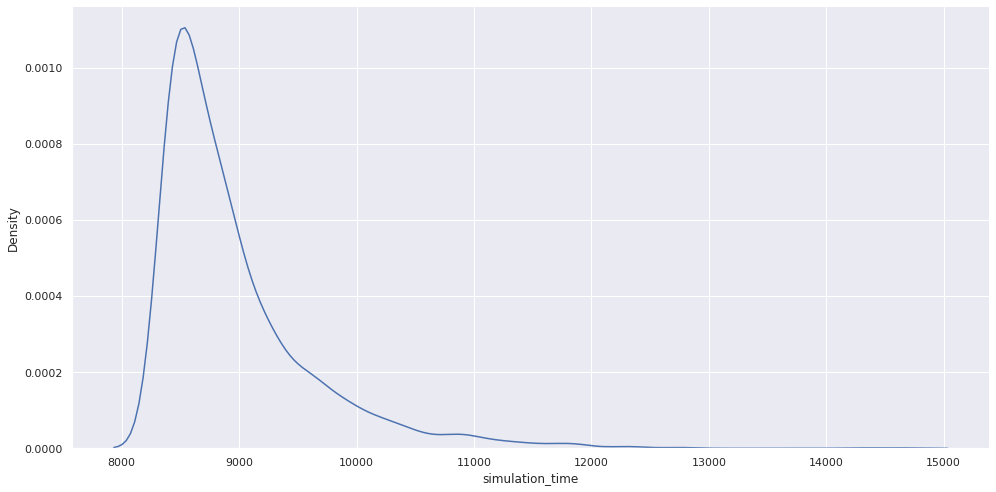

In [ ]:
sns.displot(df_cw_filter[gspace_name], x='simulation_time', kind="kde", palette="Reds", height=7, aspect=2)

In [ ]:
df_cw_filter[gspace_name] = df_cw_filter[gspace_name].astype({"simulation_time": float})
df_cw_filter[gspace_name] = df_cw_filter[gspace_name].astype({"total_mutations": int})

In [ ]:
df_cw_filter[gspace_name]['simulation_time'].describe()

count     3000.000000
mean      8962.821600
std        663.422516
min       8334.098180
25%       8512.856095
50%       8758.249956
75%       9181.056077
max      14631.715465
Name: simulation_time, dtype: float64

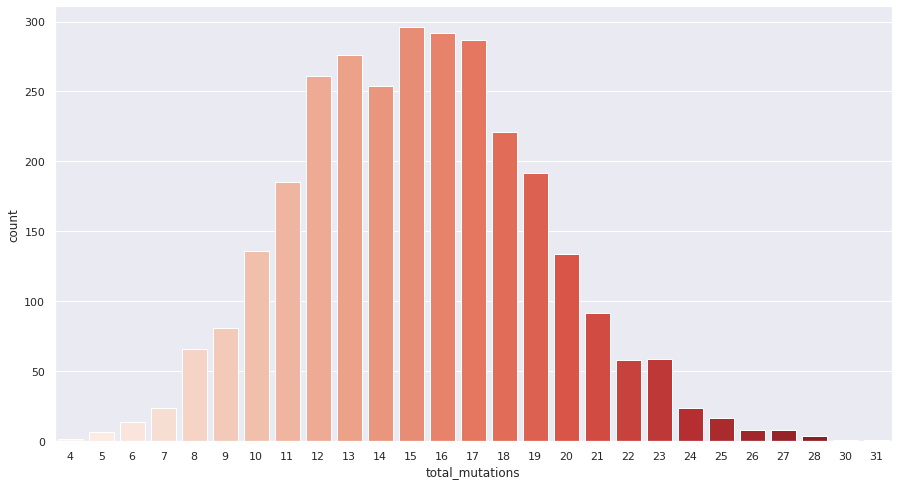

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x="total_mutations", data=df_cw_filter[gspace_name], palette="Reds")

In [ ]:
df_cw_filter[gspace_name]['total_mutations'].describe()

count    3000.000000
mean       15.227667
std         3.932386
min         4.000000
25%        12.000000
50%        15.000000
75%        18.000000
max        31.000000
Name: total_mutations, dtype: float64

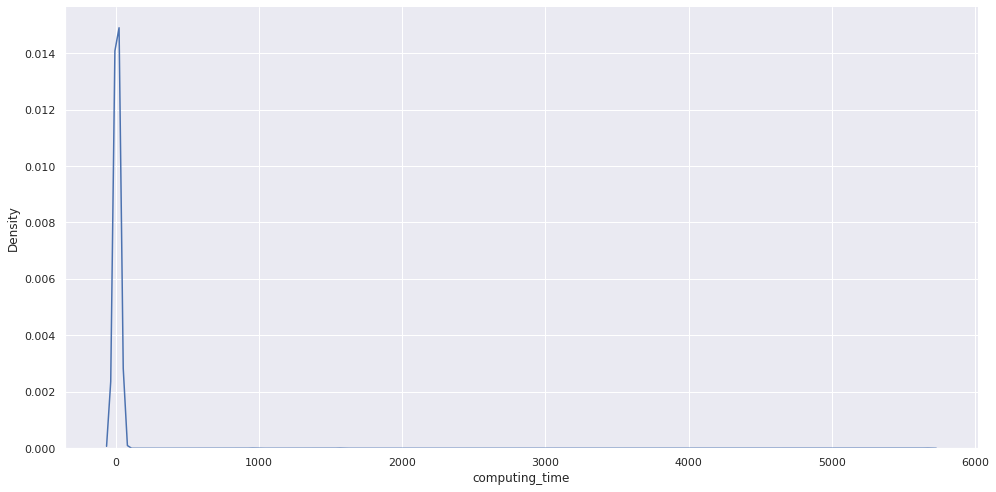

In [ ]:
sns.displot(df_cw_filter[gspace_name], x='computing_time', kind="kde", palette="Reds", height=7, aspect=2)

In [ ]:
df_cw_filter[gspace_name][df_cw_filter[gspace_name]['computing_time'] > 30]

,max_simulation_time,total_mutations,computing_time,simulation_time,datetime,tau_Bhlhe40,mutations_Bhlhe40,tau_Sfpi1,mutations_Sfpi1,tau_Zic1,mutations_Zic1,tau_Usf2,mutations_Usf2,tau_Srebf1,mutations_Srebf1,tau_Bcl6b,mutations_Bcl6b,tau_E2F3,mutations_E2F3,tau_Klf7,mutations_Klf7,tau_Mitf,mutations_Mitf,tau_Zfp105,mutations_Zfp105,tau_Cebpb,mutations_Cebpb,tau_Gabpa,mutations_Gabpa,tau_Srebf2,mutations_Srebf2,tau_Zic3,mutations_Zic3,tau_Zscan4,mutations_Zscan4,tau_Crem,mutations_Crem,tau_Tcfap4,mutations_Tcfap4,tau_Sox21,...,tau_E2F2,mutations_E2F2,tau_Irf7,mutations_Irf7,tau_Lef1,mutations_Lef1,tau_Mybl1,mutations_Mybl1,tau_Clock,mutations_Clock,tau_Hes5,mutations_Hes5,tau_Tcfec,mutations_Tcfec,tau_Mlxip,mutations_Mlxip,tau_Mtf1,mutations_Mtf1,tau_Zfp410,mutations_Zfp410,tau_Myf6,mutations_Myf6,tau_Hnf4a,mutations_Hnf4a,tau_Tcf1,mutations_Tcf1,tau_Sox15,mutations_Sox15,tau_Tcf4,mutations_Tcf4,tau_Isgf3g,mutations_Isgf3g,tau_Npas2,mutations_Npas2,tau_Foxj1,mutations_Foxj1,tau_Msc,mutations_Msc,tau_Egr1,mutations_Egr1
3981,30000000.0,17,5661.639189,8345.204697,01/12/2021 21:04:12,2.257493e+07,12.0,3.004274e+07,-1.0,3.004274e+07,-1.0,3.004274e+07,-1.0,3.004274e+07,-1.0,3.004274e+07,-1.0,3.004274e+07,-1.0,3.004274e+07,-1.0,3.004274e+07,-1.0,3.004274e+07,-1.0,3.004274e+07,-1.0,3.004274e+07,-1.0,3.004274e+07,-1.0,3.004274e+07,-1.0,3.004274e+07,-1.0,3.004274e+07,-1.0,1.680231e+07,8.0,3.004274e+07,...,3.004274e+07,-1.0,3.004274e+07,-1.0,3.004274e+07,-1.0,3.004274e+07,-1.0,3.004274e+07,-1.0,2.257493e+07,12.0,3.004274e+07,-1.0,3.004274e+07,-1.0,3.004274e+07,-1.0,3.004274e+07,-1.0,3.004274e+07,-1.0,3.004274e+07,-1.0,3.004274e+07,-1.0,3.004274e+07,-1.0,3.004274e+07,-1.0,3.004274e+07,-1.0,3.004274e+07,-1.0,5.318782e+06,2.0,3.004274e+07,-1.0,3.004274e+07,-1.0
4282,30000000.0,13,1566.707375,8878.857127,02/12/2021 10:52:39,3.196389e+07,-1.0,3.196389e+07,-1.0,3.196389e+07,-1.0,3.196389e+07,-1.0,3.196389e+07,-1.0,3.196389e+07,-1.0,3.196389e+07,-1.0,3.196389e+07,-1.0,3.196389e+07,-1.0,3.196389e+07,-1.0,3.196389e+07,-1.0,3.196389e+07,-1.0,3.196389e+07,-1.0,3.196389e+07,-1.0,3.196389e+07,-1.0,3.196389e+07,-1.0,3.196389e+07,-1.0,2.765270e+07,...,3.196389e+07,-1.0,3.196389e+07,-1.0,3.196389e+07,-1.0,3.196389e+07,-1.0,3.196389e+07,-1.0,3.196389e+07,-1.0,3.196389e+07,-1.0,3.196389e+07,-1.0,3.196389e+07,-1.0,3.196389e+07,-1.0,3.196389e+07,-1.0,3.196389e+07,-1.0,3.196389e+07,-1.0,3.196389e+07,-1.0,3.196389e+07,-1.0,3.196389e+07,-1.0,3.196389e+07,-1.0,3.196389e+07,-1.0,3.196389e+07,-1.0,3.196389e+07,-1.0
4643,30000000.0,10,37.950693,8415.327364,02/12/2021 12:10:04,3.029518e+07,-1.0,3.029518e+07,-1.0,1.192167e+07,6.0,3.029518e+07,-1.0,3.029518e+07,-1.0,3.029518e+07,-1.0,3.029518e+07,-1.0,3.029518e+07,-1.0,3.029518e+07,-1.0,3.029518e+07,-1.0,3.029518e+07,-1.0,3.029518e+07,-1.0,3.029518e+07,-1.0,1.192167e+07,6.0,3.029518e+07,-1.0,3.029518e+07,-1.0,3.029518e+07,-1.0,3.029518e+07,...,3.029518e+07,-1.0,3.029518e+07,-1.0,3.029518e+07,-1.0,8.123381e+06,4.0,3.029518e+07,-1.0,3.029518e+07,-1.0,3.029518e+07,-1.0,3.029518e+07,-1.0,3.029518e+07,-1.0,3.029518e+07,-1.0,3.029518e+07,-1.0,3.029518e+07,-1.0,3.029518e+07,-1.0,3.029518e+07,-1.0,3.029518e+07,-1.0,3.029518e+07,-1.0,3.029518e+07,-1.0,3.029518e+07,-1.0,3.029518e+07,-1.0,3.029518e+07,-1.0
5311,30000000.0,18,959.821568,8511.444184,06/12/2021 22:48:35,3.064120e+07,-1.0,3.064120e+07,-1.0,3.064120e+07,-1.0,3.064120e+07,-1.0,3.064120e+07,-1.0,3.064120e+07,-1.0,3.064120e+07,-1.0,3.064120e+07,-1.0,3.064120e+07,-1.0,4.943832e+06,2.0,3.064120e+07,-1.0,3.064120e+07,-1.0,3.064120e+07,-1.0,3.064120e+07,-1.0,3.064120e+07,-1.0,3.064120e+07,-1.0,3.064120e+07,-1.0,3.064120e+07,...,3.064120e+07,-1.0,3.064120e+07,-1.0,2.096417e+07,14.0,1.050839e+07,6.0,3.064120e+07,-1.0,3.064120e+07,-1.0,3.064120e+07,-1.0,3.064120e+07,-1.0,3.064120e+07,-1.0,3.064120e+07,-1.0,3.064120e+07,-1.0,3.064120e+07,-1.0,1.204416e+07,7.0,3.064120e+07,-1.0,3.064120e+07,-1.0,8.326433e+06,4.0,3.064120e+07,-1.0,3.064120e+07,-1.0,3.064120e+07,-1.0,3.064120e+0

In [ ]:
df_cw_filter[gspace_name]['computing_time'].describe()

count    3000.000000
mean       14.061258
std       108.434759
min         3.204977
25%         8.802650
50%        10.947219
75%        13.393458
max      5661.639189
Name: computing_time, dtype: float64

In [ ]:
df_cw_filter[gspace_name]['coverage_rate'] = df_cw_filter[gspace_name]['total_mutations']/(df_cw_filter[gspace_name]['simulation_time']*3600) # mutations/second

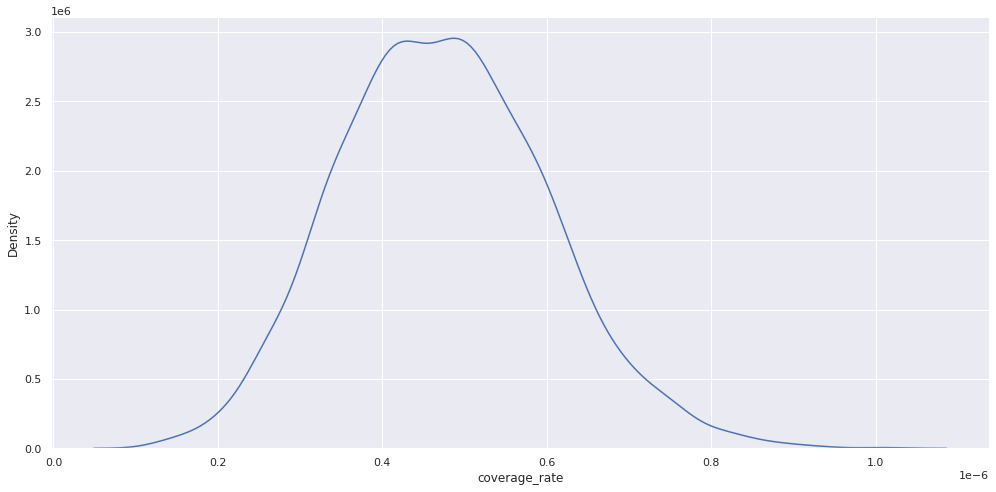

In [ ]:
sns.displot(x='coverage_rate', data=df_cw_filter[gspace_name], kind="kde", palette="Reds", height=7, aspect=2)

In [ ]:
df_cw_filter[gspace_name]['coverage_rate'].describe()

count    3.000000e+03
mean     4.743315e-07
std      1.268126e-07
min      1.256621e-07
25%      3.865850e-07
50%      4.696921e-07
75%      5.586352e-07
max      1.009612e-06
Name: coverage_rate, dtype: float64

In [ ]:
times_hitted_phen_c = {}
for step in distance[gspace_name][initial_node[gspace_name]].keys():
  total = len(distance[gspace_name][initial_node[gspace_name]][step])
  if total == 0:
    continue
  print("Mutational steps:", step)
  print(f"Total number of phenotypes at {step} mutational step(s):", total)
  hitted_phens = 0
  hitted_phens_50 = 0

  for phen in distance[gspace_name][initial_node[gspace_name]][step]:
    times_hitted_phen_c[phen] = df_cw_filter[gspace_name][df_cw_filter[gspace_name][f"mutations_{phen}"] != -1].shape[0] # number of simulations that hitted current phenotype
    
    if times_hitted_phen_c[phen] > 0:
      hitted_phens += 1

    if times_hitted_phen_c[phen]/total >= 0.5:
      hitted_phens_50 += 1
  
  print("Number of phenotypes that \n... were hitted at least once:", hitted_phens, "/", total)
  print("... were hitted more than 50% of the simulations:", hitted_phens_50, "/", total, "\n")

Mutational steps: 0
Total number of phenotypes at 0 mutational step(s): 1
Number of phenotypes that 
... were hitted at least once: 1 / 1
... were hitted more than 50% of the simulations: 1 / 1 

Mutational steps: 1
Total number of phenotypes at 1 mutational step(s): 38
Number of phenotypes that 
... were hitted at least once: 38 / 38
... were hitted more than 50% of the simulations: 38 / 38 

Mutational steps: 2
Total number of phenotypes at 2 mutational step(s): 85
Number of phenotypes that 
... were hitted at least once: 85 / 85
... were hitted more than 50% of the simulations: 84 / 85 

Mutational steps: 3
Total number of phenotypes at 3 mutational step(s): 61
Number of phenotypes that 
... were hitted at least once: 61 / 61
... were hitted more than 50% of the simulations: 59 / 61 

Mutational steps: 4
Total number of phenotypes at 4 mutational step(s): 5
Number of phenotypes that 
... were hitted at least once: 5 / 5
... were hitted more than 50% of the simulations: 5 / 5 



## Neurospora crassa

In [ ]:
gspace_name = names[2]

In [ ]:
df_cw_filter[gspace_name]

,max_simulation_time,total_mutations,computing_time,simulation_time,datetime,tau_NCU05308,mutations_NCU05308,tau_vad-5,mutations_vad-5,tau_NCU06907,mutations_NCU06907,tau_NCU02173,mutations_NCU02173,tau_NCU08159,mutations_NCU08159,tau_NCU01243,mutations_NCU01243,tau_NCU06971,mutations_NCU06971,tau_NCU01386,mutations_NCU01386,tau_NCU05022,mutations_NCU05022,tau_NCU06487,mutations_NCU06487,tau_NCU02819,mutations_NCU02819,tau_NCU04663,mutations_NCU04663,tau_NCU05411,mutations_NCU05411,tau_NCU02752,mutations_NCU02752,tau_NCU00223,mutations_NCU00223,tau_NCU03725,mutations_NCU03725,tau_NCU03552,mutations_NCU03552,tau_NCU02957,...,tau_NCU06707,mutations_NCU06707,tau_NCU03266,mutations_NCU03266,tau_NCU02576,mutations_NCU02576,tau_vad-3,mutations_vad-3,tau_NCU06503,mutations_NCU06503,tau_NCU00392,mutations_NCU00392,tau_NCU00090,mutations_NCU00090,tau_NCU03110,mutations_NCU03110,tau_NCU01924,mutations_NCU01924,tau_NCU00155,mutations_NCU00155,tau_NCU05285,mutations_NCU05285,tau_NCU07587,mutations_NCU07587,tau_NCU02787,mutations_NCU02787,tau_NCU04848,mutations_NCU04848,tau_NCU01122,mutations_NCU01122,tau_NCU05024,mutations_NCU05024,tau_NCU05242,mutations_NCU05242,tau_NCU08744,mutations_NCU08744,tau_NCU07392,mutations_NCU07392,tau_NCU05635,mutations_NCU05635
0,30000000.0,9,8.425501,9498.35,2021-12-06 23:16:45,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,...,3.419407e+07,-1,3.196303e+06,3,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.419407e+07,-1,3.196303e+06,3
1,30000000.0,13,11.732126,9059.82,2021-12-06 23:25:42,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,2.885894e+07,12,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,...,3.261535e+07,-1,4.065852e+06,1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,3.261535e+07,-1,4.065852e+06,1
2,30000000.0,14,12.559369,9623.81,2021-12-06 23:26:16,2.736225e+07,11,1.145440e+07,3,1.952554e+07,6,2.736225e+07,11,3.464570e+07,-1,3.464570e+07,-1,2.765403e+07,12,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,...,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,-1,1.145440e+07,3,3.464570e+07,-1,3.464570e+07,-1,2.736225e+07,11,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,-1,3.464570e+07,-1
3,30000000.0,9,8.450407,8738.53,2021-12-06 23:26:55,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,4.523685e+06,2,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,...,3.145869e+07,-1,4.523685e+06,2,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,3.145869e+07,-1,4.523685e+06,2
4,30000000.0,16,14.332550,8993.24,2021-12-06 23:27:47,2.418290e+07,13,1.118839e+07,7,3.237565e+0

We only consider 3000 simulations

In [ ]:
df_cw_filter[gspace_name] = df_cw_filter[gspace_name].sample(n=3000, random_state=1)

In [ ]:
df_cw_filter[gspace_name] = df_cw_filter[gspace_name].astype({"simulation_time": float})
df_cw_filter[gspace_name] = df_cw_filter[gspace_name].astype({"total_mutations": int})

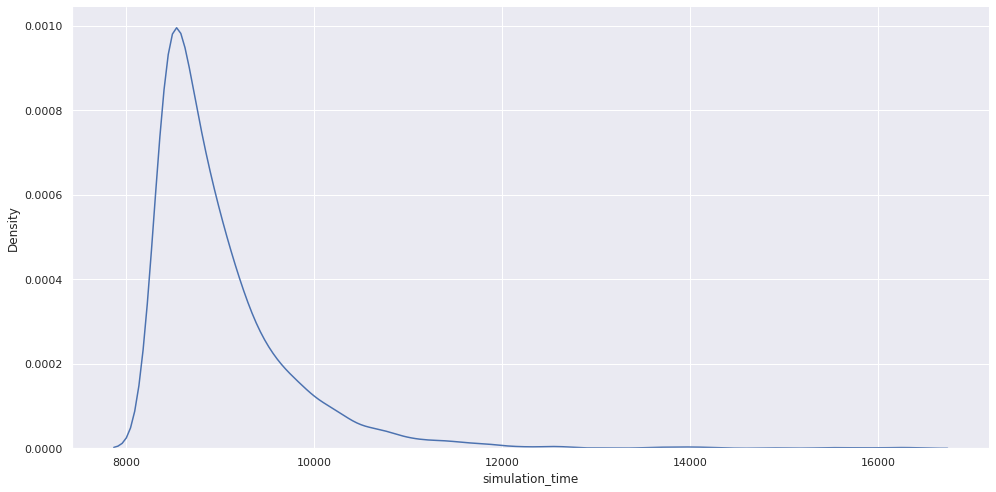

In [ ]:
sns.displot(df_cw_filter[gspace_name], x='simulation_time', kind="kde", palette="Reds", height=7, aspect=2)

In [ ]:
df_cw_filter[gspace_name]['simulation_time'].describe()

count     3000.000000
mean      9011.636851
std        764.579903
min       8333.430994
25%       8518.172121
50%       8786.617060
75%       9239.323562
max      16279.616907
Name: simulation_time, dtype: float64

In [ ]:
df_cw_filter[gspace_name]['total_mutations'].describe()

count    3000.000000
mean       13.831333
std         3.909985
min         3.000000
25%        11.000000
50%        14.000000
75%        16.000000
max        28.000000
Name: total_mutations, dtype: float64

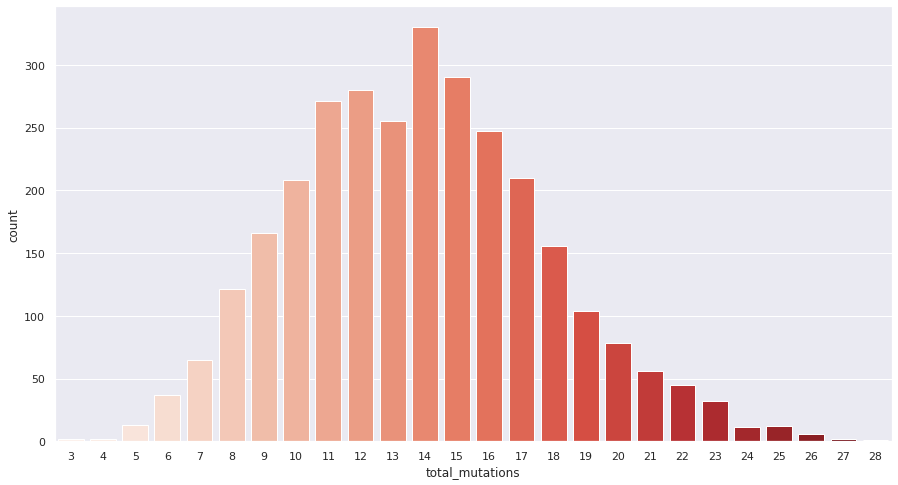

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x="total_mutations", data=df_cw_filter[gspace_name], palette="Reds")

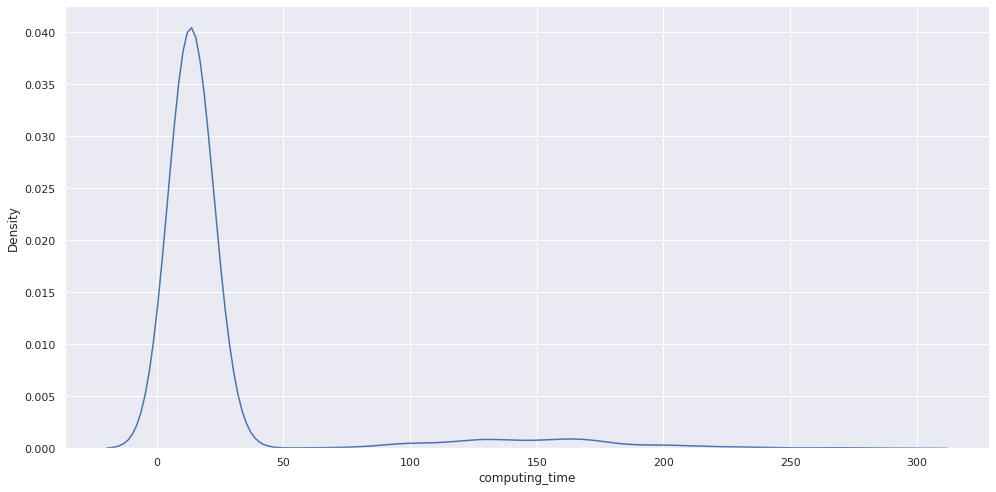

In [ ]:
sns.displot(df_cw_filter[gspace_name], x='computing_time', kind="kde", palette="Reds", height=7, aspect=2)

There are some simulations that were done by a 0.125 vCPU instance of IBM Code Engine (computing times $\approx$ 150 s) and others were done by a 1 vCPU instance (computing time $\approx$ 15 s)

In [ ]:
df = df_cw_filter[gspace_name]

In [ ]:
df[df['computing_time'] > 50]['computing_time'].describe()

count    256.000000
mean     150.417406
std       40.893637
min       50.110005
25%      120.844912
50%      148.574673
75%      169.913032
max      287.727849
Name: computing_time, dtype: float64

In [ ]:
df[df['computing_time'] < 50]['computing_time'].describe()

count    2744.000000
mean       13.679012
std         4.024789
min         4.724136
25%        10.883958
50%        13.335798
75%        16.034551
max        32.949252
Name: computing_time, dtype: float64

In [ ]:
df_cw_filter[gspace_name]['computing_time'].describe()

count    3000.000000
mean       25.347355
std        40.210136
min         4.724136
25%        11.064404
50%        13.764194
75%        17.057149
max       287.727849
Name: computing_time, dtype: float64

In [ ]:
df_cw_filter[gspace_name]['coverage_rate'] = df_cw_filter[gspace_name]['total_mutations']/(df_cw_filter[gspace_name]['simulation_time']*3600) # mutations/second

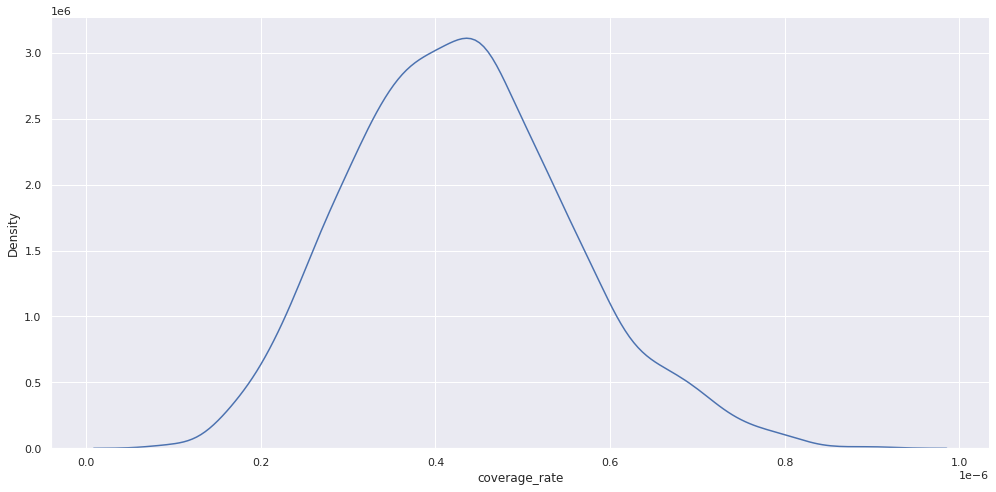

In [ ]:
sns.displot(x='coverage_rate', data=df_cw_filter[gspace_name], kind="kde", palette="Reds", height=7, aspect=2)

In [ ]:
df_cw_filter[gspace_name]['coverage_rate'].describe()

count    3.000000e+03
mean     4.292597e-07
std      1.263011e-07
min      8.511954e-08
25%      3.373886e-07
50%      4.253342e-07
75%      5.086609e-07
max      9.088893e-07
Name: coverage_rate, dtype: float64

In [ ]:
times_hitted_phen_c = {}
for step in distance[gspace_name][initial_node[gspace_name]].keys():
  total = len(distance[gspace_name][initial_node[gspace_name]][step])
  if total == 0:
    continue
  print("Mutational steps:", step)
  print(f"Total number of phenotypes at {step} mutational step(s):", total)
  hitted_phens = 0
  hitted_phens_50 = 0

  for phen in distance[gspace_name][initial_node[gspace_name]][step]:
    times_hitted_phen_c[phen] = df_cw_filter[gspace_name][df_cw_filter[gspace_name][f"mutations_{phen}"] != -1].shape[0] # number of simulations that hitted current phenotype
    
    if times_hitted_phen_c[phen] > 0:
      hitted_phens += 1

    if times_hitted_phen_c[phen]/total >= 0.5:
      hitted_phens_50 += 1
  
  print("Number of phenotypes that \n... were hitted at least once:", hitted_phens, "/", total)
  print("... were hitted more than 50% of the simulations:", hitted_phens_50, "/", total, "\n")

Mutational steps: 0
Total number of phenotypes at 0 mutational step(s): 1
Number of phenotypes that 
... were hitted at least once: 1 / 1
... were hitted more than 50% of the simulations: 1 / 1 

Mutational steps: 1
Total number of phenotypes at 1 mutational step(s): 29
Number of phenotypes that 
... were hitted at least once: 29 / 29
... were hitted more than 50% of the simulations: 29 / 29 

Mutational steps: 2
Total number of phenotypes at 2 mutational step(s): 46
Number of phenotypes that 
... were hitted at least once: 46 / 46
... were hitted more than 50% of the simulations: 46 / 46 

Mutational steps: 3
Total number of phenotypes at 3 mutational step(s): 41
Number of phenotypes that 
... were hitted at least once: 41 / 41
... were hitted more than 50% of the simulations: 41 / 41 

Mutational steps: 4
Total number of phenotypes at 4 mutational step(s): 1
Number of phenotypes that 
... were hitted at least once: 1 / 1
... were hitted more than 50% of the simulations: 1 / 1 



## Arabidopsis thaliana

In [ ]:
gspace_name = names[3]

In [ ]:
df_cw_filter[gspace_name]

,max_simulation_time,total_mutations,computing_time,simulation_time,datetime,tau_GATA15,mutations_GATA15,tau_EDT1,mutations_EDT1,tau_WRKY15,mutations_WRKY15,tau_PIL5,mutations_PIL5,tau_UNE10,mutations_UNE10,tau_TRFL5,mutations_TRFL5,tau_AT1G01260,mutations_AT1G01260,tau_CRF3,mutations_CRF3,tau_Rap2.6L,mutations_Rap2.6L,tau_ATMYB4,mutations_ATMYB4,tau_ATHB7,mutations_ATHB7,tau_WRKY8,mutations_WRKY8,tau_ATGRP2B,mutations_ATGRP2B,tau_SPL1R2,mutations_SPL1R2,tau_E2FE,mutations_E2FE,tau_NTL9,mutations_NTL9,tau_TCP5,mutations_TCP5,tau_ANAC079,...,tau_AT3G23230,mutations_AT3G23230,tau_ZFP5,mutations_ZFP5,tau_EPR1,mutations_EPR1,tau_LBD4,mutations_LBD4,tau_ATHB-12,mutations_ATHB-12,tau_ATHB6,mutations_ATHB6,tau_TGA1,mutations_TGA1,tau_BZIP17,mutations_BZIP17,tau_AT4G00238,mutations_AT4G00238,tau_WRKY48,mutations_WRKY48,tau_AT5G64220,mutations_AT5G64220,tau_RBE,mutations_RBE,tau_TCP3,mutations_TCP3,tau_NST1,mutations_NST1,tau_ATWRKY17,mutations_ATWRKY17,tau_SPL5,mutations_SPL5,tau_AT5G46760,mutations_AT5G46760,tau_WRKY23,mutations_WRKY23,tau_bHLH34,mutations_bHLH34,tau_AT5G05090,mutations_AT5G05090
19,38000000.0,15.0,8.897820,11312.6,20/12/2021 17:18:33,4.072539e+07,-1.0,4.072539e+07,-1.0,4.072539e+07,-1.0,4.072539e+07,-1.0,4.072539e+07,-1.0,3.038276e+07,8.0,4.072539e+07,-1.0,4.072539e+07,-1.0,4.072539e+07,-1.0,4.072539e+07,-1.0,4.072539e+07,-1.0,4.072539e+07,-1.0,4.072539e+07,-1.0,4.072539e+07,-1.0,4.072539e+07,-1.0,4.072539e+07,-1.0,4.072539e+07,-1.0,4.072539e+07,...,4.072539e+07,-1.0,4.072539e+07,-1.0,4.072539e+07,-1.0,4.072539e+07,-1.0,4.072539e+07,-1.0,4.072539e+07,-1.0,4.072539e+07,-1.0,4.072539e+07,-1.0,4.072539e+07,-1.0,4.072539e+07,-1.0,4.072539e+07,-1.0,4.072539e+07,-1.0,4.072539e+07,-1.0,4.072539e+07,-1.0,4.072539e+07,-1.0,4.072539e+07,-1.0,4.072539e+07,-1.0,4.072539e+07,-1.0,4.072539e+07,-1.0,4.072539e+07,-1.0
20,38000000.0,20.0,12.275423,11417.2,20/12/2021 17:18:42,4.110177e+07,-1.0,4.110177e+07,-1.0,3.365033e+07,17.0,4.110177e+07,-1.0,4.110177e+07,-1.0,4.110177e+07,-1.0,4.110177e+07,-1.0,4.110177e+07,-1.0,4.110177e+07,-1.0,4.110177e+07,-1.0,4.110177e+07,-1.0,1.267750e+07,5.0,4.110177e+07,-1.0,4.110177e+07,-1.0,4.110177e+07,-1.0,4.110177e+07,-1.0,4.110177e+07,-1.0,4.110177e+07,...,4.110177e+07,-1.0,3.073679e+07,14.0,4.110177e+07,-1.0,4.110177e+07,-1.0,4.110177e+07,-1.0,4.110177e+07,-1.0,4.110177e+07,-1.0,4.110177e+07,-1.0,4.110177e+07,-1.0,3.365033e+07,17.0,4.110177e+07,-1.0,4.110177e+07,-1.0,4.110177e+07,-1.0,4.110177e+07,-1.0,3.463724e+07,18.0,4.110177e+07,-1.0,4.110177e+07,-1.0,4.110177e+07,-1.0,4.110177e+07,-1.0,4.110177e+07,-1.0
21,38000000.0,21.0,12.037744,11356.7,20/12/2021 17:18:55,4.088398e+07,-1.0,2.486726e+06,2.0,4.088398e+07,-1.0,4.088398e+07,-1.0,4.088398e+07,-1.0,4.088398e+07,-1.0,4.088398e+07,-1.0,4.088398e+07,-1.0,4.088398e+07,-1.0,4.088398e+07,-1.0,2.267631e+07,14.0,4.088398e+07,-1.0,1.464752e+07,11.0,4.088398e+07,-1.0,4.088398e+07,-1.0,4.088398e+07,-1.0,4.088398e+07,-1.0,4.088398e+07,...,4.088398e+07,-1.0,1.209537e+05,1.0,4.088398e+07,-1.0,4.088398e+07,-1.0,4.088398e+07,-1.0,1.705824e+07,13.0,4.088398e+07,-1.0,4.088398e+07,-1.0,4.088398e+07,-1.0,4.088398e+07,-1.0,4.088398e+07,-1.0,3.195536e+06,3.0,4.088398e+07,-1.0,4.088398e+07,-1.0,4.088398e+07,-1.0,4.088398e+07,-1.0,4.088398e+07,-1.0,4.088398e+07,-1.0,4.088398e+07,-1.0,4.088398e+07,-1.0
22,38000000.0,14.0,8.594388,11341.7,20/12/2021 17:19:07,4.083016e+07,-1.0,4.083016e+07,-1.0,4.083016e+07,-1.0,4.083016e+07,-1.0,4.083016e+07,-1.0,4.083016e+07,-1.0,4.083016e+07,-1.0,4.083016e+07,-1.0,4.083016e+07,-1.0,4.083016e+07,-1.0,4.083016e+07,-1.0,4.083016e+07,-1.0,4.083016e+07,-1.0,4.083016e+07,-1.0,4.083016e+07,-1.0,4.083016e+07,-1.0,4.083016e+07,-1.0,4.083016e+07,...,4.083016e+07,-1.0,8.789967e+06,5.0,1.950523e+06,1.0,4.083016e+07,-1.0,4.083016e+07,-1.0,4.083016e+07,-1.0,4.083016e+07,-1.0,4.083016e+07,-1.0,4.083016e+07,-1.0,4.083016e+07,-1.0,4.083016e+07,-1.0,4.083016e+07,-1.0,4.083016e+07,-1.0,4.083016e+07,-1.0,4.083016e+07,-1.0,4.083016e+07,-1.0,4.083016e+07,-

In [ ]:
df_cw_filter[gspace_name]['total_mutations'].describe()

count    100.00000
mean      16.52000
std        3.93246
min        8.00000
25%       14.00000
50%       16.00000
75%       20.00000
max       26.00000
Name: total_mutations, dtype: float64

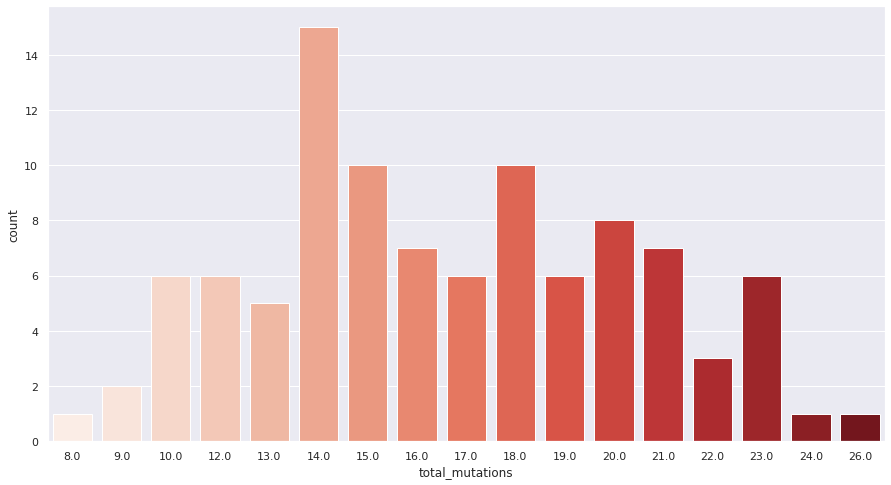

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x="total_mutations", data=df_cw_filter[gspace_name], palette="Reds")

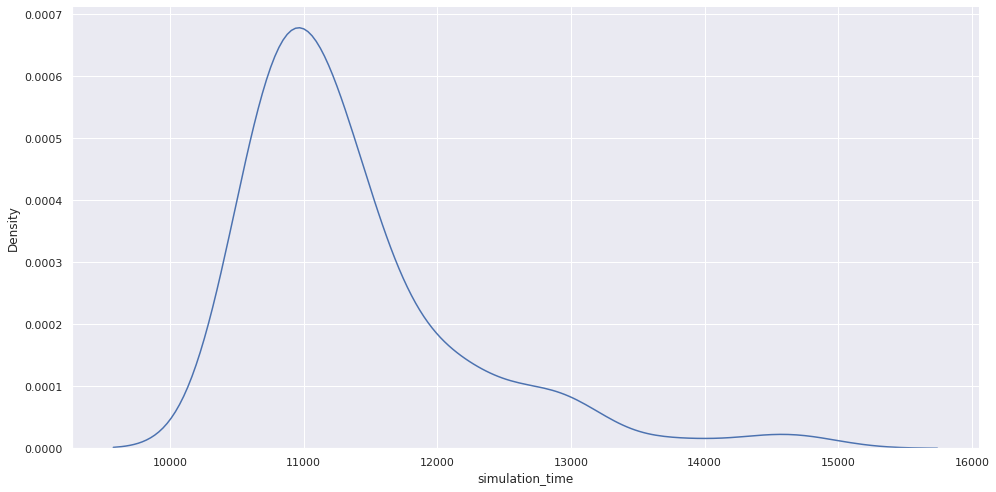

In [ ]:
sns.displot(df_cw_filter[gspace_name], x='simulation_time', kind="kde", palette="Reds", height=7, aspect=2)

In [ ]:
df_cw_filter[gspace_name]['simulation_time'].describe()

count       100.0000
unique      100.0000
top       11773.2834
freq          1.0000
Name: simulation_time, dtype: float64

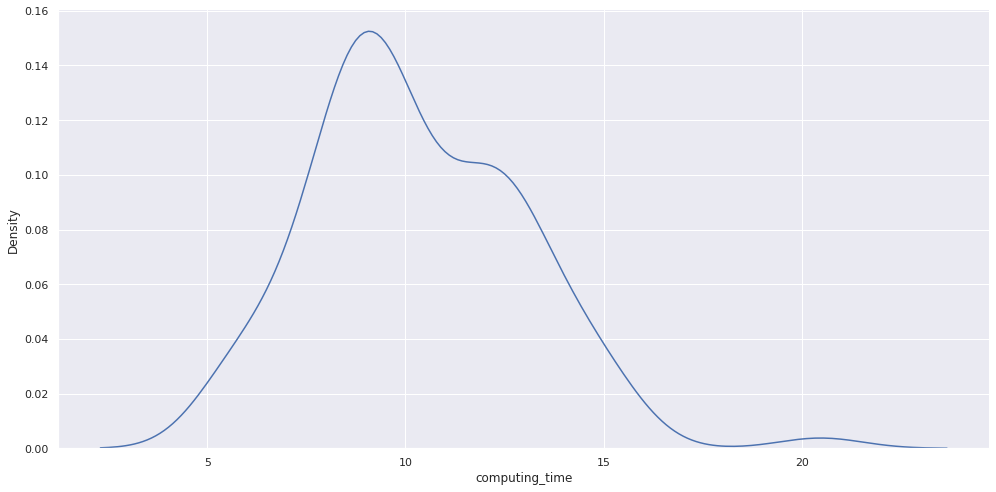

In [ ]:
sns.displot(df_cw_filter[gspace_name], x='computing_time', kind="kde", palette="Reds", height=7, aspect=2)

In [ ]:
df_cw_filter[gspace_name]['computing_time'].describe()

count    100.000000
mean      10.302487
std        2.668994
min        5.494477
25%        8.585401
50%        9.737798
75%       12.235256
max       20.470908
Name: computing_time, dtype: float64

In [ ]:
df_cw_filter[gspace_name]['coverage_rate'] = df_cw_filter[gspace_name]['total_mutations']/(df_cw_filter[gspace_name]['simulation_time']*3600) # mutations/second

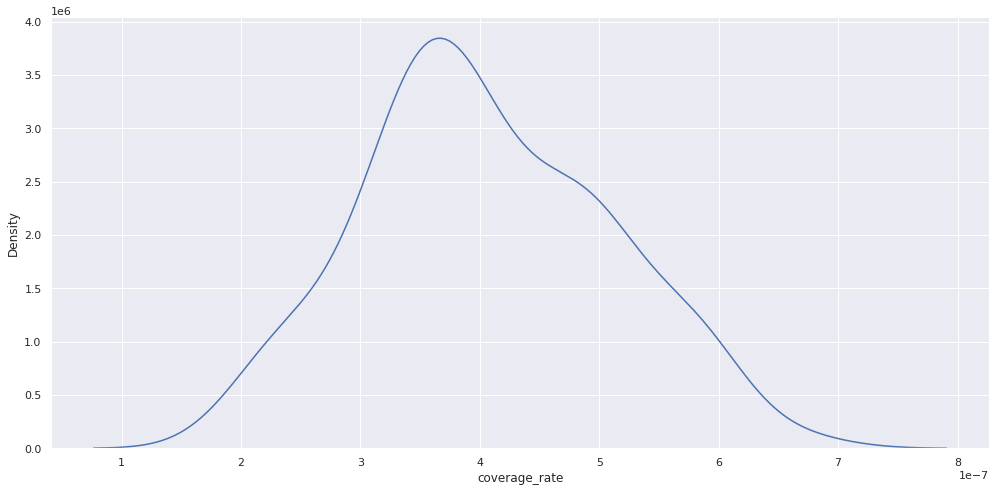

In [ ]:
sns.displot(x='coverage_rate', data=df_cw_filter[gspace_name], kind="kde", palette="Reds", height=7, aspect=2)

In [ ]:
df_cw_filter[gspace_name]['coverage_rate'].describe()

count     1.000000e+02
unique    1.000000e+02
top       2.330501e-07
freq      1.000000e+00
Name: coverage_rate, dtype: float64

In [ ]:
times_hitted_phen_c = {}
for step in distance[gspace_name][initial_node[gspace_name]].keys():
  total = len(distance[gspace_name][initial_node[gspace_name]][step])
  if total == 0:
    continue
  print("Mutational steps:", step)
  print(f"Total number of phenotypes at {step} mutational step(s):", total)
  hitted_phens = 0
  hitted_phens_50 = 0

  for phen in distance[gspace_name][initial_node[gspace_name]][step]:
    times_hitted_phen_c[phen] = df_cw_filter[gspace_name][df_cw_filter[gspace_name][f"mutations_{phen}"] != -1].shape[0] # number of simulations that hitted current phenotype
    
    if times_hitted_phen_c[phen] > 0:
      hitted_phens += 1

    if times_hitted_phen_c[phen]/total >= 0.5:
      hitted_phens_50 += 1
  
  print("Number of phenotypes that \n... were hitted at least once:", hitted_phens, "/", total)
  print("... were hitted more than 50% of the simulations:", hitted_phens_50, "/", total, "\n")

Mutational steps: 0
Total number of phenotypes at 0 mutational step(s): 1
Number of phenotypes that 
... were hitted at least once: 1 / 1
... were hitted more than 50% of the simulations: 1 / 1 

Mutational steps: 1
Total number of phenotypes at 1 mutational step(s): 28
Number of phenotypes that 
... were hitted at least once: 28 / 28
... were hitted more than 50% of the simulations: 25 / 28 

Mutational steps: 2
Total number of phenotypes at 2 mutational step(s): 77
Number of phenotypes that 
... were hitted at least once: 76 / 77
... were hitted more than 50% of the simulations: 1 / 77 

Mutational steps: 3
Total number of phenotypes at 3 mutational step(s): 58
Number of phenotypes that 
... were hitted at least once: 55 / 58
... were hitted more than 50% of the simulations: 0 / 58 

Mutational steps: 4
Total number of phenotypes at 4 mutational step(s): 40
Number of phenotypes that 
... were hitted at least once: 33 / 40
... were hitted more than 50% of the simulations: 0 / 40 

Mut

# Comparing classical and quantum models

In [ ]:
sns.set(font_scale=1.3)

In [ ]:
df_results = {}

In [ ]:
for i in [1, 2, 3]:
  gspace_name = names[i]

  df_qw_filter[gspace_name]['model'] = ['quantum walk' for i in range(df_qw_filter[gspace_name].shape[0])]
  df_cw_filter[gspace_name]['model'] = ['classical walk' for i in range(df_cw_filter[gspace_name].shape[0])]
  df_results[gspace_name] = pd.concat([df_qw_filter[gspace_name], df_cw_filter[gspace_name]], ignore_index=True)

  df_results[gspace_name] = df_results[gspace_name].astype({"total_mutations": int})
  df_results[gspace_name] = df_results[gspace_name].astype({"simulation_time": float})
  df_results[gspace_name] = df_results[gspace_name].astype({"coverage_rate": float})

In [ ]:
df_hitting_times = {} # dataframes for each of the genotype space to analyze hitting times

## Mus musculus

In [ ]:
gspace_name = names[1]

In [ ]:
print("Quantum walk simulations:", df_results[gspace_name][df_results[gspace_name]['model'] == 'quantum walk'].shape[0])
print("Classical walk simulations:", df_results[gspace_name][df_results[gspace_name]['model'] == 'classical walk'].shape[0])

Quantum walk simulations: 3000
Classical walk simulations: 3000


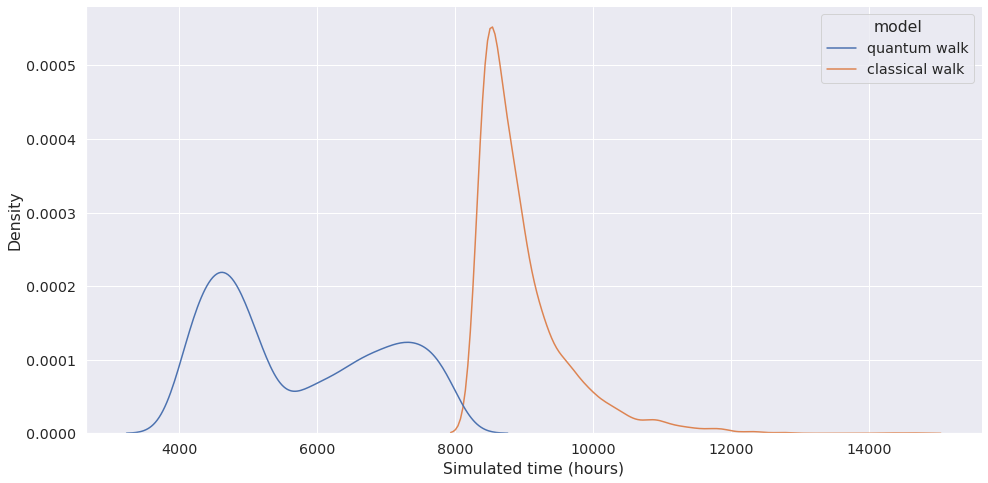

In [ ]:
g = sns.displot(df_results[gspace_name], x='simulation_time', hue='model', kind='kde', 
            height=7, aspect=2, facet_kws={"legend_out": False})
g.set_xlabels("Simulated time (hours)")

Text(0.5, 0, 'Total number of mutations')

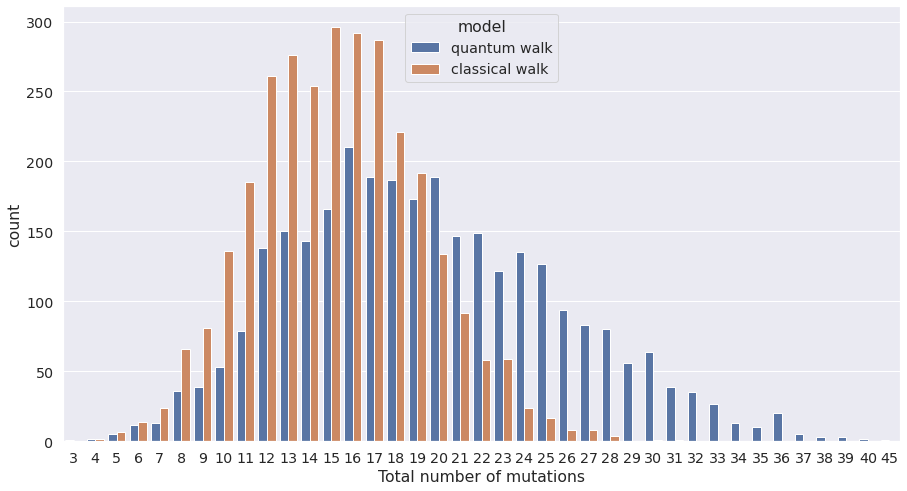

In [ ]:
g = sns.countplot(x="total_mutations", data=df_results[gspace_name], hue="model")
g.set_xlabel("Total number of mutations")

In [ ]:
df_results[gspace_name].groupby(['model'])['simulation_time'].describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
classical walk,3000.0,8962.821600,663.422516,8334.098180,8512.856095,8758.249956,9181.056077,14631.715465
quantum walk,3000.0,5754.554146,1258.826481,4000.255566,4625.648419,5291.736155,6958.733144,7998.828388


In [ ]:
df_results[gspace_name].groupby(['model'])['total_mutations'].describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
classical walk,3000.0,15.227667,3.932386,4.0,12.0,15.0,18.0,31.0
quantum walk,3000.0,19.556333,6.293809,3.0,15.0,19.0,24.0,45.0


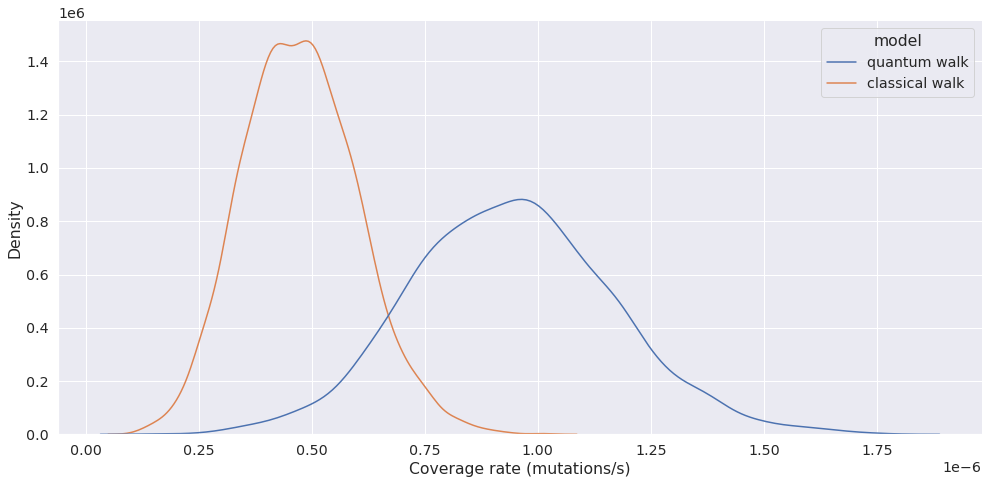

In [ ]:
g = sns.displot(df_results[gspace_name], x='coverage_rate', hue='model', kind='kde', height=7, aspect=2, 
            facet_kws={"legend_out": False})
g.set_xlabels("Coverage rate (mutations/s)")

In [ ]:
df_results[gspace_name].groupby(['model'])['coverage_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
classical walk,3000.0,4.743315e-07,1.268126e-07,1.256621e-07,3.865850e-07,4.696921e-07,5.586352e-07,0.000001
quantum walk,3000.0,9.432422e-07,2.251739e-07,1.681888e-07,7.889782e-07,9.412100e-07,1.089459e-06,0.000002


The coverage rate using CTQW is greater than the coverage rate using CTRW:

In [ ]:
df_results[gspace_name].groupby(['model'])['coverage_rate'].describe()['mean']['quantum walk']/df_results[gspace_name].groupby(['model'])['coverage_rate'].describe()['mean']['classical walk']

1.9885714559481016

In [ ]:
df_results[gspace_name].groupby(['model'])['computing_time'].describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
classical walk,3000.0,14.061258,108.434759,3.204977,8.802650,10.947219,13.393458,5661.639189
quantum walk,3000.0,59.000125,0.001439,59.000000,59.000034,59.000072,59.000111,59.064289


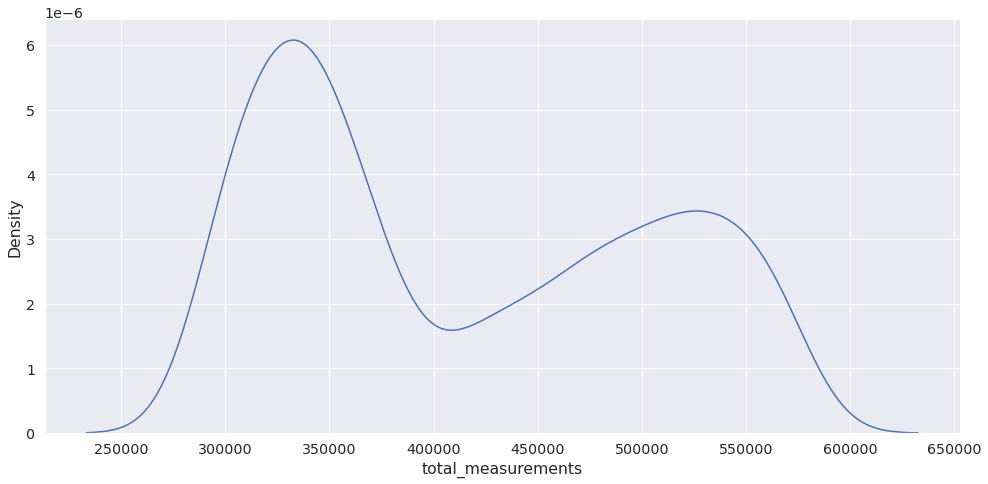

In [ ]:
sns.displot(df_qw_filter[gspace_name], x='total_measurements', kind='kde', height=7, aspect=2, 
            facet_kws={"legend_out": False})

In [ ]:
df_results[gspace_name].groupby(['model'])['total_measurements'].describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
classical walk,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
quantum walk,3000.0,414338.394,90645.347738,288181.0,333220.0,381334.5,500744.0,577849.0


In [ ]:
ratios = {}
ratios_better = {}
errors_m = {}
mean_hitting_times = {'model': [], 'step': [], 'phenotype': [], 'mean_hitting_time': [], 'mean_mutations': []}

for step in range(1,7):
  total_phenotypes = len(distance[gspace_name][initial_node[gspace_name]][f'{step}'])
  if total_phenotypes == 0:
    continue
  
  ratios[step] = []
  ratios_better[step] = []
  errors_m[step] = []

  better = 0
  not_hitted = 0

  for phen in distance[gspace_name][initial_node[gspace_name]][f'{step}']:
    mean1 = df_qw_filter[gspace_name][df_qw_filter[gspace_name][f'mutations_{phen}'] != -1][f'tau_{phen}'].mean()
    mean2 = df_cw_filter[gspace_name][df_cw_filter[gspace_name][f'mutations_{phen}'] != -1][f'tau_{phen}'].mean()

    mean1_m = df_qw_filter[gspace_name][df_qw_filter[gspace_name][f'mutations_{phen}'] != -1][f'mutations_{phen}'].mean()
    mean2_m = df_cw_filter[gspace_name][df_cw_filter[gspace_name][f'mutations_{phen}'] != -1][f'mutations_{phen}'].mean()

    ratio = mean1/mean2
    error = mean1_m-mean2_m

    if (not math.isnan(mean1)) and (not math.isnan(mean2)): # If both means exists, then the quantum walk and random walk did hit phenotype phen in some simulations
      if ratio < 1:
        better += 1
        ratios_better[step].append(ratio)
      
      ratios[step].append(ratio)
      errors_m[step].append(error)

      # quantum walk info
      mean_hitting_times['step'].append(step)
      mean_hitting_times['model'].append('quantum walk')
      mean_hitting_times['phenotype'].append(phen)
      mean_hitting_times['mean_hitting_time'].append(mean1)
      mean_hitting_times['mean_mutations'].append(mean1_m)

      # classical walk info
      mean_hitting_times['step'].append(step)
      mean_hitting_times['model'].append('classical walk')
      mean_hitting_times['phenotype'].append(phen)
      mean_hitting_times['mean_hitting_time'].append(mean2)
      mean_hitting_times['mean_mutations'].append(mean2_m)

    else:
      if math.isnan(mean1):
        print(f"Phenotype {phen} at {step} steps was not hitted by quantum walk")
      else:
        print(f"Phenotype {phen} at {step} steps was not hitted by quantum walk")

      not_hitted += 1

  ratios[step] = np.array(ratios[step])
  ratios_better[step] = np.array(ratios_better[step])
  errors_m[step] = np.array(errors_m[step])

  print(f"Phenotypes at {step} steps:") 
  print(f"{total_phenotypes-not_hitted}/{total_phenotypes} were hitted by both walks")
  print(f"{better}/{total_phenotypes - not_hitted} phenotypes had better quantum hitting time")
  print(f"{1/ratios_better[step].mean()} faster")
  print(f"Mean difference between the number of mutations the CTQW and CTRW took to find phenotypes: {errors_m[step].mean()} \n")

Phenotypes at 1 steps:
38/38 were hitted by both walks
38/38 phenotypes had better quantum hitting time
1.4738238145969356 faster
Mean difference between the number of mutations the CTQW and CTRW took to find phenotypes: 1.6632279014430378 

Phenotypes at 2 steps:
85/85 were hitted by both walks
85/85 phenotypes had better quantum hitting time
1.4526912531316674 faster
Mean difference between the number of mutations the CTQW and CTRW took to find phenotypes: 2.711292049072062 

Phenotypes at 3 steps:
61/61 were hitted by both walks
61/61 phenotypes had better quantum hitting time
1.4281751219729117 faster
Mean difference between the number of mutations the CTQW and CTRW took to find phenotypes: 3.5378271462289734 

Phenotypes at 4 steps:
5/5 were hitted by both walks
5/5 phenotypes had better quantum hitting time
1.417523385743488 faster
Mean difference between the number of mutations the CTQW and CTRW took to find phenotypes: 4.0368182031868 



In [ ]:
df_hitting_times[gspace_name] = pd.DataFrame(mean_hitting_times)
df_hitting_times[gspace_name]

,model,step,phenotype,mean_hitting_time,mean_mutations
0,quantum walk,1,Sfpi1,7.872262e+06,8.114650
1,classical walk,1,Sfpi1,1.072337e+07,5.678922
2,quantum walk,1,Zfp105,6.864172e+06,6.973936
3,classical walk,1,Zfp105,1.058692e+07,5.613071
4,quantum walk,1,Gabpa,7.283445e+06,7.583468
...,...,...,...,...,...
373,classical walk,4,Jun,2.207544e+07,11.277778
374,quantum walk,4,Terf2,1.512384e+07,15.870588
375,classical walk,4,Terf2,2.001021e+07,11.491803
376,quantum walk,4,Jund,1.300371e+07,13.216216


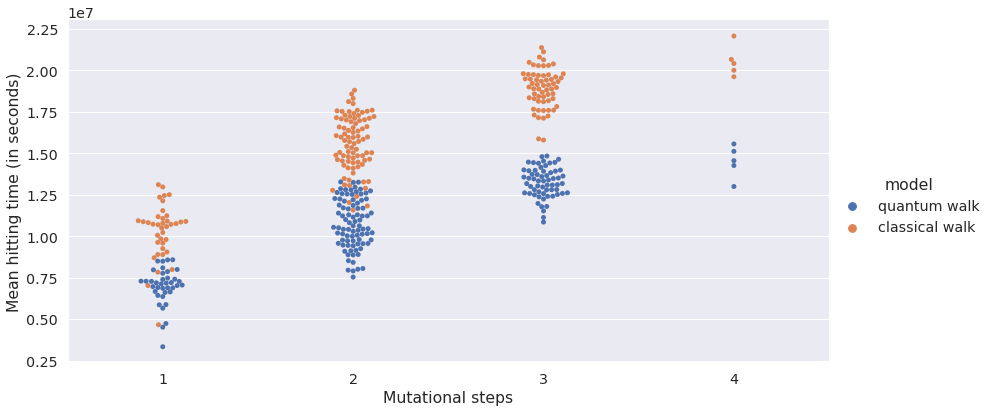

In [ ]:
g = sns.catplot(data=df_hitting_times[gspace_name], x="step", y='mean_hitting_time', hue='model', kind='swarm', 
            height=6, aspect=2, facet_kws={"legend_out": False})
g.set_xlabels("Mutational steps")
g.set_ylabels("Mean hitting time (in seconds)")

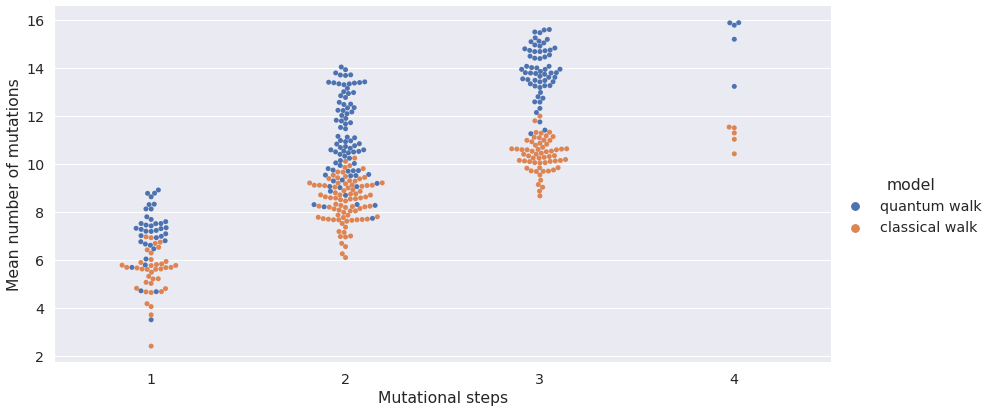

In [ ]:
g = sns.catplot(data=df_hitting_times[gspace_name], x="step", y='mean_mutations', hue='model', kind='swarm', height=6, aspect=2,
    facet_kws={"legend_out": False})
g.set_xlabels("Mutational steps")
g.set_ylabels("Mean number of mutations")

In [ ]:
df_hitting_times[gspace_name].groupby(['model', 'step'])[['mean_hitting_time', 'mean_mutations']].describe()

mean_hitting_time                ... mean_mutations           
                                count          mean  ...            75%        max
model          step                                  ...                          
classical walk 1                 38.0  1.032256e+07  ...       5.866703   6.950711
               2                 85.0  1.561194e+07  ...       9.101333  10.231270
               3                 61.0  1.894642e+07  ...      10.764228  11.980952
               4                  5.0  2.055807e+07  ...      11.491803  11.521277
quantum walk   1                 38.0  6.985626e+06  ...       7.652439   8.903255
               2                 85.0  1.077084e+07  ...      12.479810  14.024499
               3                 61.0  1.324877e+07  ...      14.701571  15.585366
               4                  5.0  1.450542e+07  ...      15.863636  15.870588

[8 rows x 16 columns]

In [ ]:
mr_cw = df_results[gspace_name].groupby(['model'])['coverage_rate'].describe()['mean']['classical walk']
mr_qw = df_results[gspace_name].groupby(['model'])['coverage_rate'].describe()['mean']['quantum walk']

ht_cw = 1.032256e+07
ht_qw = 6.985626e+06

print(mr_cw*ht_cw, mr_qw*ht_qw)

4.896315855870036 6.5891370649008865


In [ ]:
for step in range(1,5):
  mean_cw = df_hitting_times[gspace_name].groupby(['model', 'step'])['mean_hitting_time'].describe()['mean']['classical walk'][step]
  mean_qw = df_hitting_times[gspace_name].groupby(['model', 'step'])['mean_hitting_time'].describe()['mean']['quantum walk'][step]
  print(f"Step = {step}, Speed-up =", mean_cw/mean_qw) 

Step = 1, Speed-up = 1.477685108772458
Step = 2, Speed-up = 1.4494637444567435
Step = 3, Speed-up = 1.4300512536013856
Step = 4, Speed-up = 1.4172679428473793


In [ ]:
for step in range(1,5):
  mean_cw = df_hitting_times[gspace_name].groupby(['model', 'step'])['mean_mutations'].describe()['mean']['classical walk'][step]
  mean_qw = df_hitting_times[gspace_name].groupby(['model', 'step'])['mean_mutations'].describe()['mean']['quantum walk'][step]
  print(f"Step = {step}, Difference of mutations =", mean_qw - mean_cw) 

Step = 1, Difference of mutations = 1.6632279014430367
Step = 2, Difference of mutations = 2.711292049072064
Step = 3, Difference of mutations = 3.537827146228974
Step = 4, Difference of mutations = 4.036818203186799


## Neurospora crassa

In [ ]:
gspace_name = names[2]

In [ ]:
print("Quantum walk simulations:", df_results[gspace_name][df_results[gspace_name]['model'] == 'quantum walk'].shape[0])
print("Classical walk simulations:", df_results[gspace_name][df_results[gspace_name]['model'] == 'classical walk'].shape[0])

Quantum walk simulations: 3000
Classical walk simulations: 3000


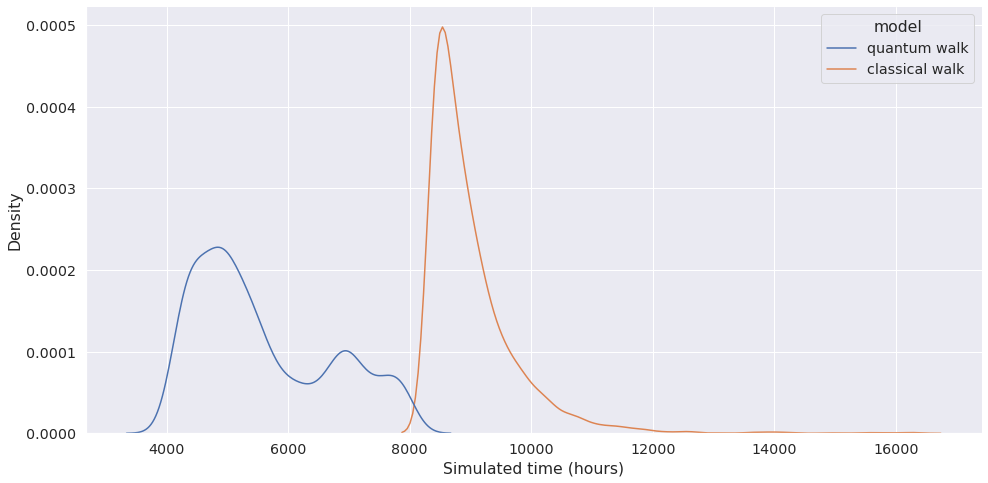

In [ ]:
g = sns.displot(df_results[gspace_name], x='simulation_time', hue='model', kind='kde', 
            height=7, aspect=2, facet_kws={"legend_out": False})
g.set_xlabels("Simulated time (hours)")

Text(0.5, 0, 'Total number of mutations')

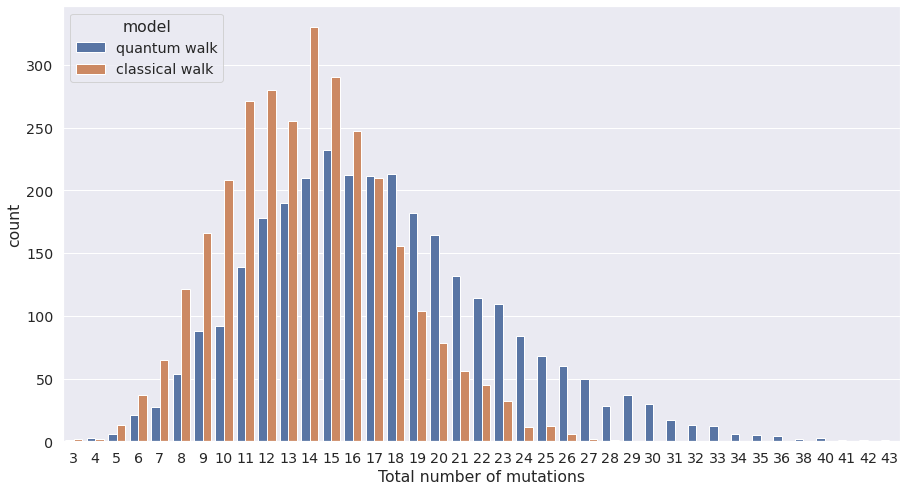

In [ ]:
g = sns.countplot(x="total_mutations", data=df_results[gspace_name], hue="model")
g.set_xlabel("Total number of mutations")

In [ ]:
df_results[gspace_name].groupby(['model'])['simulation_time'].describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
classical walk,3000.0,9011.636851,764.579903,8333.430994,8518.172121,8786.617060,9239.323562,16279.616907
quantum walk,3000.0,5579.975195,1118.925242,4015.528547,4682.289210,5233.321365,6566.047623,7999.645395


In [ ]:
df_results[gspace_name].groupby(['model'])['total_mutations'].describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
classical walk,3000.0,13.831333,3.909985,3.0,11.0,14.0,16.0,28.0
quantum walk,3000.0,17.321333,5.728847,3.0,13.0,17.0,21.0,43.0


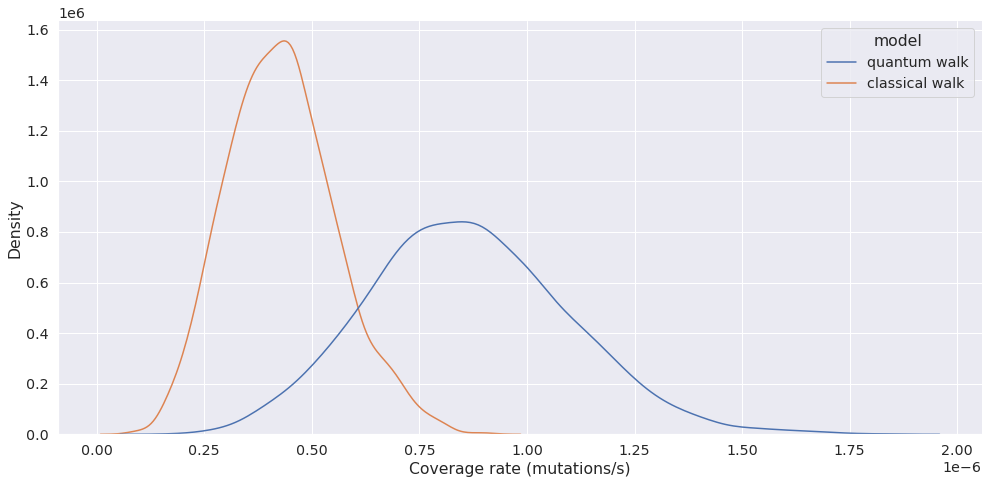

In [ ]:
g = sns.displot(df_results[gspace_name], x='coverage_rate', hue='model', kind='kde', height=7, aspect=2, 
            facet_kws={"legend_out": False})
g.set_xlabels("Coverage rate (mutations/s)")

In [ ]:
df_results[gspace_name].groupby(['model'])['coverage_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
classical walk,3000.0,4.292597e-07,1.263011e-07,8.511954e-08,3.373886e-07,4.253342e-07,5.086609e-07,9.088893e-07
quantum walk,3000.0,8.637058e-07,2.337706e-07,1.959619e-07,7.024576e-07,8.541038e-07,1.013299e-06,1.817437e-06


The coverage rate using CTQW is greater than the coverage rate using CTRW:

In [ ]:
df_results[gspace_name].groupby(['model'])['coverage_rate'].describe()['mean']['quantum walk']/df_results[gspace_name].groupby(['model'])['coverage_rate'].describe()['mean']['classical walk']

2.0120822125532145

In [ ]:
df_results[gspace_name].groupby(['model'])['computing_time'].describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
classical walk,3000.0,25.347355,40.210136,4.724136,11.064404,13.764194,17.057149,287.727849
quantum walk,3000.0,35.587223,25.848584,5.138889,5.138897,59.000006,59.000078,59.000595


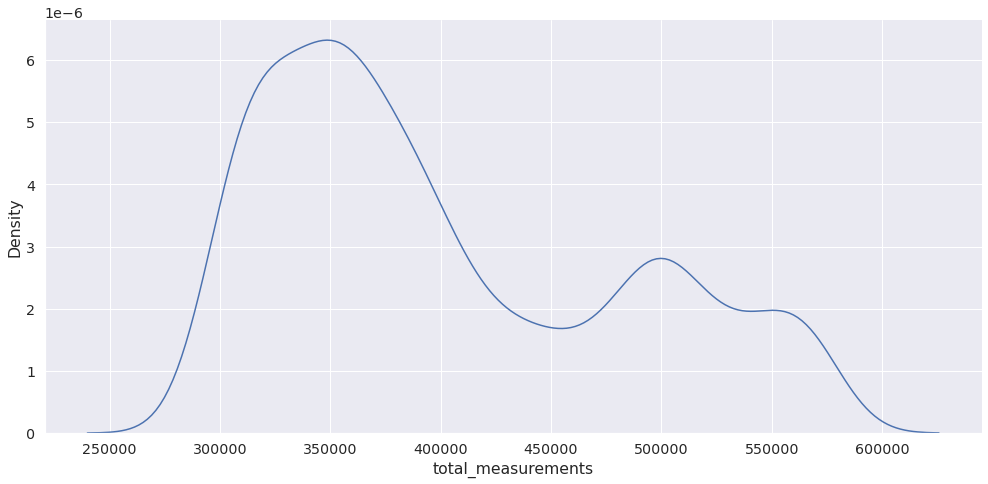

In [ ]:
sns.displot(df_qw_filter[gspace_name], x='total_measurements', kind='kde', height=7, aspect=2, 
            facet_kws={"legend_out": False})

In [ ]:
df_results[gspace_name].groupby(['model'])['total_measurements'].describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
classical walk,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
quantum walk,3000.0,401761.396667,80548.845534,288660.0,337373.75,376944.5,472876.25,577006.0


In [ ]:
ratios = {}
ratios_better = {}
errors_m = {}
mean_hitting_times = {'model': [], 'step': [], 'phenotype': [], 'mean_hitting_time': [], 'mean_mutations': []}

for step in range(1,7):
  total_phenotypes = len(distance[gspace_name][initial_node[gspace_name]][f'{step}'])
  if total_phenotypes == 0:
    continue
  
  ratios[step] = []
  ratios_better[step] = []
  errors_m[step] = []

  better = 0
  not_hitted = 0

  for phen in distance[gspace_name][initial_node[gspace_name]][f'{step}']:
    mean1 = df_qw_filter[gspace_name][df_qw_filter[gspace_name][f'mutations_{phen}'] != -1][f'tau_{phen}'].mean()
    mean2 = df_cw_filter[gspace_name][df_cw_filter[gspace_name][f'mutations_{phen}'] != -1][f'tau_{phen}'].mean()

    mean1_m = df_qw_filter[gspace_name][df_qw_filter[gspace_name][f'mutations_{phen}'] != -1][f'mutations_{phen}'].mean()
    mean2_m = df_cw_filter[gspace_name][df_cw_filter[gspace_name][f'mutations_{phen}'] != -1][f'mutations_{phen}'].mean()

    ratio = mean1/mean2
    error = mean1_m-mean2_m

    if (not math.isnan(mean1)) and (not math.isnan(mean2)): # If both means exists, then the quantum walk and random walk did hit phenotype phen in some simulations
      if ratio < 1:
        better += 1
        ratios_better[step].append(ratio)
      
      ratios[step].append(ratio)
      errors_m[step].append(error)

      # quantum walk info
      mean_hitting_times['step'].append(step)
      mean_hitting_times['model'].append('quantum walk')
      mean_hitting_times['phenotype'].append(phen)
      mean_hitting_times['mean_hitting_time'].append(mean1)
      mean_hitting_times['mean_mutations'].append(mean1_m)

      # classical walk info
      mean_hitting_times['step'].append(step)
      mean_hitting_times['model'].append('classical walk')
      mean_hitting_times['phenotype'].append(phen)
      mean_hitting_times['mean_hitting_time'].append(mean2)
      mean_hitting_times['mean_mutations'].append(mean2_m)

    else:
      if math.isnan(mean1):
        print(f"Phenotype {phen} at {step} steps was not hitted by quantum walk")
      else:
        print(f"Phenotype {phen} at {step} steps was not hitted by quantum walk")

      not_hitted += 1

  ratios[step] = np.array(ratios[step])
  ratios_better[step] = np.array(ratios_better[step])
  errors_m[step] = np.array(errors_m[step])

  print(f"Phenotypes at {step} steps:") 
  print(f"{total_phenotypes-not_hitted}/{total_phenotypes} were hitted by both walks")
  print(f"{better}/{total_phenotypes - not_hitted} phenotypes had better quantum hitting time")
  print(f"{1/ratios_better[step].mean()} faster")
  print(f"Mean difference between the number of mutations the CTQW and CTRW took to find phenotypes: {errors_m[step].mean()} \n")

Phenotypes at 1 steps:
29/29 were hitted by both walks
29/29 phenotypes had better quantum hitting time
1.5100921614862797 faster
Mean difference between the number of mutations the CTQW and CTRW took to find phenotypes: 1.474412045904441 

Phenotypes at 2 steps:
46/46 were hitted by both walks
46/46 phenotypes had better quantum hitting time
1.4967858131642502 faster
Mean difference between the number of mutations the CTQW and CTRW took to find phenotypes: 2.378131642977232 

Phenotypes at 3 steps:
41/41 were hitted by both walks
41/41 phenotypes had better quantum hitting time
1.4836609433095065 faster
Mean difference between the number of mutations the CTQW and CTRW took to find phenotypes: 2.7700304266244014 

Phenotypes at 4 steps:
1/1 were hitted by both walks
1/1 phenotypes had better quantum hitting time
1.4992941862075353 faster
Mean difference between the number of mutations the CTQW and CTRW took to find phenotypes: 2.9209744503862147 



In [ ]:
df_hitting_times[gspace_name] = pd.DataFrame(mean_hitting_times)
df_hitting_times[gspace_name]

,model,step,phenotype,mean_hitting_time,mean_mutations
0,quantum walk,1,NCU02752,6.215800e+06,5.925049
1,classical walk,1,NCU02752,9.228437e+06,4.438178
2,quantum walk,1,NCU06990,8.369905e+06,7.859831
3,classical walk,1,NCU06990,1.201127e+07,5.810365
4,quantum walk,1,NCU06399,6.065463e+06,5.523729
...,...,...,...,...,...
229,classical walk,3,NCU05242,2.058571e+07,11.172932
230,quantum walk,3,NCU07392,1.302303e+07,13.162088
231,classical walk,3,NCU07392,1.947808e+07,10.239130
232,quantum walk,4,NCU06503,1.447856e+07,14.979798


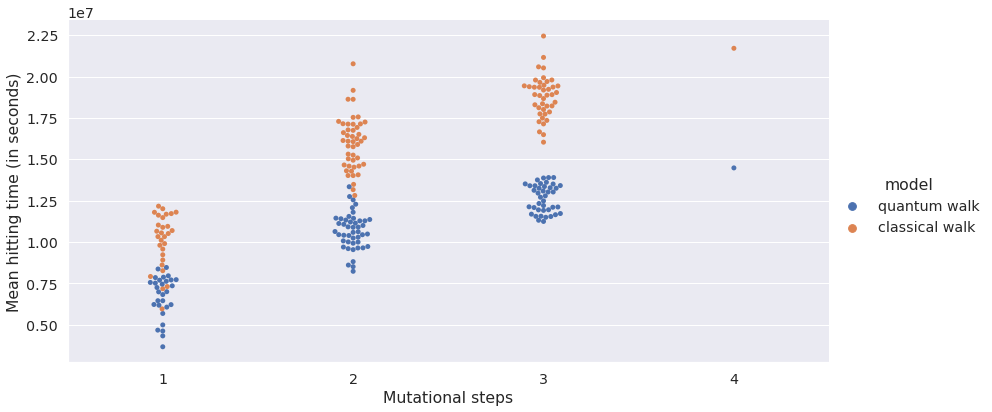

In [ ]:
g = sns.catplot(data=df_hitting_times[gspace_name], x="step", y='mean_hitting_time', hue='model', kind='swarm', 
            height=6, aspect=2, facet_kws={"legend_out": False})
g.set_xlabels("Mutational steps")
g.set_ylabels("Mean hitting time (in seconds)")

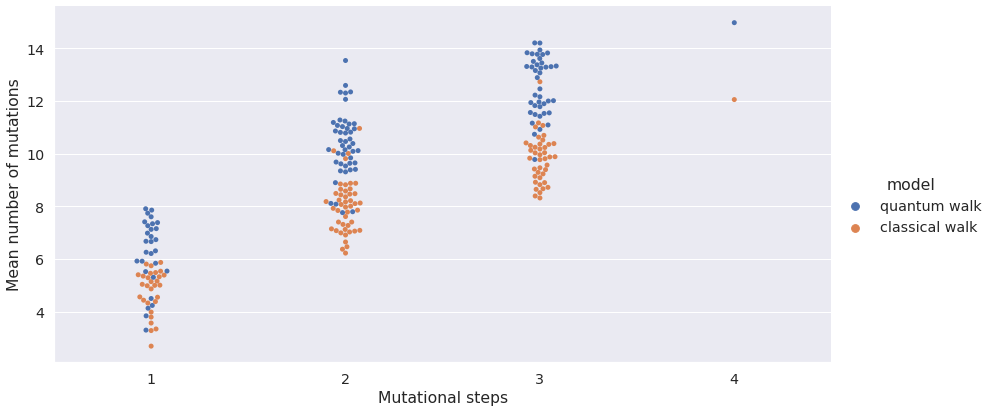

In [ ]:
g = sns.catplot(data=df_hitting_times[gspace_name], x="step", y='mean_mutations', hue='model', kind='swarm', height=6, aspect=2,
    facet_kws={"legend_out": False})
g.set_xlabels("Mutational steps")
g.set_ylabels("Mean number of mutations")

In [ ]:
df_hitting_times[gspace_name].groupby(['model', 'step'])[['mean_hitting_time', 'mean_mutations']].describe()

mean_hitting_time                ... mean_mutations           
                                count          mean  ...            75%        max
model          step                                  ...                          
classical walk 1                 29.0  1.010195e+07  ...       5.392120   5.872914
               2                 46.0  1.597682e+07  ...       8.490679  10.962963
               3                 41.0  1.879147e+07  ...      10.357143  12.735294
               4                  1.0  2.170762e+07  ...      12.058824  12.058824
quantum walk   1                 29.0  6.715603e+06  ...       7.267840   7.911504
               2                 46.0  1.066650e+07  ...      11.065471  13.542857
               3                 41.0  1.264952e+07  ...      13.450746  14.211382
               4                  1.0  1.447856e+07  ...      14.979798  14.979798

[8 rows x 16 columns]

In [ ]:
mr_cw = df_results[gspace_name].groupby(['model'])['coverage_rate'].describe()['mean']['classical walk']
mr_qw = df_results[gspace_name].groupby(['model'])['coverage_rate'].describe()['mean']['quantum walk']

ht_cw = 1.032256e+07
ht_qw = 6.985626e+06

print(mr_cw*ht_cw, mr_qw*ht_qw)

4.431059004522826 6.0335257354150444


In [ ]:
for step in range(1,5):
  mean_cw = df_hitting_times[gspace_name].groupby(['model', 'step'])['mean_hitting_time'].describe()['mean']['classical walk'][step]
  mean_qw = df_hitting_times[gspace_name].groupby(['model', 'step'])['mean_hitting_time'].describe()['mean']['quantum walk'][step]
  print(f"Step = {step}, Speed-up =", mean_cw/mean_qw) 

Step = 1, Speed-up = 1.5042501223139213
Step = 2, Speed-up = 1.497849896195493
Step = 3, Speed-up = 1.48554803629459
Step = 4, Speed-up = 1.4992941862075355


In [ ]:
for step in range(1,5):
  mean_cw = df_hitting_times[gspace_name].groupby(['model', 'step'])['mean_mutations'].describe()['mean']['classical walk'][step]
  mean_qw = df_hitting_times[gspace_name].groupby(['model', 'step'])['mean_mutations'].describe()['mean']['quantum walk'][step]
  print(f"Step = {step}, Difference of mutations =", mean_qw - mean_cw) 

Step = 1, Difference of mutations = 1.474412045904442
Step = 2, Difference of mutations = 2.3781316429772357
Step = 3, Difference of mutations = 2.7700304266243982
Step = 4, Difference of mutations = 2.9209744503862147


## Arabidopsis thaliana

In [ ]:
gspace_name = names[3]

In [ ]:
print("Quantum walk simulations:", df_results[gspace_name][df_results[gspace_name]['model'] == 'quantum walk'].shape[0])
print("Classical walk simulations:", df_results[gspace_name][df_results[gspace_name]['model'] == 'classical walk'].shape[0])

Quantum walk simulations: 1637
Classical walk simulations: 100


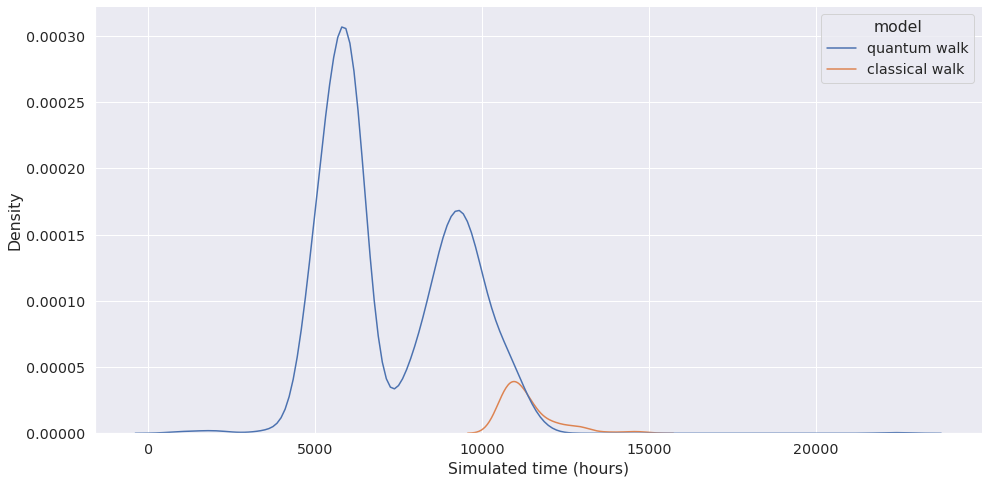

In [ ]:
g = sns.displot(df_results[gspace_name], x='simulation_time', hue='model', kind='kde', 
            height=7, aspect=2, facet_kws={"legend_out": False})
g.set_xlabels("Simulated time (hours)")

Text(0.5, 0, 'Total number of mutations')

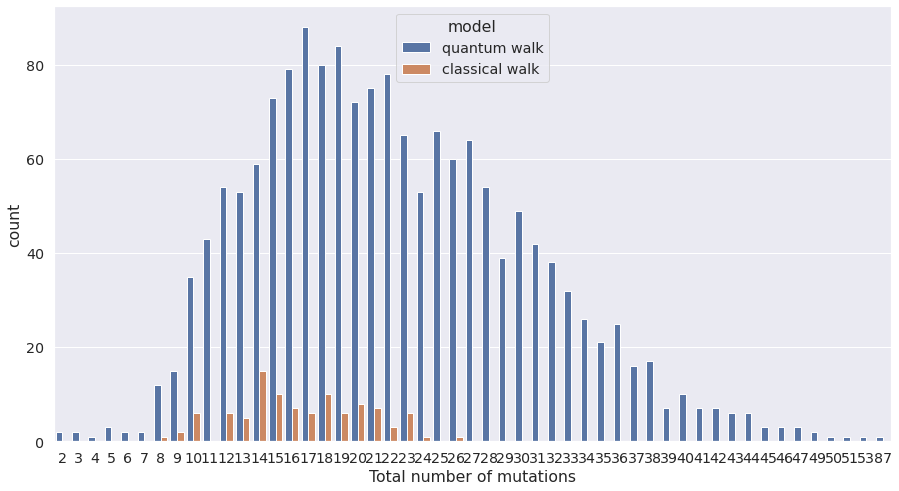

In [ ]:
g = sns.countplot(x="total_mutations", data=df_results[gspace_name], hue="model")
g.set_xlabel("Total number of mutations")

In [ ]:
df_results[gspace_name].groupby(['model'])['simulation_time'].describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
classical walk,100.0,11364.720733,823.972189,10559.807276,10807.530888,11112.698204,11528.619361,14756.228133
quantum walk,1637.0,7320.257113,2003.637004,984.104305,5712.954999,6296.067831,9208.464844,22396.071186


In [ ]:
df_results[gspace_name].groupby(['model'])['total_mutations'].describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
classical walk,100.0,16.520000,3.932460,8.0,14.0,16.0,20.0,26.0
quantum walk,1637.0,22.340867,8.360161,2.0,16.0,21.0,28.0,87.0


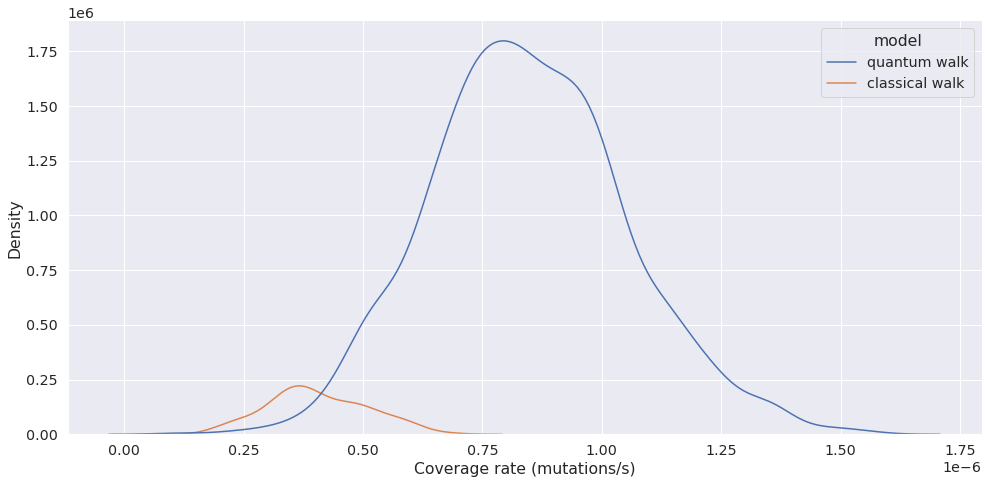

In [ ]:
g = sns.displot(df_results[gspace_name], x='coverage_rate', hue='model', kind='kde', height=7, aspect=2, 
            facet_kws={"legend_out": False})
g.set_xlabels("Coverage rate (mutations/s)")

In [ ]:
df_results[gspace_name].groupby(['model'])['coverage_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
classical walk,100.0,4.060026e-07,1.025021e-07,1.990858e-07,3.420332e-07,3.899030e-07,4.814274e-07,6.684432e-07
quantum walk,1637.0,8.448742e-07,2.064432e-07,1.092055e-07,7.086609e-07,8.360602e-07,9.774234e-07,1.567270e-06


The coverage rate using CTQW is greater than the coverage rate using CTRW:

In [ ]:
df_results[gspace_name].groupby(['model'])['coverage_rate'].describe()['mean']['quantum walk']/df_results[gspace_name].groupby(['model'])['coverage_rate'].describe()['mean']['classical walk']

2.0809575968106593

In [ ]:
df_results[gspace_name].groupby(['model'])['computing_time'].describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
classical walk,100.0,10.302487,2.668994,5.494477,8.585401,9.737798,12.235256,20.470908
quantum walk,1637.0,6.419066,6.488997,5.500000,5.500003,5.500005,5.500008,59.000139


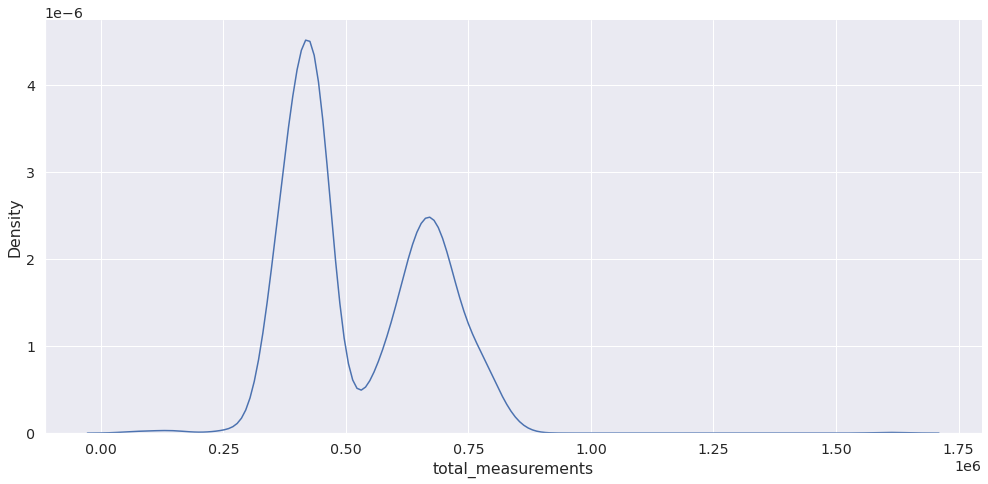

In [ ]:
sns.displot(df_qw_filter[gspace_name], x='total_measurements', kind='kde', height=7, aspect=2, 
            facet_kws={"legend_out": False})

In [ ]:
df_results[gspace_name].groupby(['model'])['total_measurements'].describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
classical walk,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
quantum walk,1637.0,527049.354918,144255.524069,70882.0,411104.0,453057.0,662486.0,1611519.0


In [ ]:
ratios = {}
ratios_better = {}
errors_m = {}
mean_hitting_times = {'model': [], 'step': [], 'phenotype': [], 'mean_hitting_time': [], 'mean_mutations': []}

for step in range(1,7):
  total_phenotypes = len(distance[gspace_name][initial_node[gspace_name]][f'{step}'])
  if total_phenotypes == 0:
    continue
  
  ratios[step] = []
  ratios_better[step] = []
  errors_m[step] = []

  better = 0
  not_hitted = 0

  for phen in distance[gspace_name][initial_node[gspace_name]][f'{step}']:
    mean1 = df_qw_filter[gspace_name][df_qw_filter[gspace_name][f'mutations_{phen}'] != -1][f'tau_{phen}'].mean()
    mean2 = df_cw_filter[gspace_name][df_cw_filter[gspace_name][f'mutations_{phen}'] != -1][f'tau_{phen}'].mean()

    mean1_m = df_qw_filter[gspace_name][df_qw_filter[gspace_name][f'mutations_{phen}'] != -1][f'mutations_{phen}'].mean()
    mean2_m = df_cw_filter[gspace_name][df_cw_filter[gspace_name][f'mutations_{phen}'] != -1][f'mutations_{phen}'].mean()

    ratio = mean1/mean2
    error = mean1_m-mean2_m

    if (not math.isnan(mean1)) and (not math.isnan(mean2)): # If both means exists, then the quantum walk and random walk did hit phenotype phen in some simulations
      if ratio < 1:
        better += 1
        ratios_better[step].append(ratio)
      
      ratios[step].append(ratio)
      errors_m[step].append(error)

      # quantum walk info
      mean_hitting_times['step'].append(step)
      mean_hitting_times['model'].append('quantum walk')
      mean_hitting_times['phenotype'].append(phen)
      mean_hitting_times['mean_hitting_time'].append(mean1)
      mean_hitting_times['mean_mutations'].append(mean1_m)

      # classical walk info
      mean_hitting_times['step'].append(step)
      mean_hitting_times['model'].append('classical walk')
      mean_hitting_times['phenotype'].append(phen)
      mean_hitting_times['mean_hitting_time'].append(mean2)
      mean_hitting_times['mean_mutations'].append(mean2_m)

    else:
      if math.isnan(mean1):
        print(f"Phenotype {phen} at {step} steps was not hitted by quantum walk")
      else:
        print(f"Phenotype {phen} at {step} steps was not hitted by quantum walk")

      not_hitted += 1

  ratios[step] = np.array(ratios[step])
  ratios_better[step] = np.array(ratios_better[step])
  errors_m[step] = np.array(errors_m[step])

  print(f"Phenotypes at {step} steps:") 
  print(f"{total_phenotypes-not_hitted}/{total_phenotypes} were hitted by both walks")
  print(f"{better}/{total_phenotypes - not_hitted} phenotypes had better quantum hitting time")
  print(f"{1/ratios_better[step].mean()} faster")
  print(f"Mean difference between the number of mutations the CTQW and CTRW took to find phenotypes: {errors_m[step].mean()} \n")

Phenotypes at 1 steps:
28/28 were hitted by both walks
28/28 phenotypes had better quantum hitting time
1.4482654145069203 faster
Mean difference between the number of mutations the CTQW and CTRW took to find phenotypes: 2.1673868219968924 

Phenotype NAC2 at 2 steps was not hitted by quantum walk
Phenotypes at 2 steps:
76/77 were hitted by both walks
73/76 phenotypes had better quantum hitting time
1.4331092420080813 faster
Mean difference between the number of mutations the CTQW and CTRW took to find phenotypes: 3.5248839551735607 

Phenotype ORA59 at 3 steps was not hitted by quantum walk
Phenotype AT2G40620 at 3 steps was not hitted by quantum walk
Phenotype RGL2 at 3 steps was not hitted by quantum walk
Phenotypes at 3 steps:
55/58 were hitted by both walks
53/55 phenotypes had better quantum hitting time
1.470059311760384 faster
Mean difference between the number of mutations the CTQW and CTRW took to find phenotypes: 3.5145228538892157 

Phenotype ATAREB1 at 4 steps was not hitt

In [ ]:
df_hitting_times[gspace_name] = pd.DataFrame(mean_hitting_times)
df_hitting_times[gspace_name]

,model,step,phenotype,mean_hitting_time,mean_mutations
0,quantum walk,1,EDT1,8.567823e+06,7.560694
1,classical walk,1,EDT1,1.197499e+07,4.604651
2,quantum walk,1,ATGRP2B,8.469051e+06,7.847619
3,classical walk,1,ATGRP2B,1.171503e+07,5.095238
4,quantum walk,1,GATA8,1.105389e+07,9.804688
...,...,...,...,...,...
391,classical walk,5,ATERF6,3.372826e+07,9.000000
392,quantum walk,5,CRF4,2.110225e+07,19.699029
393,classical walk,5,CRF4,2.781449e+07,16.000000
394,quantum walk,5,AT3G23230,2.116492e+07,20.038462


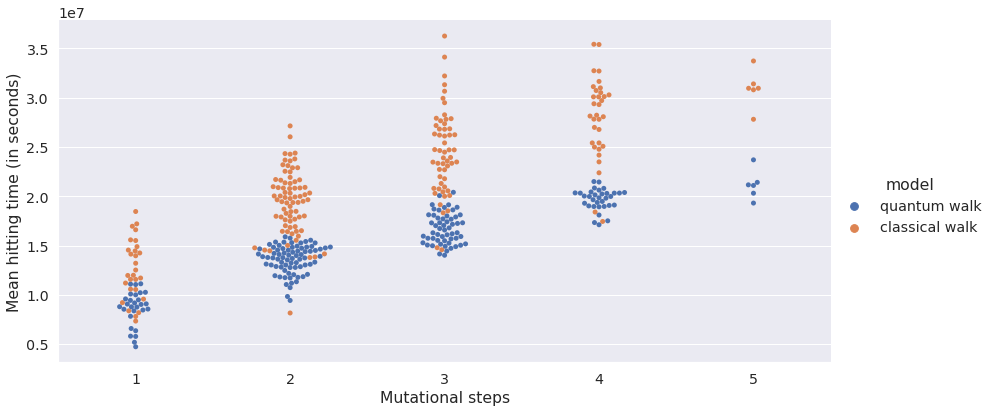

In [ ]:
g = sns.catplot(data=df_hitting_times[gspace_name], x="step", y='mean_hitting_time', hue='model', kind='swarm', 
            height=6, aspect=2, facet_kws={"legend_out": False})
g.set_xlabels("Mutational steps")
g.set_ylabels("Mean hitting time (in seconds)")

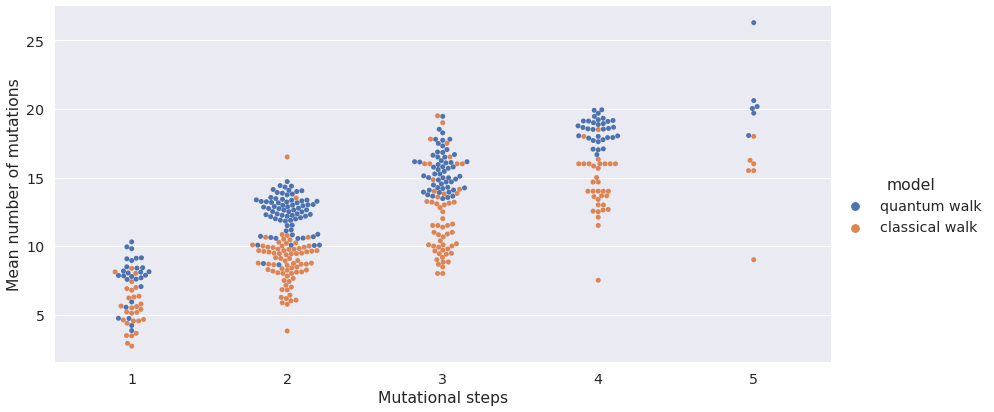

In [ ]:
g = sns.catplot(data=df_hitting_times[gspace_name], x="step", y='mean_mutations', hue='model', kind='swarm', height=6, aspect=2,
    facet_kws={"legend_out": False})
g.set_xlabels("Mutational steps")
g.set_ylabels("Mean number of mutations")

In [ ]:
df_hitting_times[gspace_name].groupby(['model', 'step'])[['mean_hitting_time', 'mean_mutations']].describe()

mean_hitting_time                ... mean_mutations           
                                count          mean  ...            75%        max
model          step                                  ...                          
classical walk 1                 28.0  1.264588e+07  ...       6.449451   8.368421
               2                 76.0  1.943857e+07  ...       9.787879  16.500000
               3                 55.0  2.453901e+07  ...      13.685714  19.500000
               4                 33.0  2.805364e+07  ...      16.000000  18.500000
               5                  6.0  3.094545e+07  ...      16.187500  18.000000
quantum walk   1                 28.0  8.624145e+06  ...       8.594722  10.303502
               2                 76.0  1.362384e+07  ...      13.272386  14.700000
               3                 55.0  1.672365e+07  ...      16.488648  19.461538
               4                 33.0  1.968870e+07  ...      19.122137  19.942857
               5                  6.0  2.116997e+07  ...      20.506972  26.300000

[10 rows x 16 columns]

In [ ]:
mr_cw = df_results[gspace_name].groupby(['model'])['coverage_rate'].describe()['mean']['classical walk']
mr_qw = df_results[gspace_name].groupby(['model'])['coverage_rate'].describe()['mean']['quantum walk']

ht_cw = 1.032256e+07
ht_qw = 6.985626e+06

print(mr_cw*ht_cw, mr_qw*ht_qw)

4.190986380208529 5.901975397560339


In [ ]:
for step in range(1,5):
  mean_cw = df_hitting_times[gspace_name].groupby(['model', 'step'])['mean_hitting_time'].describe()['mean']['classical walk'][step]
  mean_qw = df_hitting_times[gspace_name].groupby(['model', 'step'])['mean_hitting_time'].describe()['mean']['quantum walk'][step]
  print(f"Step = {step}, Speed-up =", mean_cw/mean_qw) 

Step = 1, Speed-up = 1.4663347203213408
Step = 2, Speed-up = 1.4268055873692425
Step = 3, Speed-up = 1.4673239627498613
Step = 4, Speed-up = 1.4248603462588592


In [ ]:
for step in range(1,5):
  mean_cw = df_hitting_times[gspace_name].groupby(['model', 'step'])['mean_mutations'].describe()['mean']['classical walk'][step]
  mean_qw = df_hitting_times[gspace_name].groupby(['model', 'step'])['mean_mutations'].describe()['mean']['quantum walk'][step]
  print(f"Step = {step}, Difference of mutations =", mean_qw - mean_cw) 

Step = 1, Difference of mutations = 2.1673868219968924
Step = 2, Difference of mutations = 3.5248839551735625
Step = 3, Difference of mutations = 3.514522853889215
Step = 4, Difference of mutations = 4.162488520199114
